In [1]:
import logging
import math
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.utils.data as data

from pathlib import Path

from numpy import random

import pandas as pd
import scipy.sparse as sp
import scipy.io as sio
from scipy.signal import butter, sosfilt, lfilter
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from skfuzzy.cluster import cmeans

In [2]:
class Logger:
    def __init__(self, path, cmd_level=logging.INFO, file_level=logging.DEBUG):
        self.logger = logging.getLogger(path)
        self.logger.setLevel(logging.DEBUG)

        fmt = logging.Formatter('[%(asctime)s] [%(levelname)s]    %(message)s', '%Y-%m-%d %H:%M:%S')
        # 设置CMD日志
        sh = logging.StreamHandler()
        sh.setFormatter(fmt)
        sh.setLevel(cmd_level)
        # 设置文件日志
        fh = logging.FileHandler(path, encoding='utf-8')
        fh.setFormatter(fmt)
        fh.setLevel(file_level)
        self.logger.addHandler(sh)
        self.logger.addHandler(fh)
        self.logger.propagate = False  # 解决同一条日志，重复打印两次。

    def debug(self, message):
        self.logger.debug(message)

    def info(self, message):
        self.logger.info(message)

    def war(self, message):
        self.logger.warning(message)

    def error(self, message):
        self.logger.error(message)

    def cri(self, message):
        self.logger.critical(message)

    def exception(self, message):
        self.logger.exception(message)

In [3]:
class standardDataSet(data.Dataset):
    # x_tensor: (sample, channel, datapoint(feature)) type = torch.tensor
    # y_tensor: (sample,) type = torch.tensor
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
        assert len(self.x) == len(self.y)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.y)

In [4]:
rootpath = 'C:/Users/BCIgroup/Desktop/yqh/Experiment/samelimb/samelimb_EEGTNet_4hp_noresample_e400_b128_1e-3decay'
# datasetpath = 'C:/Users/BCIgroup/Desktop/yqh/data/bcic2020/multigrasp/sub'
log_path = rootpath + '/log/' + 'samelimb_EEGTNet_4hp_noresample_e400_b128_1e-3decay' + '.log'
logger = Logger(log_path, cmd_level=logging.INFO, file_level=logging.DEBUG)

In [5]:
# from scipy.signal import butter, sosfilt, sosfreqz

# def butter_bandpass(lowcut, highcut, fs, order=5):
#         nyq = 0.5 * fs
#         low = lowcut / nyq
#         high = highcut / nyq
#         sos = butter(order, [low, high], analog=False, btype='band', output='sos')
#         return sos

# def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
#         sos = butter_bandpass(lowcut, highcut, fs, order=order)
#         y = sosfilt(sos, data)
#         return y
    
# def butter_lowpass(lowcut, fs, order=5):
#         nyq = 0.5 * fs
#         low = lowcut / nyq
#         sos = butter(order, low, analog=False, btype='low', output='sos')
#         return sos

# def butter_lowpass_filter(data, lowcut, fs, order=5):
#         sos = butter_lowpass(lowcut, fs, order=order)
#         y = sosfilt(sos, data)
#         return y
    
# def butter_highpass(highcut, fs, order=5):
#         nyq = 0.5 * fs
#         high = highcut / nyq
#         sos = butter(order, high, analog=False, btype='low', output='sos')
#         return sos

# def butter_highpass_filter(data, highcut, fs, order=5):
#         sos = butter_highpass(highcut, fs, order=order)
#         y = sosfilt(sos, data)
#         return y

In [6]:
# 加载数据，滤波
class Utils:
    @staticmethod
    def normalize_adj(adj):
        adj = sp.coo_matrix(adj) #A sparse matrix in COOrdinate format.
        rowsum = np.array(adj.sum(1))
        d_inv_sqrt = np.power(rowsum, -0.5).flatten()
        d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
        d_mat_inv_sqrt = sp.diags(d_inv_sqrt) #Construct a sparse matrix from diagonals.
        return sp.csr_matrix.todense(adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt))
    
    @staticmethod
    def get_adj(num_node, adj_type):
        #We also regard each node as connecting to itself.
        self_link = [(i,i) for i in range(num_node)]

        if (adj_type == 'ng'): # neighboring connections with allover
            neighbor_link = [(1, 2), (1,31),(1,39),(1,8),(1,30),(1,32),(1,9),(1,41),
                           (2, 3), (2,32),(2,9),(2,31),(2,33),(2,10),(2,8),
                           (3,33),(3,10),(3,32),(3,34),(3,11),(3,9),
                           (5, 6), (5,35),(5,12),(5,34),(5,36),(5,13),(5,11),
                           (6, 7), (6,36),(6,13),(6,35),(6,37),(6,14),(6,12),
                           (7, 40),(7,37),(7,14),(7,36),(7,38),(7,42),(7,13),
                           (8, 9), (8,15),(8,41),(8,39),(8,16),(8,45),
                           (9, 10), (9,16),(9,15),(9,17),
                           (10, 11), (10,17),(10,16),(10,18),
                           (11, 12), (11,18),(11,17),(11,19),
                           (12, 13), (12,19),(12,18),(12,20),
                           (13, 14), (13,20),(13,19),(13,21),
                           (14, 21), (14,42),(14,40),(14,46),(14,20),
                           (15, 16), (15,45),(15,48),(15,41),(15,47),(15,49),
                           (16, 17), (16,49),(16,48),(16,50),
                           (17, 18), (17,50),(17,51),(17,49),
                           (18, 19), (18,51),(18,50),(18,52),
                           (19, 20), (19,52),(19,51),(19,53),
                           (20, 21), (20,53),(20,52),(20,54),
                           (21, 46), (21,54),(21,42),(21,53),(21,55),
                           (22,26),(22,25),(22,27),
                           (24, 28), (24,27),(24,29),
                           (25, 26), (25,32),(25,31),(25,33),
                           (26, 27), (26,33),(26,34),(26,32),
                           (27, 28), (27,34),(27,33),(27,35),
                           (28, 29), (28,35),(28,34),(28,36),
                           (29, 36), (29,35),(29,37),
                           (30, 31), (30,39),
                           (31, 32), (31,39),
                           (33, 34),
                           (34, 35),
                           (35, 36),
                           (36, 37),
                           (37, 38), (37,40),
                           (38, 40),
                           (39, 41),
                           (40, 42),
                           (41,45),
                           (42,46),
                           (45, 47), (45,48),
                           (46, 55), (46,54),
                           (47, 48),
                           (48, 49), (48,56),
                           (49, 50), (49,56),(49,57),
                           (50, 51), (50,57),(50,56),(50,58),
                           (51, 52), (51,58),(51,57),(51,59),
                           (52, 53), (52,59),(52,58),(52,60),
                           (53, 54), (53,60),(53,59),
                           (54, 55), (54,60),
                           (56, 57), (56,61),
                           (57, 58), (57,61),(57,62),
                           (58, 59), (58,62),(58,61),(58,63),
                           (59, 60), (59,63),(59,62),
                           (60, 63), 
                           (61, 62), (61,64),
                           (62, 63), (62,64),
                           (63, 64)]

            list1=[]
            #1-3 #5-22 -1  #24-42 -2 #45-64 -4
            for i, j in neighbor_link:
                if(5 <= i <= 22):
                    i=i-1
                if(24 <= i <=42):
                    i=i-2
                if(45 <= i <= 64):
                    i=i-4
                if(5 <= j <= 22):
                    j=j-1
                if(24 <= j <=42):
                    j=j-2
                if(45 <= j <= 64):
                    j=j-4
                list1.append((i,j))

            neighbor_link = list1
            neighbor_link = [(i - 1, j - 1) for (i, j) in neighbor_link]
            edge = self_link + neighbor_link
            # edge = neighbor_link
            # construct adjacency matrix
            A = np.zeros((num_node, num_node))
            for i, j in edge:
                A[i, j] = 1
                A[j, i] = 1
            adj = Utils.normalize_adj(A)

    
        elif (adj_type == 'dg'): # threshold distance optimal self
            A = np.zeros([num_node, num_node])
            loc = pd.read_csv("./PhysioNet_electrode_positions_60.csv", index_col=False)
            x = np.array(loc['x'])
            y = np.array(loc['y'])
            z = np.array(loc['z'])
            for m in range(num_node):
                for n in range(num_node):
                    if m != n:
                        A[m, n] = np.power(
                            np.power((x[m] - x[n]), 2) + np.power((y[m] - y[n]), 2) + np.power((z[m] - z[n]), 2), -0.5)
            x_loc = np.expand_dims(np.where(A>np.mean(A))[0], axis=1)
            y_loc = np.expand_dims(np.where(A>np.mean(A))[1], axis=1)
            loc = np.append(x_loc,y_loc, axis=1)
            for i,j in loc:
                A[i, j] = 0
            for k in range(num_node):
                A[k,k]=np.mean(A[k])
            adj = Utils.normalize_adj(A)
            
        return adj #numpy.matrix
    
    @staticmethod
    def KFoldSplit(current_fold, taskData, taskLabel, restData, restLabel):
        """获取 train 和 test 的 index """
        testRestIndex = list(i for i in range((current_fold - 1) * 15, current_fold * 15))
        trainRestIndex = list(i for i in range(75) if i not in testRestIndex)
        testTaskIndex = list(i for i in range((current_fold - 1) * 8, current_fold * 8))
        trainTaskIndex = list(i for i in range(40) if i not in testTaskIndex)
        """数据集的划分，数据集划分是对session划分，再合并session"""
        """划分train"""
        trainTaskData = taskData[:, trainTaskIndex]
        trainTaskLabel = taskLabel[:, trainTaskIndex]
        trainRestData = restData[:, trainRestIndex]
        trainRestLabel = restLabel[:, trainRestIndex]
        """划分test"""
        testTaskData = taskData[:, testTaskIndex]
        testTaskLabel = taskLabel[:, testTaskIndex]
        testRestData = restData[:, testRestIndex]
        testRestLabel = restLabel[:, testRestIndex]
        """合并session"""
#         samplepoints 512
#         channels 62
#         torch.Size([480, 62, 512])
#         torch.Size([480])
#         torch.Size([240, 62, 512])
#         torch.Size([240])
#         torch.Size([120, 62, 512])
#         torch.Size([120])
#         torch.Size([60, 62, 512])
#         torch.Size([60])
        samplepoints = testTaskData.shape[3]
        channels = testTaskData.shape[2]
        trainTaskData = trainTaskData.reshape(-1, channels, samplepoints)
        trainTaskLabel = trainTaskLabel.reshape(-1)
        trainRestData = trainRestData.reshape(-1, channels, samplepoints)
        trainRestLabel = trainRestLabel.reshape(-1)
        testTaskData = testTaskData.reshape(-1, channels, samplepoints)
        testTaskLabel = testTaskLabel.reshape(-1)
        testRestData = testRestData.reshape(-1, channels, samplepoints)
        testRestLabel = testRestLabel.reshape(-1)
        # """合并任务"""
        train_data = np.concatenate((trainTaskData, trainRestData)) #(720, 62, 512)
        train_label = np.concatenate((trainTaskLabel, trainRestLabel))
        test_data = np.concatenate((testTaskData, testRestData)) #(180, 62, 512)
        test_label = np.concatenate((testTaskLabel, testRestLabel))

        """打乱数据"""
        train_index = [i for i in range(len(train_label))]  # 打乱数据
        random.seed(42)
        random.shuffle(train_index)
        train_data = train_data[train_index]
        train_label = train_label[train_index]

        test_index = [i for i in range(len(test_label))]  # 打乱数据
        random.seed(42)
        random.shuffle(test_index)
        test_data = test_data[test_index]
        test_label = test_label[test_index]
        return train_data, train_label, test_data, test_label

    @staticmethod
    def KFoldSplitSessionWise(current_fold, taskData, taskLabel,):
        label_size = len(taskLabel[0])
        test_size = int(label_size / 5)
        """获取 train 和 test 的 index """
        testTaskIndex = list(i for i in range((current_fold - 1) * test_size, current_fold * test_size))
        trainTaskIndex = list(i for i in range(label_size) if i not in testTaskIndex)
        """数据集的划分，数据集划分是对session划分，再合并session"""
        """划分train"""
        trainTaskData = taskData[:, trainTaskIndex]
        trainTaskLabel = taskLabel[:, trainTaskIndex]
        """划分test"""
        testTaskData = taskData[:, testTaskIndex]
        testTaskLabel = taskLabel[:, testTaskIndex]
        """合并session"""
        samplepoints = testTaskData.shape[3]
        channels = testTaskData.shape[2]
        train_data = trainTaskData.reshape(-1, channels, samplepoints)
        train_label = trainTaskLabel.reshape(-1)

        test_data = testTaskData.reshape(-1, channels, samplepoints)
        test_label = testTaskLabel.reshape(-1)

        """打乱数据"""
        train_index = [i for i in range(len(train_label))]  # 打乱数据
        random.seed(42)
        random.shuffle(train_index)
        train_data = train_data[train_index]
        train_label = train_label[train_index]

        test_index = [i for i in range(len(test_label))]  # 打乱数据
        random.seed(42)
        random.shuffle(test_index)
        test_data = test_data[test_index]
        test_label = test_label[test_index]
        
        return train_data, train_label, test_data, test_label
    
    @staticmethod
    def KFoldSplitSessionWisesi(current_fold, allData, alllable):
        samplepoints = allData.shape[4]
        channels = allData.shape[3]
        subs = allData.shape[0]

        #合并session
        allData = allData.reshape(subs,-1, channels, samplepoints) #torch.Size([15, 300, 60, 512])
        alllable = alllable.reshape(subs, -1) #torch.Size([15, 300])  
        #
        testIndex = current_fold - 1
        trainIndex = list(i for i in range(15) if i != testIndex)
        #划分
        test_data = allData[testIndex] #torch.Size([300, 60, 512])
        test_label = alllable[testIndex] #torch.Size([300])


        train_data = allData[trainIndex] #torch.Size([14, 300, 60, 512])
        train_label = alllable[trainIndex] #torch.Size([14, 300])

        train_data = torch.reshape(train_data, (-1,channels, samplepoints)) #torch.Size([4200, 60, 512])
        train_label = torch.reshape(train_label, (-1,)) #torch.Size([4200])

        #打乱数据
        train_index = [i for i in range(len(train_label))]
        random.seed(42)
        random.shuffle(train_index)
        
        train_data = train_data[train_index]
        train_label = train_label[train_index]
        
        test_index = [i for i in range(len(test_label))] 
        random.seed(42)
        random.shuffle(test_index)
        
        test_data = test_data[test_index]
        test_label = test_label[test_index]
        
        return train_data, train_label, test_data, test_label    
    
    @staticmethod
    def load_data_from_gdf(path,tmin,tmax):
        print("load_data_for_cnn has start")
        '''加载数据'''
        rawdata = mne.io.read_raw_gdf(path, preload=True)
        '''0.5的高通滤波'''
        raw = rawdata
        # raw = raw.copy().filter(0.5, None)

        '''查看所有的事件'''
        # (events_from_annot, event_dict) = mne.events_from_annotations(raw)
        # print(events_from_annot)
        # print(event_dict)
        '''选择感兴趣的事件'''
        # custom_mapping = {'769': 0, '770': 1, '771': 2, '772': 3}
        #['1536', '1537', '1538', '1539', '1540', '1541', '1542',, '1540': 4, '1541': 5
        custom_mapping = {'1536': 0, '1537': 1, '1538': 2, '1539': 3}
        (events_from_annot, event_dict) = mne.events_from_annotations(raw, event_id=custom_mapping)
        # print(events_from_annot)
        # print(event_dict)
        '''去除掉振幅大于80微伏的数据，这种数据一般不是认知产生的，是外部异常导致的不良数据'''
        # reject_criteria = dict(eeg=80e-6)
        '''非常重要，设置时间，以trigger为基准'''
        # tmin = 0  # start of each epoch (200ms before the trigger)
        # tmax = 3  # end of each epoch (4000ms after the trigger)
        sfreq = raw.info['sfreq']
        '''定义坏的通道，在以后的处理中，会自动除去坏的通道。'''
        # raw.info['bads'] = ['EOG-left', 'EOG-central', 'EOG-right']
        raw.info['bads'] =  raw.ch_names[61:]

        # print(raw.info['bads'])
        '''调整基准线，后面的数据都会被表示为以该基准线的相对变化。'''
        # baseline = (-0.2, 0)  # means from the first instant to t = 0

        '''picks = mne.pick_channels_regexp(raw.ch_names, regexp='MEG 2..3') # 根据正则表达式来选择通道。'''
        picks = mne.pick_types(raw.info, meg=False, eeg=True, exclude='bads')
        # mne.epochs(),没用使用picks参数。
        epochs = mne.Epochs(raw, events_from_annot, event_dict, tmin, tmax, proj=True, picks=picks,
                            # reject=reject_criteria,
                            baseline=(None, None),
                            preload=True, verbose='WARNING')
        # print(epochs)
        '''
            type(epochs)
                Out: mne.epochs.Epochs
            epochs: 
                Out: <Epochs |  280 events (all good), -0.2 - 1 sec, baseline [-0.2, 0], ~14.2 MB, data loaded,
                        '769': 69
                        '770': 71
                        '771': 69
                        '772': 71>
            epochs.events.shape: 
                Out: (280, 3) 
                280 是 trials_number, 3 是 三元组，事件的触发时间点，第二个一般是零，第三个一般是标签。
            epochs.event_id
                Out: {'769': 0, '770': 1, '771': 2, '772': 3}    
            epochs.ch_names:
                Out: ['EEG-Fz','EEG-0','EEG-1','EEG-2','EEG-3','EEG-4','EEG-5', 'EEG-C3','EEG-6','EEG-Cz','EEG-7','EEG-C4','EEG-8','EEG-9','EEG-10','EEG-11','EEG-12','EEG-13','EEG-14','EEG-Pz','EEG-15', 'EEG-16']

            data = epochs.get_data()
                data.shape
                    Out: (280, 22, 301) trials、channels、samples，
                data[1].shape
                    Out: (22, 301)

            label = epochs.events[:,2]
                获取events三元组的第三列，赋值给label数组。label.shape = 280， 
                label 是一个numpy.ndarray，
                转换成torch的方法是：
                    1、b = torch.from_numpy(a)
                    2、c = torch.Tensor(a) #也可以转pytorch Tensor
        '''
        # epochs.crop()
        # epochs.apply_hilbert()

        print("load_data_for_cnn has completed")
        return epochs

    @staticmethod
    def load_data_form_elevenClass(path, fs, start, end):
        print("load_data_for_cnn has start")
        n_samples = int(fs * 4)
        # '''加载数据'''
        rawdata = sio.loadmat(path)
        yOneHot = rawdata['mrk']['y'].item()
        label = yOneHot.argmax(0)
        print(Counter(label))
        task_index = [i for i in range(len(label)) if label[i] != 2]
        taskLabel = label[task_index]
        fs = rawdata['mrk']['fs'].item().item()
        pos = rawdata['mrk']['pos'].item().reshape(-1)

        keys = list(rawdata.keys())
        # data = data3.fromkeys(keys)
        channels = []
        for key in keys[keys.index('ch1'):keys.index('ch60') + 1]:
            # print(key, rawdata.get(key).reshape(-1).shape)
            channels.append(rawdata.get(key).reshape(-1))
        # fromkeys,创建一个新字典，
        # data = data3.fromkeys(keys,data3.get('ch1'))
        # print("channels: ",type(channels))
        # list没有办法切片，转化成np.array。
        data = np.array(channels)
        # 去除静息态。
        taskPos = pos[task_index]
        taskList = []
        for start in taskPos:
            # print(start, start + 10000)
            taskList.append(data[:, start:start + 10000])
        taskData = np.array(taskList)
        # 降采样 signal.resample(taskData, 1000,axis=2)
        # taskData = Utils.butter_highpass_filter(taskData, highcut=4, fs=fs, order=5)
        taskData = signal.resample(taskData, n_samples, axis=2)  # 将数据由200Hz 的 800个点，降采样到128 Hz 的512个点，
        return taskData, taskLabel

    @staticmethod
    def plotsingle(data,fs):
        import pylab as pl
        # 采样步长
        t = [x / float(fs) for x in range(fs)]
        """
        设计的采样值
        假设信号y由4个周期信号叠加所得,如下所示
        """
        y = data[0][0][25]
        pl.plot(t, y)
        pl.xlabel('time(s)')
        pl.title("original signal")
        pl.show()

    @staticmethod
    def load_data_form_hhg(path, fs, start, end):
        print("load {}".format(path))
        n_samples = int(fs * 4)
        # '''加载数据'''
        rawdata = sio.loadmat(path)
        task_data = rawdata['task_data']  # sessions, trials, channels, timepoints (15, 40, 62, 800)
        task_label = rawdata['task_label']  # sessions, label (15, 40)
        rest_data = rawdata['rest_data'].reshape(4, 75, 62, 800) #(300, 62, 800) to (4, 75, 62, 800)
        rest_label = np.zeros((4, 75))
        orifs = 200
#         Utils.plotsingle(task_data,task_data.shape[3]) #800
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html#scipy.signal.butter
#         sos = signal.butter(5, [4,40], 'band', fs=200, output='sos',analog=False)
#         task_data = signal.sosfilt(sos, task_data)
#         rest_data = signal.sosfilt(sos, rest_data)
#         taskData = Utils.butter_bandpass_filter(taskData,lowcut=4, highcut=40, fs=200, order=5)
#         restData = Utils.butter_bandpass_filter(restData,lowcut=4, highcut=40, fs=200, order=5)
#         task_data = Utils.butter_bandpass_filter(task_data,4, 40, fs=200, order=5)
#         rest_data = Utils.butter_bandpass_filter(rest_data,4, 40, fs=200, order=5)
#         taskData = Utils.butter_highpass_filter(task_data, highcut=4, fs=200, order=3)
#         restData = Utils.butter_highpass_filter(rest_data, highcut=4, fs=200, order=3)
        taskData = Utils.butter_highpass_filter(task_data, highcut=4, fs=200, order=3)
        restData = Utils.butter_highpass_filter(rest_data, highcut=4, fs=200, order=3)
#         taskData = Utils.butter_bandpass_filter(task_data, lowcut = 4, highcut = 40, fs=200, order=3)
#         restData = Utils.butter_bandpass_filter(rest_data, lowcut = 4, highcut = 40, fs=200, order=3)        
#         Utils.plotsingle(task_data,task_data.shape[3])
        if fs != orifs:
            restData = signal.resample(restData, n_samples, axis=3)
            restData = restData[:, :, :, int(fs * start): int(fs * end)]
            taskData = signal.resample(taskData, n_samples, axis=3)  # 将数据由200Hz 的 800个点，降采样到128 Hz 的512个点，
            taskData = taskData[:, :, :, int(fs * start): int(fs * end)]
        
        return taskData, task_label, restData, rest_label
    
    @staticmethod
    def load_data_form_2020bcic(path, fs, start, end):
#         data sampled at 250 Hz, and applied a 60 Hz with a notch filter. 
        print("load {}".format(path))
        # '''加载数据'''
        rawdata = sio.loadmat(path)
        n_samples = int(fs * 4)
        task_data = rawdata['epo'].item()[3] # timepoints, channels, trials #(2501, 60, 150)
        task_data = np.swapaxes(task_data, 0, 2) #  <class 'numpy.ndarray'> (150, 60, 2501)
        
#         # a 60Hz notch filter to remove the power-line artifact
#         # 设计二阶IIR陷波器数字滤波器。IIR滤波器的分子(b)和分母(a)多项式
#         b_notch, a_notch = signal.iirnotch(60.0, 30.0, fs=orifs)
#         task_data = signal.filtfilt(b_notch, a_notch, task_data)
#         # 1Hz high pass filter
#         task_data = Utils.butter_highpass_filter(task_data, highcut=1, fs=orifs, order=5)
        
        yOneHot = rawdata['epo'].item()[4]  # label #(3, 150) one-hot
        task_label = yOneHot.argmax(0) # (150,)
        #6-10s MI
        task_data = task_data[:,:,1500:2501]   #(150, 60, 1001)
#         task_data = task_data[1500:2501,:,:] # (1001, 60, 150) #6-10s MI
        orifs = rawdata['epo'].item()[1].item() #250Hz

        #scipy.signal.resample(x, num, t=None, axis=0, window=None, domain='time')
        #Resample x to num samples using Fourier method along the given axis.
        if fs != orifs:
            task_data = signal.resample(task_data, n_samples, axis=2)  # 将数据由250Hz 的 1000个点，降采样到128 Hz 的512个点，
        # timepoints, channels, trials  transform to trials, channels, timepoints
#         task_data = np.swapaxes(task_data, 0, 2)
            taskData = task_data[:, :, int(fs * start): int(fs * end)]
        else:
            taskData= task_data
        
        return taskData, task_label
    
    @staticmethod
    def plot_result(module, sub, fold, path, train, eval, type):
        title = "{}_{}_{}_{}".format(module, type, sub, fold)
        train_mat = path + title + '.mat'
        eval_mat = path + title + '.mat'
        sio.savemat(train_mat, {'train' + type: train})
        sio.savemat(eval_mat, {'test' + type: eval})
        time = np.linspace(1, len(train), len(train), dtype=int)
        plt.figure(figsize=(8, 5), dpi=300)
        plt.grid()
        plt.xlabel("Epoch(s)")
        plt.ylabel(type)
        plt.title(title)
        plt.plot(time, train, label='train', color="red", linewidth=1)
        plt.plot(time, eval, label='test', color="blue", linewidth=1)
        plt.legend()
        filepath = path + title
        plt.savefig(filepath)
        plt.show()

    # python 滤波器实现
#     https: // blog.csdn.net/quanshengxixin/article/details/68943206
#     https://www.pythonheidong.com/blog/article/162964/be1a7dd41c410b67d66f/
#     https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html#scipy.signal.butter
    @staticmethod
    def butter_highpass(highcut, fs, order=3):
        nyq = 0.5 * fs
        high = highcut / nyq
        sos = butter(order, high, analog=False, btype='highpass', output='sos')
        return sos
    
    @staticmethod
    def butter_highpass_filter(data, highcut, fs, order=3):
        sos = Utils.butter_highpass(highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y
    
    @staticmethod
    def butter_bandpass(lowcut, highcut, fs, order=3):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='bandpass', output='sos')
        return sos
    
    @staticmethod
    def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
        sos = Utils.butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y
    
#     @staticmethod
#     def butter_bandpass(lowcut, highcut, fs, order=5):
#         nyq = 0.5 * fs
#         low = lowcut / nyq
#         high = highcut / nyq
#         b, a = butter(order, (low, high), btype="bandpass")
#         return b, a

#     @staticmethod
#     def butter_highpass(highcut, fs, order=5):
#         nyq = 0.5 * fs
#         high = highcut / nyq
#         b, a = butter(order, high, btype='highpass')
#         return b, a

#     @staticmethod
#     def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
#         b, a = Utils.butter_bandpass(lowcut, highcut, fs, order=order)
#         y = lfilter(b, a, data)
#         return y

#     @staticmethod
#     def butter_highpass_filter(data, highcut, fs, order=5):
#         b, a = Utils.butter_highpass(highcut, fs, order=order)
#         y = lfilter(b, a, data)
#         return y

    @staticmethod
    def loadpath(path, start, len):
        s = start - 1
        e = start + len - 1
        datalist = []
        for p in Path(path).iterdir():
            datalist.append(p)
        # logger.info("datalist: \n",datalist[s:e])
        return datalist[s:e]
    @staticmethod
    def KFoldSplitFB(current_fold, taskData, taskLabel, restData, restLabel):
        """获取 train 和 test 的 index """
        testRestIndex = list(i for i in range((current_fold - 1) * 15, current_fold * 15))
        trainRestIndex = list(i for i in range(75) if i not in testRestIndex)
        testTaskIndex = list(i for i in range((current_fold - 1) * 8, current_fold * 8))
        trainTaskIndex = list(i for i in range(40) if i not in testTaskIndex)
        """数据集的划分，数据集划分是对session划分，再合并session"""
        """划分train"""
        trainTaskData = taskData[:,:, trainTaskIndex]
        trainTaskLabel = taskLabel[:, trainTaskIndex]
        trainRestData = restData[:,:, trainRestIndex]
        trainRestLabel = restLabel[:, trainRestIndex]
        """划分test"""
        testTaskData = taskData[:,:, testTaskIndex]
        testTaskLabel = taskLabel[:, testTaskIndex]
        testRestData = restData[:,:, testRestIndex]
        testRestLabel = restLabel[:, testRestIndex]
        """合并session"""
        samplepoints = testTaskData.shape[4]
        channels = testTaskData.shape[3]
        trainTaskData = trainTaskData.reshape(9,-1, channels, samplepoints)
        trainTaskLabel = trainTaskLabel.reshape(-1)
        trainRestData = trainRestData.reshape(9,-1, channels, samplepoints)
        trainRestLabel = trainRestLabel.reshape(-1)
        testTaskData = testTaskData.reshape(9,-1, channels, samplepoints)
        testTaskLabel = testTaskLabel.reshape(-1)
        testRestData = testRestData.reshape(9,-1, channels, samplepoints)
        testRestLabel = testRestLabel.reshape(-1)
        # """合并任务"""
        train_data = np.concatenate((trainTaskData, trainRestData),axis=1)
        train_label = np.concatenate((trainTaskLabel, trainRestLabel))
        test_data = np.concatenate((testTaskData, testRestData),axis=1)
        test_label = np.concatenate((testTaskLabel, testRestLabel))

        """打乱数据"""
        train_index = [i for i in range(len(train_label))]  # 打乱数据
        random.seed(42)
        random.shuffle(train_index)
        train_data = train_data[:,train_index]
        train_label = train_label[train_index]

        test_index = [i for i in range(len(test_label))]  # 打乱数据
        random.seed(42)
        random.shuffle(test_index)
        test_data = test_data[:,test_index]
        test_label = test_label[test_index]
        return train_data, train_label, test_data, test_label

In [1]:
import torch
import torch.nn as nn
import sys
current_module = sys.modules[__name__]

debug = False

#Depthwise Convolution 
class Conv2dWithConstraint(nn.Conv2d):
    def __init__(self, *args, doWeightNorm = True, max_norm=1, **kwargs):
        self.max_norm = max_norm
        self.doWeightNorm = doWeightNorm
        super(Conv2dWithConstraint, self).__init__(*args, **kwargs)

    def forward(self, x):
        if self.doWeightNorm: 
            self.weight.data = torch.renorm(
                self.weight.data, p=2, dim=0, maxnorm=self.max_norm
            )
        return super(Conv2dWithConstraint, self).forward(x)
    
class LinearWithConstraint(nn.Linear):
    def __init__(self, *args, doWeightNorm = True, max_norm=1, **kwargs):
        self.max_norm = max_norm
        self.doWeightNorm = doWeightNorm
        super(LinearWithConstraint, self).__init__(*args, **kwargs)

    def forward(self, x):
        if self.doWeightNorm: 
            self.weight.data = torch.renorm(
                self.weight.data, p=2, dim=0, maxnorm=self.max_norm
            )
        return super(LinearWithConstraint, self).forward(x)
    

In [8]:

#%% Deep convnet - Baseline 1
class deepConvNet(nn.Module):
    def convBlock(self, inF, outF, dropoutP, kernalSize,  *args, **kwargs):
        return nn.Sequential(
            nn.Dropout(p=dropoutP),
            Conv2dWithConstraint(inF, outF, kernalSize, bias= False, max_norm = 2, *args, **kwargs),
            nn.BatchNorm2d(outF),
            nn.ELU(),
            nn.MaxPool2d((1,2), stride = (1,2))
            )

    def firstBlock(self, outF, dropoutP, kernalSize, nChan, *args, **kwargs):
        return nn.Sequential(
                Conv2dWithConstraint(1,outF, kernalSize, padding = 0, max_norm = 2, *args, **kwargs),
                Conv2dWithConstraint(25, 25, (nChan, 1), padding = 0, bias= False, max_norm = 2),
                nn.BatchNorm2d(outF),
                nn.ELU(),
                nn.MaxPool2d((1,2), stride = (1,2))
                )

    def lastBlock(self, inF, outF, kernalSize, *args, **kwargs):
        return nn.Sequential(
                Conv2dWithConstraint(inF, outF, kernalSize, max_norm = 0.5,*args, **kwargs),
                nn.LogSoftmax(dim = 1))

    def calculateOutSize(self, model, nChan, nTime):
        '''
        Calculate the output based on input size.
        model is from nn.Module and inputSize is a array.
        '''
        data = torch.rand(1,1,nChan, nTime)
        model.eval()
        out = model(data).shape
        return out[2:]

    def __init__(self, nChan, nTime, nClass = 3, dropoutP = 0.5, *args, **kwargs):
        super(deepConvNet, self).__init__()

        kernalSize = (1,5)
        nFilt_FirstLayer = 25
        nFiltLaterLayer = [25, 50, 100, 200]

        firstLayer = self.firstBlock(nFilt_FirstLayer, dropoutP, kernalSize, nChan)
        middleLayers = nn.Sequential(*[self.convBlock(inF, outF, dropoutP, kernalSize)
            for inF, outF in zip(nFiltLaterLayer, nFiltLaterLayer[1:])])

        self.allButLastLayers = nn.Sequential(firstLayer, middleLayers)

        self.fSize = self.calculateOutSize(self.allButLastLayers, nChan, nTime)
        self.lastLayer = self.lastBlock(nFiltLaterLayer[-1], nClass, (1, self.fSize[1]))

    def forward(self, x):
        x = x.reshape(shape=(x.shape[0], 1, x.shape[1], x.shape[2]))
        x = self.allButLastLayers(x)
        x = self.lastLayer(x)
        x = torch.squeeze(x, 3)
        x = torch.squeeze(x, 2)

        return x



In [9]:
#%% EEGNet Baseline 2
class EEGNet(nn.Module):
    def initialBlocks(self, dropoutP, *args, **kwargs):
        block1 = nn.Sequential(
                nn.Conv2d(1, self.F1, (1, self.C1),
                          padding = (0, self.C1 // 2 ), bias =False),
                nn.BatchNorm2d(self.F1),
                Conv2dWithConstraint(self.F1, self.F1 * self.D, (self.nChan, 1),
                                     padding = 0, bias = False, max_norm = 1,
                                     groups=self.F1),
                nn.BatchNorm2d(self.F1 * self.D),
                nn.ELU(),
                nn.AvgPool2d((1,4), stride = 4),
                nn.Dropout(p = dropoutP))
        block2 = nn.Sequential(
                nn.Conv2d(self.F1 * self.D, self.F1 * self.D,  (1, 16),
                                     padding = (0, 16//2) , bias = False,
                                     groups=self.F1* self.D),
                nn.Conv2d(self.F1 * self.D, self.F2, (1,1),
                          stride =1, bias = False, padding = 0),
                nn.BatchNorm2d(self.F2),
                nn.ELU(),
                nn.AvgPool2d((1,8), stride = 8),
                nn.Dropout(p = dropoutP)
                )
        return nn.Sequential(block1, block2)

    def lastBlock(self, inF, outF, kernalSize, *args, **kwargs):
        return nn.Sequential(
                nn.Conv2d(inF, outF, kernalSize, *args, **kwargs),
                nn.LogSoftmax(dim = 1))

    def calculateOutSize(self, model, nChan, nTime):
        '''
        Calculate the output based on input size.
        model is from nn.Module and inputSize is a array.
        '''
        data = torch.rand(1,1,nChan, nTime)
        model.eval()
        out = model(data).shape
        return out[2:]
    #self.model(60, 512, 3, 0.5, 8, 2, 32, )
    def __init__(self, nChan, nTime, nClass = 3,
                 dropoutP = 0.5, F1=8, D = 2,
                 C1 = 32, *args, **kwargs):
        super(EEGNet, self).__init__()
        self.F2 = D*F1
        self.F1 = F1
        self.D = D
        self.nTime = nTime
        self.nClass = nClass
        self.nChan = nChan
        self.C1 = C1

        self.firstBlocks = self.initialBlocks(dropoutP)
        self.fSize = self.calculateOutSize(self.firstBlocks, nChan, nTime)
        self.lastLayer = self.lastBlock(self.F2, nClass, (1, self.fSize[1]))

    def forward(self, x):
        x = x.reshape(shape=(x.shape[0], 1, x.shape[1], x.shape[2]))
        x = self.firstBlocks(x)
        x = self.lastLayer(x)
        x = torch.squeeze(x, 3)
        x = torch.squeeze(x, 2)
        return x


In [10]:
# data = torch.rand(20,60, 512)
# eeg=EEGNet(60, 512)
# # print(eeg(data).shape)

# x =torch.rand(20,16, 1,8)
# print(x.size())
# x = x.view(x.size()[0], -1)  # Flatten
# print(x.size())

In [2]:
# 导入库
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm

# 这个函数是用来修剪卷积之后的数据的尺寸，让其与输入数据尺寸相同。
#实现因果卷积的类
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()



# 这个就是TCN的基本模块，包含8个部分，两个（卷积+修剪+relu+dropout）
# 里面提到的downsample就是下采样，其实就是实现残差链接的部分。不理解的可以无视这个
#残差模块
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        #第一个扩散卷积层
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        #第一个扩散卷积层的输出和padding大小实现因果卷积
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        
        #第二个同样结构的卷积层
        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        #堆叠 net
        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        #卷积前后的通道数不一定相等，nn.Conv1d(n_outputs, n_inputs, 1)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        #残差模块
        return self.relu(out + res)

#TCN的主网络
class TemporalConvNet(nn.Module):
    '''
    num_inputs = 输入数据的通道数
    num_channels应该是个列表，其他的np.array也行，比方说是[2,1]。那么整个TCN模型包含两个TemporalBlock，整个模型共有4个卷积层，
    第一个TemporalBlock的两个卷积层的膨胀系数dilation=pow(2,0)=1，第二个TemporalBlock的两个卷积层的膨胀系数是dilation=pow(2,1)=2.
        s = TemporalConvNet_spp(num_inputs=84, num_channels=[128,128,256,256,512,512],kernel_size=2, dropout=0.2)
            print(s(torch.randn([1,84,400]))[1].shape)
    '''
    # num_channels为各层卷积运算的输出通道数或卷积核数量 [12, 12]
    # num_channels的长度为需要执行的卷积层数量
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        #扩张系数随着网路层级的增加而指数增加：增大感受野并不丢弃任何输入序列的元素
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [3]:
# 
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        print('shape:',x.shape)      #print(x.shape)
#         print(x[0,0,0:10,0:10])
        return x

In [5]:
#EEGTNet
"""
F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
"""
class EEGTNet(nn.Module):
    def eegnetBlock(self, dropoutP, *args, **kwargs):
        
        block1 = nn.Sequential(
                nn.Conv2d(1, self.F1, (1, self.C1), padding=(0, self.C1 // 2), bias=False),
#                 nn.BatchNorm2d(self.F1),
#                 PrintLayer(), # Add Print layer for debug
                nn.BatchNorm2d(self.F1, momentum=0.01, affine=True, eps=1e-3),
                # DepthwiseConv2D =======================
                # At groups= in_channels, each input channel is convolved with its own set of filters
                Conv2dWithConstraint(self.F1, self.F1 * self.D, (self.nChan, 1), padding=0, bias=False, max_norm=1, groups=self.F1),
                #========================================
#                 nn.BatchNorm2d(self.F1 * self.D),
                nn.BatchNorm2d(self.F1 * self.D, momentum=0.01, affine=True, eps=1e-3),
#                 nn.LeakyReLU(),
                nn.ELU(),
                nn.AvgPool2d((1, 8), stride=8),
#                 nn.AvgPool2d((1, 4), stride = 4),
                nn.Dropout(p=self.dropoutP))
        
        block2 = nn.Sequential(
                # SeparableConv2D =======================128/4=32  32/2=16 128/8=16 16/2=8
                nn.Conv2d(self.F1 * self.D, self.F1 * self.D, (1, self.C2), padding=(0, self.C2 // 2), bias=False, groups=self.F1 * self.D),
                nn.Conv2d(self.F1 * self.D, self.F2, (1,1), padding=(0, 0), groups=1, bias=False, stride=1),
                # ========================================
#                 nn.BatchNorm2d(self.F2),
                nn.BatchNorm2d(self.F2, momentum=0.01, affine=True, eps=1e-3),
#                 nn.LeakyReLU(),
                nn.ELU(),
                nn.AvgPool2d((1, 8), stride=8),
                nn.Dropout(p=self.dropoutP))
        
        return nn.Sequential(block1, block2)
    
#     def TNetBlock(self, input_dimension = 16, depth = 2, kernel_size = 4, filters = 12,dropout = 0.3, *args, **kwargs):
# #             block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=1,activation='linear',
# #                    padding = 'causal',kernel_initializer='he_uniform')(input_layer)
#         nn.Sequential(
#                 TemporalConvNet()
# #                 nn.Conv1d(in_channels = input_dimension, filters, kernel_size, dilation=1),
            
# #             return 
#         )
    
    def calculateOutSize(self, model, nChan, nTime): 
        data = torch.rand(1, 1, nChan, nTime)
        model.eval()
        out = model(data).shape
#         print(out)
        # out:torch.Size([1, 16, 1, 8])
        # torch.Size([1, 8])
        return out[2:]
    
#     def lastBlock(self, inF, outF, kernalSize, *args, **kwargs):
#         return nn.Sequential(
#                 nn.Conv2d(inF, outF, kernalSize, *args, **kwargs),
#                 nn.LogSoftmax(dim=1))
    # 12*8
    def ClassifierBlock(self, inputSize, n_classes):
        return nn.Sequential(
            nn.Linear(inputSize, n_classes, bias=False))
#             nn.Softmax(dim=1))
    
    #self.model(60, 512, 3, 0.5, 8, 2, 32, )
    #C1=128/2
    def __init__(self, nChan, nTime, nClass = 3,
                 dropoutP = 0.5, F1=8, D = 2,
                 C1 = 64, C2 = 8, *args, **kwargs):
        super(EEGTNet, self).__init__()
        self.F2 = D*F1
        self.F1 = F1
        self.D = D
        self.nTime = nTime
        self.nClass = nClass
        self.nChan = nChan
        self.C1 = C1
        self.C2 = C2
        self.dropoutP = dropoutP
#         print(self.C1,self.C2,self.dropoutP,self.nChan)
        self.FirstBlock = self.eegnetBlock(dropoutP)
        
        # torch.Size([1, 8])
        self.FirstBlockSize = self.calculateOutSize(self.FirstBlock, nChan, nTime)
        
        self.tcn = TemporalConvNet(num_inputs = self.F2, num_channels = [12, 12], kernel_size = 4, dropout=0.3)
    
        self.classifierBlock = self.ClassifierBlock(12 * self.FirstBlockSize[1], nClass)
    
    def forward(self, x):
        x = x.reshape(shape=(x.shape[0], 1, x.shape[1], x.shape[2]))
        print('输入数据:', x.shape)
        x = self.FirstBlock(x)
        print('eegnet后的输出:', x.shape)
        # 返回张量与输入张量共享内存，所以改变其中一个的内容会改变另一个。
        x = torch.squeeze(x, 2)
        x = self.tcn(x)
        print('tcn后的输出:', x.shape)
        
        x = x.view(x.size()[0], -1)  # Flatten
        print('flatten:', x.shape)
        x = self.classifierBlock(x)
        print('softmaxres:', x.shape)
        print(x)

        return x

In [6]:
model=EEGTNet(60, 512)
data = torch.rand(20, 60, 512)
# model.eval()
out = model(data).shape
out

输入数据: torch.Size([20, 1, 60, 512])
eegnet后的输出: torch.Size([20, 16, 1, 8])
tcn后的输出: torch.Size([20, 12, 8])
flatten: torch.Size([20, 96])
softmaxres: torch.Size([20, 3])
tensor([[0.2917, 0.0944, 0.1615],
        [0.3126, 0.1034, 0.1703],
        [0.2963, 0.1549, 0.1441],
        [0.2618, 0.1839, 0.1619],
        [0.2826, 0.0917, 0.1680],
        [0.2305, 0.1401, 0.1308],
        [0.2264, 0.1664, 0.1499],
        [0.2161, 0.1413, 0.1259],
        [0.2604, 0.1601, 0.1467],
        [0.2480, 0.1830, 0.1929],
        [0.2697, 0.1844, 0.1466],
        [0.2360, 0.1750, 0.1743],
        [0.2715, 0.1584, 0.1554],
        [0.2187, 0.1631, 0.2019],
        [0.2598, 0.1698, 0.2137],
        [0.2009, 0.1667, 0.1121],
        [0.2450, 0.1717, 0.1704],
        [0.2757, 0.1300, 0.1852],
        [0.2923, 0.1562, 0.1635],
        [0.2497, 0.1561, 0.1696]], grad_fn=<MmBackward>)


torch.Size([20, 3])

In [15]:
# #%% Support classes for FBNet Implementation
# import sys
# current_module = sys.modules[__name__]
# class VarLayer(nn.Module):
#     '''
#     The variance layer: calculates the variance of the data along given 'dim'
#     '''
#     def __init__(self, dim):
#         super(VarLayer, self).__init__()
#         self.dim = dim

#     def forward(self, x):
#         return x.var(dim = self.dim, keepdim= True)

# class StdLayer(nn.Module):
#     '''
#     The standard deviation layer: calculates the std of the data along given 'dim'
#     '''
#     def __init__(self, dim):
#         super(StdLayer, self).__init__()
#         self.dim = dim

#     def forward(self, x):
#         return x.std(dim = self.dim, keepdim=True)

# class LogVarLayer(nn.Module):
#     '''
#     The log variance layer: calculates the log variance of the data along given 'dim'
#     (natural logarithm)
#     '''
#     def __init__(self, dim):
#         super(LogVarLayer, self).__init__()
#         self.dim = dim

#     def forward(self, x):
#         return torch.log(torch.clamp(x.var(dim = self.dim, keepdim= True), 1e-6, 1e6))

# class MeanLayer(nn.Module):
#     '''
#     The mean layer: calculates the mean of the data along given 'dim'
#     '''
#     def __init__(self, dim):
#         super(MeanLayer, self).__init__()
#         self.dim = dim

#     def forward(self, x):
#         return x.mean(dim = self.dim, keepdim=True)

# class MaxLayer(nn.Module):
#     '''
#     The max layer: calculates the max of the data along given 'dim'
#     '''
#     def __init__(self, dim):
#         super(MaxLayer, self).__init__()
#         self.dim = dim

#     def forward(self, x):
#         ma ,ima = x.max(dim = self.dim, keepdim=True)
#         return ma

# class swish(nn.Module):
#     '''
#     The swish layer: implements the swish activation function
#     '''
#     def __init__(self):
#         super(swish, self).__init__()

#     def forward(self, x):
#         return x * torch.sigmoid(x)

# class Conv2dWithConstraint(nn.Conv2d):
#     def __init__(self, *args, doWeightNorm = True, max_norm=1, **kwargs):
#         self.max_norm = max_norm
#         self.doWeightNorm = doWeightNorm
#         super(Conv2dWithConstraint, self).__init__(*args, **kwargs)

#     def forward(self, x):
#         if self.doWeightNorm: 
#             self.weight.data = torch.renorm(
#                 self.weight.data, p=2, dim=0, maxnorm=self.max_norm
#             )
#         return super(Conv2dWithConstraint, self).forward(x)
    
# class LinearWithConstraint(nn.Linear):
#     def __init__(self, *args, doWeightNorm = True, max_norm=1, **kwargs):
#         self.max_norm = max_norm
#         self.doWeightNorm = doWeightNorm
#         super(LinearWithConstraint, self).__init__(*args, **kwargs)

#     def forward(self, x):
        
#         if self.doWeightNorm: 
#             self.weight.data = torch.renorm(
#                 self.weight.data, p=2, dim=0, maxnorm=self.max_norm
#             )
#         return super(LinearWithConstraint, self).forward(x)
    
# class FBCNet(nn.Module):
#     # just a FBCSP like structure : chan conv and then variance along the time axis
#     '''
#         FBNet with seperate variance for every 1s. 
#         The data input is in a form of batch x 1 x chan x time x filterBand
#     '''
#     def SCB(self, m, nChan, nBands, doWeightNorm=True, *args, **kwargs):
#         '''
#         The spatial convolution block
#         m : number of sptatial filters.
#         nBands: number of bands in the data
#         '''
#         return nn.Sequential(
#                 Conv2dWithConstraint(nBands, m*nBands, (nChan,1), groups= nBands,
#                                      max_norm = 2 , doWeightNorm = doWeightNorm,padding = 0),
#                 nn.BatchNorm2d(m*nBands),
#                 swish()
#                 )

    
#     def LastBlock(self, inF, outF, doWeightNorm=True, *args, **kwargs):
#         return nn.Sequential(
#                 LinearWithConstraint(inF, outF, max_norm = 0.5, doWeightNorm = doWeightNorm, *args, **kwargs),
#                 nn.LogSoftmax(dim = 1))

#     def __init__(self, nChan, nTime, nClass = 3, nBands = 9, m = 32,
#                  temporalLayer = 'LogVarLayer', strideFactor= 4, doWeightNorm = True, *args, **kwargs):
#         super(FBCNet, self).__init__()
# #         print("nChan, nTime",nChan, nTime)
#         self.nBands = nBands
#         self.m = m
#         self.strideFactor = strideFactor

#         # create all the parrallel SCBc
#         self.scb = self.SCB(m, nChan, self.nBands, doWeightNorm = doWeightNorm)
        
#         # Formulate the temporal agreegator
#         self.temporalLayer = current_module.__dict__[temporalLayer](dim = 3)

#         # The final fully connected layer
#         self.lastLayer = self.LastBlock(self.m*self.nBands*self.strideFactor, nClass, doWeightNorm = doWeightNorm)

#     def forward(self, x):
# #       batch  Nb, C x T
#         x = self.scb(x)
# #       batch  m*Nb, C x T
#         x = x.reshape([*x.shape[0:2], self.strideFactor, int(x.shape[3]/self.strideFactor)])
#         x = self.temporalLayer(x)
#         x = torch.flatten(x, start_dim= 1)
#         x = self.lastLayer(x)
#         return x

In [16]:
from sklearn.cluster import SpectralClustering, KMeans
from matplotlib import pyplot as plt
import networkx as nx
import seaborn as sns
from sklearn.metrics import pairwise_distances 

In [17]:
# from scipy.signal import cheb2ord
# class FilterBank:
#     def __init__(self,fs):
#         self.fs = fs
#         self.f_trans = 2
#         self.f_pass = np.arange(4,40,4)
#         self.f_width = 4
#         self.gpass = 3
#         self.gstop = 30
#         self.filter_coeff={}

#     def get_filter_coeff(self):
#         Nyquist_freq = self.fs/2

#         for i, f_low_pass in enumerate(self.f_pass):
#             f_pass = np.asarray([f_low_pass, f_low_pass+self.f_width])
#             f_stop = np.asarray([f_pass[0]-self.f_trans, f_pass[1]+self.f_trans])
#             wp = f_pass/Nyquist_freq
#             ws = f_stop/Nyquist_freq
#             order, wn = cheb2ord(wp, ws, self.gpass, self.gstop)
#             b, a = signal.cheby2(order, self.gstop, ws, btype='bandpass')
#             self.filter_coeff.update({i:{'b':b,'a':a}})

#         return self.filter_coeff

#     def filter_data(self,eeg_data,window_details={}):
#         n_trials, n_channels, n_samples = eeg_data.shape
#         if window_details:
#             n_samples = int(self.fs*(window_details.get('tmax')-window_details.get('tmin')))
#         filtered_data=np.zeros((len(self.filter_coeff),n_trials,n_channels,n_samples))
#         for i, fb in self.filter_coeff.items():
#             b = fb.get('b')
#             a = fb.get('a')
#             eeg_data_filtered = np.asarray([signal.lfilter(b,a,eeg_data[j,:,:]) for j in range(n_trials)])
#             if window_details:
#                 eeg_data_filtered = eeg_data_filtered[:,:,int((window_details.get('tmin'))*self.fs):int((window_details.get('tmax'))*self.fs)]
#             filtered_data[i,:,:,:]=eeg_data_filtered

#         return filtered_data

In [18]:
class pipeLine:
    allData = []
    alllabel = []
    
    def loadData2020bcicforsi(self, datapath):
#         print("datapath {}".format(datapath))
        taskData = []
        task_label = []
        path = ''
        for path in datapath:
            data, label = Utils.load_data_form_2020bcic(path, self.args['fs'], self.args['start'], self.args['end'])
            taskData.append(data)
            task_label.append(label)
            
        task_label = np.array(task_label)
        taskData = np.array(taskData)
        
#         print('task_data:',taskData.shape)
#         print('task_label:',task_label.shape)

        self.allData.append(taskData)
        self.alllabel.append(task_label)
        
#         self.datapath = datapath.stem
        
#         print(self.taskData.shape)
#         print(self.task_label.shape)
        return 0

    def KFoldTrainsi(self):
        """设定随机数，保证实验结果可重现"""
        torch.manual_seed(self.args['seed'])
        torch.cuda.manual_seed(self.args['seed'])
        torch.cuda.manual_seed_all(self.args['seed'])
        
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
        
        allData = np.array(self.allData) # (15, 2, 150, 60, 512)
        alllable =np.array(self.alllabel) # (15, 2, 150)
        
        allData = torch.from_numpy(allData) 
        alllable = torch.from_numpy(alllable) 
        
        """ 交叉验证 """
        image_path = self.args['rootpath'] + '/image/'
        self.logger.info("image_path: {} ".format(image_path))
        self.logger.info("logpath: {} ".format(log_path))
        KFoldAcc = []
        for current_fold in range(1, 16):
            if current_fold < self.args['fold_start']:  # 前面9个报内存不足，可以用该方法直接训练第十个。
                continue
            if self.args['dataset'] == 'bci':
                train_data, train_label, test_data, test_label = Utils.KFoldSplitSessionWisesi(current_fold, allData,
                                                                                             alllable)
#                 #add graph
#                 train_data = torch.matmul(adj, train_data)
#                 test_data = torch.matmul(adj, test_data)
                
            
            model_path = self.args['rootpath'] + '/model/' + 'subject-independent' + '_fold_' + str(
                current_fold) + '_max_model.pt'

            self.logger.info("current_fold: {} ".format(current_fold))
            self.logger.info("model_path: {} ".format(model_path))
            if self.args['model'] == 'eegnet':
                train_ls, train_acc, test_ls, test_acc, samplesAcc = self._train(train_data, train_label, test_data,
                                                                                 test_label, model_path, logger)
            if self.args['model'] == 'alcnet':
                train_ls, train_acc, test_ls, test_acc, samplesAcc = self._auxiliarytrain(train_data, train_label,
                                                                                          test_data, test_label,
                                                                                          model_path, logger)

            Utils.plot_result(self.args['model'], 'subject-independent', current_fold, image_path, train_ls, test_ls, "loss")
            Utils.plot_result(self.args['model'], 'subject-independent', current_fold, image_path, train_acc, test_acc, "acc")

            KFoldAcc.append(samplesAcc.item())
            self.logger.info("current_fold Acc : {}".format(KFoldAcc[-1]))
        
        final_result_mean = np.mean(KFoldAcc)
        final_result_std = np.std(KFoldAcc)
#         self.logger.info("datapath \t{}".format(self.datapath))
#         self.logger.info("subject \t{}".format(self.subject_id))
        self.logger.info("result of KFlodTrain : {}".format(KFoldAcc))
        self.logger.info("mean of KFlodTrain \t{:.4f} ".format(final_result_mean))
        self.logger.info("std of KFlodTrain \t{:.4f} ".format(final_result_std))
        
        return KFoldAcc
    
    def __init__(self, logger, model):
        self.logger = logger
        self.model = model
        torch.set_default_tensor_type(torch.DoubleTensor)
        pass

    def progress(self, count, total, suffix=''):
        bar_len = 60
        filled_len = int(round(bar_len * count / float(total)))

        percents = round(100.0 * count / float(total), 1)
        bar = '>' * filled_len + '-' * (bar_len - filled_len)

        sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', suffix))
        sys.stdout.flush()  # As suggested by Rom Ruben

    def _trainFB(self, train_data, train_label, test_data, test_label, model_path, logger):
        traindataset = standardDataSet(train_data, train_label)
        train_iter = DataLoader(traindataset, self.args['batch_size'], shuffle=False)
        testdataset = standardDataSet(test_data, test_label)
        test_iter = DataLoader(testdataset, len(test_label), shuffle=False)
        input_size = (self.args['batch_size'], test_data.shape[1], test_data.shape[2])
        """ initialization a model """
#         brainDecode https://github.com/braindecode/braindecode/tree/master/braindecode/models
#         net = self.model(in_chans=test_data.shape[1],n_classes=self.args['classes_num'],
#                          input_window_samples=test_data.shape[2],final_conv_length="auto",pool_mode="mean",
#                  F1=8,D=2,F2=16,kernel_length=self.args['temporal_kernel_size'],third_kernel_size=(8, 4),
#                          drop_prob=self.args['dropout']).to(self.args['device']) 
#         FBCNet nChan, nTime, nClass = 3,
        net = self.model(test_data.shape[2], test_data.shape[3], nClass=self.args['classes_num'],
                         dropoutP=self.args['dropout'], F1=8, D=2,
                         C1=self.args['temporal_kernel_size']).to(self.args['device'])
        #         net = self.model(self.args['classes_num'], input_size, self.args['dropout'], self.args['temporal_kernel_size'], self.args['pooling_one_size'],
        #                      self.args['pooling_two_size']).to(self.args['device'])  # 每个K都要实例化新模型
        # Adam优化算法, 默认参数为 params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False)
        optimizer = torch.optim.Adam(params=net.parameters(), lr=self.args['learning_rate'],
                                     weight_decay=self.args['weight_decay'])
        loss_func = torch.nn.CrossEntropyLoss()
        LR_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=self.args['learning_decay'])
        print("Net", net)

        train_ls, train_acc, test_ls, test_acc = [], [], [], []
        for epoch in range(self.args['epochs']):
            self.progress(epoch, self.args['epochs'], 'epoch:' + str(epoch))
            """训练"""
            epochTrainAcc = np.array([])
            epochTrainLoss = np.array([])
            net.train()
            for iter_id, (X, y) in enumerate(train_iter):  # 分批训练
                X = X.to(self.args['device'])
                y = y.to(self.args['device'])
                pri_output = net(X)
                optimizer.zero_grad()
                pri_loss = loss_func(pri_output, y.long())
                pri_loss.backward()
                optimizer.step()
                index = pri_output.argmax(dim=1)
                samplesAcc = index.eq(y).sum() / len(y)
                epochTrainAcc = np.append(epochTrainAcc, samplesAcc.detach().cpu())
                epochTrainLoss = np.append(epochTrainLoss, pri_loss.data.detach().cpu())
            ### 得到每个epoch的 loss 和 accuracy
            train_acc = np.append(train_acc, epochTrainAcc.sum() / len(epochTrainAcc))
            train_ls = np.append(train_ls, epochTrainLoss.sum() / len(epochTrainLoss))

            # # >> > scheduler = ...
            # # >> > for epoch in range(100):
            # #     >> > train(...)
            # #     >> > validate(...)
            # #     >> > scheduler.step()
            if self.args['use_lr_decay']:
                LR_scheduler.step()

            """Test"""
            epochTestAcc = np.array([])
            epochTestLoss = np.array([])
            net.eval()
            with torch.no_grad():
                for X, y in test_iter:  # 分批训练
                    X = X.to(self.args['device'])
                    y = y.to(self.args['device'])
                    pri_output = net(X)
                    index = pri_output.argmax(dim=1)
                    samplesAcc = index.eq(y).sum() / len(y)
                    pri_loss = loss_func(pri_output, y.long())
                    epochTestAcc = np.append(epochTestAcc, samplesAcc.detach().cpu())
                    epochTestLoss = np.append(epochTestLoss, pri_loss.data.detach().cpu())

            test_acc = np.append(test_acc, epochTestAcc.sum() / len(epochTestAcc))
            test_ls = np.append(test_ls, epochTestLoss.sum() / len(epochTestLoss))

        ######## test process ########
        net.eval()
        with torch.no_grad():
            for X, y in test_iter:  # 分批训练
                X = X.to(self.args['device'])
                y = y.to(self.args['device'])
                pri_output = net(X)
                index = pri_output.argmax(dim=1)
                samplesTestAcc = index.eq(y).sum() / len(y)
                torch.save(net, model_path)
                return train_ls, train_acc, test_ls, test_acc, samplesTestAcc
        
    def _train(self, train_data, train_label, test_data, test_label, model_path, logger):
        traindataset = standardDataSet(train_data, train_label)
        train_iter = DataLoader(traindataset, self.args['batch_size'], shuffle=False)
        testdataset = standardDataSet(test_data, test_label)
        test_iter = DataLoader(testdataset, len(test_label), shuffle=False)
        input_size = (self.args['batch_size'], test_data.shape[1], test_data.shape[2])
        """ initialization a model """
#         brainDecode https://github.com/braindecode/braindecode/tree/master/braindecode/models
#         net = self.model(in_chans=test_data.shape[1],n_classes=self.args['classes_num'],
#                          input_window_samples=test_data.shape[2],final_conv_length="auto",pool_mode="mean",
#                  F1=8,D=2,F2=16,kernel_length=self.args['temporal_kernel_size'],third_kernel_size=(8, 4),
#                          drop_prob=self.args['dropout']).to(self.args['device']) 
#         FBCNet
        
        net = self.model(test_data.shape[1], test_data.shape[2], nClass=self.args['classes_num'],
                         dropoutP=self.args['dropout'], F1=8, D=2, C2=self.args['C2'],
                         C1=self.args['temporal_kernel_size']).to(self.args['device'],)
        #         net = self.model(self.args['classes_num'], input_size, self.args['dropout'], self.args['temporal_kernel_size'], self.args['pooling_one_size'],
        #                      self.args['pooling_two_size']).to(self.args['device'])  # 每个K都要实例化新模型
        # Adam优化算法, 默认参数为 params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False)
        optimizer = torch.optim.Adam(params=net.parameters(), lr=self.args['learning_rate'],
                                     weight_decay=self.args['weight_decay'])
        # The input is expected to contain raw, unnormalized scores for each class.
        # cross_entropy = log_softmax + nll_loss 
        loss_func = torch.nn.CrossEntropyLoss()
        LR_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=self.args['learning_decay'])
#         for i in range(1):
#             print("Net", net)

        train_ls, train_acc, test_ls, test_acc = [], [], [], []
        for epoch in range(self.args['epochs']):
            self.progress(epoch, self.args['epochs'], 'epoch:' + str(epoch))
            """训练"""
            epochTrainAcc = np.array([])
            epochTrainLoss = np.array([])
            net.train()
            for iter_id, (X, y) in enumerate(train_iter):  # 分批训练
                X = X.to(self.args['device'])
                y = y.to(self.args['device'])
                pri_output = net(X)
                optimizer.zero_grad()
                pri_loss = loss_func(pri_output, y.long())
                pri_loss.backward()
                optimizer.step()
                index = pri_output.argmax(dim=1)
                samplesAcc = index.eq(y).sum() / len(y)
                epochTrainAcc = np.append(epochTrainAcc, samplesAcc.detach().cpu())
                epochTrainLoss = np.append(epochTrainLoss, pri_loss.data.detach().cpu())
            ### 得到每个epoch的 loss 和 accuracy
            train_acc = np.append(train_acc, epochTrainAcc.sum() / len(epochTrainAcc))
            train_ls = np.append(train_ls, epochTrainLoss.sum() / len(epochTrainLoss))

            # # >> > scheduler = ...
            # # >> > for epoch in range(100):
            # #     >> > train(...)
            # #     >> > validate(...)
            # #     >> > scheduler.step()
#             if self.args['use_lr_decay'] and (epoch < 200):
#                 LR_scheduler.step()
            if self.args['use_lr_decay']:
                LR_scheduler.step()

            """Test"""
            epochTestAcc = np.array([])
            epochTestLoss = np.array([])
            net.eval()
            with torch.no_grad():
                for X, y in test_iter:  # 分批训练
                    X = X.to(self.args['device'])
                    y = y.to(self.args['device'])
                    pri_output = net(X)
                    index = pri_output.argmax(dim=1)
                    samplesAcc = index.eq(y).sum() / len(y)
                    pri_loss = loss_func(pri_output, y.long())
                    epochTestAcc = np.append(epochTestAcc, samplesAcc.detach().cpu())
                    epochTestLoss = np.append(epochTestLoss, pri_loss.data.detach().cpu())

            test_acc = np.append(test_acc, epochTestAcc.sum() / len(epochTestAcc))
            test_ls = np.append(test_ls, epochTestLoss.sum() / len(epochTestLoss))

        ######## test process ########
        net.eval()
        with torch.no_grad():
            for X, y in test_iter:  # 分批训练
                X = X.to(self.args['device'])
                y = y.to(self.args['device'])
                pri_output = net(X)
                index = pri_output.argmax(dim=1)
                samplesTestAcc = index.eq(y).sum() / len(y)
                torch.save(net, model_path)
                return train_ls, train_acc, test_ls, test_acc, samplesTestAcc


    def set_parameter(self, rootpath,
                      model='eegnet', classes_num=3, temporal_kernel_size=64,C2=16,
                      pooling_one_size=4, pooling_two_size=8, dropout=0.25,
                      dataset='samelimb',
                      fs=128, start=0, end=4, filter_highcut=4, filter_order=5, split_ratio=0.8, seed=42,
                      learning_rate=1e-3, learning_decay=pow(0.001, 1 / 600), weight_decay=1e-6,
                      use_early_stop=True, use_lr_decay=True,
                      epochs=600, batch_size=64, kfold=5, fold_start=1):
        self.args = {}
        self.args['rootpath'] = rootpath
        """model config"""
        self.args['model'] = model
        self.args['classes_num'] = classes_num
        self.args['temporal_kernel_size'] = temporal_kernel_size
        self.args['C2'] = C2
        self.args['pooling_one_size'] = pooling_one_size
        self.args['pooling_two_size'] = pooling_two_size
        self.args['dropout'] = dropout
        """data config"""
        self.args['dataset'] = dataset
        self.args['fs'] = fs
        self.args['start'] = start
        self.args['end'] = end
        self.args['filter_highcut'] = filter_highcut
        self.args['filter_order'] = filter_order
        self.args['split_ratio'] = split_ratio
        self.args['seed'] = seed
        """train config"""
        self.args['epochs'] = epochs
        self.args['batch_size'] = batch_size
        self.args['kfold'] = kfold
        self.args['fold_start'] = fold_start
        self.args['learning_rate'] = learning_rate
        self.args['learning_decay'] = learning_decay
        self.args['weight_decay'] = weight_decay
        self.args['use_early_stop'] = use_early_stop
        self.args['use_lr_decay'] = use_lr_decay
        #device(type='cuda', index=1) {'device': device(type='cuda', index=1)}
        self.args['device'] = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

        for key in self.args.keys():
            self.logger.debug("{} \t {}".format(key, self.args.get(key)))
        return 0

    def loadData(self, datalist):
        """
        :param datapath: datapath
        :return: subject_id, train_data,train_label,test_data,test_label
        process:
            1. 4Hz-highpass-5order filter,
        """
        print("datapath {}".format(datalist))
        taskData = []
        task_label = []
        datapath = ''
        for datapath in datalist:
            data, label = Utils.load_data_form_elevenClass(datapath,
                                                           self.args['fs'],
                                                           self.args['start'],
                                                           self.args['end'])
            taskData.append(data)
            task_label.append(label)
        #             print(label[:10])

        task_label = np.array(task_label)
        taskData = np.array(taskData)
        self.datapath = datapath.stem
        self.taskData = taskData
        self.task_label = task_label
        self.subject_id = datapath.stem[:7]
        return 0

    def loadDataGuan(self, datapath):
        """
        :param datapath: datapath
        :return: subject_id, train_data,train_label,test_data,test_label
        process:
            1. 4Hz-highpass-5order filter,
            2. 8-2 ration split data to train and test,
            3. then shuffle data
        """
        print("datapath {}".format(datapath))
        taskData, task_label = Utils.load_data_form_guan(datapath,self.args['fs'],self.args['start'],self.args['end'])
        self.taskData = taskData
        self.task_label = task_label
        self.datapath = datapath.stem
        self.subject_id = datapath.stem[5:10]
        return 0
    
    def loadDatahhg(self, datapath):
        """
        :param datapath: datapath
        :return: subject_id, train_data,train_label,test_data,test_label
        :description: This experiment collected data from twenty-five healthy subjects on three tasks: 
        1) imagining the movement of right hand, 
        2) imagining the movement of right elbow, and 
        3) keeping resting with eyes open, which results in a total of 22,500 trials.
        
        there are totally 300 trials (100 trials for each type of mental state) per subject in the dataset.
        •  task_data: It contains all the task data of a subject with a size of (session number, trial number, channel number, sample points),
           e.g. (15, 40, 62, 800).
        •  task_label: It contains all the task label (“1” and “2” for MI of hand and elbow, respectively) of a subject with 
           a size of (session number, trial number), e.g. (15, 40).
        •  rest_data: It contains a total of 300 trials from 4 rest sessions (75*4) with a size of 
           (trial number, channel number, sample points), e.g. (300, 62, 800).
           
        process:The sampling frequency was 1000 Hz.The band-pass filtering range of the system was 0.5– 100 Hz.
                Besides, an additional 50 Hz notch filter was used for data acquisition.
                The data were downsampled to 200 Hz to reduce computational cost.
                
            1. 40Hz-lowpass-5order filter,
            2. 8-2 ration split data to train and test,
            3. then shuffle data
        """
        print("datapath {}".format(datapath))
        taskData, task_label, restData, rest_label = Utils.load_data_form_hhg(datapath,
                                                                              self.args['fs'],
                                                                              self.args['start'],
                                                                              self.args['end'])
#         taskData = Utils.butter_bandpass_filter(taskData,lowcut=4, highcut=40, fs=self.args['fs'], order=5)
#         restData = Utils.butter_bandpass_filter(restData,lowcut=4, highcut=40, fs=self.args['fs'], order=5)
        self.taskData = taskData
        self.task_label = task_label
        self.restData = restData
        self.rest_label = rest_label
        self.datapath = datapath.stem
        self.subject_id = datapath.stem[:7]
        
        return 0
    

    def loadData2020bcic(self, datapath):
        """
        :param datapath: datapath
        :return: subject_id, train_data,train_label,test_data,test_label
        process:
            1. 4Hz-highpass-5order filter,
        """
        print("datapath {}".format(datalist))
        taskData = []
        task_label = []
        datapath = ''
        for datapath in datalist:
            data, label = Utils.load_data_form_2020bcic(datapath, self.args['fs'], self.args['start'], self.args['end'])
            # data = Utils.butter_highpass_filter(data, highcut=1, fs=self.args['fs'], order=5)
            taskData.append(data)
            task_label.append(label)

        task_label = np.array(task_label)
        taskData = np.array(taskData)
        #add graph
#         taskData = torch.matmul(adj, taskData) #
#         print(taskData.shape,'\n')
        
        self.datapath = datapath.stem
        self.taskData = taskData
        self.task_label = task_label
        self.subject_id = datapath.stem[:8]
        return 0
    
    
    def KFoldTrain(self):
        """设定随机数，保证实验结果可重现"""
        torch.manual_seed(self.args['seed'])
        torch.cuda.manual_seed(
            self.args[
                'seed'])  # Sets the seed for generating random numbers for the current GPU. It’s safe to call this function if CUDA is not available; in that case, it is silently ignored.
        torch.cuda.manual_seed_all(
            self.args[
                'seed'])  # Sets the seed for generating random numbers on all GPUs. It’s safe to call this function if CUDA is not available; in that case, it is silently ignored.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
        """change data from numpy 2 tensor"""
        taskData = torch.from_numpy(self.taskData)  # 转换成torch张量
        taskLabel = torch.from_numpy(self.task_label)
        
        """ 交叉验证 """
        image_path = self.args['rootpath'] + '/image/'
        self.logger.info("image_path: {} ".format(image_path))
        self.logger.info("logpath: {} ".format(log_path))
        KFoldAcc = []
        """仅仅提供y就足以产生分割，因此可以使用np.zeros(len(train_label)) 作为X的占位符"""
        for current_fold in range(1, 6):
            if current_fold < self.args['fold_start']:  # 前面9个报内存不足，可以用该方法直接训练第十个。
                continue
            if self.args['dataset'] == 'samelimb':
                restData = torch.from_numpy(self.restData)  # torch.Size([4, 75, 62, 512])
                restLabel = torch.from_numpy(self.rest_label) #torch.Size([4, 75])
                train_data, train_label, test_data, test_label = Utils.KFoldSplit(current_fold, taskData, taskLabel,
                                                                                  restData, restLabel)
            if self.args['dataset'] == 'bci':
                train_data, train_label, test_data, test_label = Utils.KFoldSplitSessionWise(current_fold, taskData,
                                                                                             taskLabel)
            if self.args['dataset'] == 'guan':
                train_data, train_label, test_data, test_label = Utils.KFoldSplitGuan(current_fold, taskData,
                                                                                             taskLabel)
            model_path = self.args['rootpath'] + '/model/' + self.subject_id + '_fold_' + str(
                current_fold) + '_max_model.pt'

            self.logger.info("current_fold: {} ".format(current_fold))
            self.logger.info("model_path: {} ".format(model_path))
            if self.args['model'] == 'EEGTNet':
                train_ls, train_acc, test_ls, test_acc, samplesAcc = self._train(train_data, train_label, test_data,
                                                                                 test_label, model_path, logger)
            if self.args['model'] == 'eegnet':
                train_ls, train_acc, test_ls, test_acc, samplesAcc = self._train(train_data, train_label, test_data,
                                                                                 test_label, model_path, logger)
            if self.args['model'] == 'alcnet':
                train_ls, train_acc, test_ls, test_acc, samplesAcc = self._auxiliarytrain(train_data, train_label,
                                                                                          test_data, test_label,
                                                                                          model_path, logger)

            Utils.plot_result(self.args['model'], self.subject_id, current_fold, image_path, train_ls, test_ls, "loss")
            Utils.plot_result(self.args['model'], self.subject_id, current_fold, image_path, train_acc, test_acc, "acc")

            KFoldAcc.append(samplesAcc.item())
            self.logger.info("current_fold Acc : {}".format(KFoldAcc[-1]))

        # KFoldAcc return : <class 'list'>，for example, [0.4, 0.2, 0.3333333333333333, 0.4]
        # unlike type be np.array's print [0.4 0.2 0.3333333333333333 0.4]
        # but the mean and std  should compute with np.mean() and np.std()
        final_result_mean = np.mean(KFoldAcc)
        final_result_std = np.std(KFoldAcc)
        self.logger.info("datapath \t{}".format(self.datapath))
        self.logger.info("subject \t{}".format(self.subject_id))
        self.logger.info("result of KFlodTrain : {}".format(KFoldAcc))
        self.logger.info("mean of KFlodTrain \t{:.4f} ".format(final_result_mean))
        self.logger.info("std of KFlodTrain \t{:.4f} ".format(final_result_std))
        return KFoldAcc
    def KFoldTrainFB(self):
        """设定随机数，保证实验结果可重现"""
        torch.manual_seed(self.args['seed'])
        torch.cuda.manual_seed(
            self.args[
                'seed'])  # Sets the seed for generating random numbers for the current GPU. It’s safe to call this function if CUDA is not available; in that case, it is silently ignored.
        torch.cuda.manual_seed_all(
            self.args[
                'seed'])  # Sets the seed for generating random numbers on all GPUs. It’s safe to call this function if CUDA is not available; in that case, it is silently ignored.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
        """change data from numpy 2 tensor"""
        taskData = torch.from_numpy(self.taskData)  # 转换成torch张量
        taskLabel = torch.from_numpy(self.task_label)
        print(taskData.dtype)
        """ 交叉验证 """
        image_path = self.args['rootpath'] + '/image/'
        self.logger.info("image_path: {} ".format(image_path))
        self.logger.info("logpath: {} ".format(log_path))
        KFoldAcc = []
        """仅仅提供y就足以产生分割，因此可以使用np.zeros(len(train_label)) 作为X的占位符"""
        for current_fold in range(1, 6):
            if current_fold < self.args['fold_start']:  # 前面9个报内存不足，可以用该方法直接训练第十个。
                continue
            if self.args['dataset'] == 'samelimb':
                window_details = {'tmin':0.0,'tmax':4.0}
                restData = torch.from_numpy(self.restData)  # 转换成torch张量
                restLabel = torch.from_numpy(self.rest_label)
                fbank = FilterBank(128)
                fbank_coeff = fbank.get_filter_coeff()
                a = taskData.reshape(-1, 62, 512)
                taskData_fb = fbank.filter_data(a,window_details)
                taskData_fb = taskData_fb.reshape((9, 15, 40, 62,-1))
                b = restData.reshape(-1, 62, 512)
                restData_fb = fbank.filter_data(b, window_details)
                restData_fb = restData_fb.reshape((9, 4, 75, 62, -1))
                train_data_fb, train_label, test_data_fb, test_label = Utils.KFoldSplitFB(current_fold, taskData_fb, taskLabel, restData_fb, restLabel)
                train_data_fb = train_data_fb.swapaxes(1,0)
                test_data_fb = test_data_fb.swapaxes(1,0)

            if self.args['dataset'] == 'ele':
                train_data, train_label, test_data, test_label = Utils.KFoldSplitSessionWise(current_fold, taskData,
                                                                                             taskLabel)
            if self.args['dataset'] == 'guan':
                train_data, train_label, test_data, test_label = Utils.KFoldSplitGuan(current_fold, taskData,
                                                                                             taskLabel)
            model_path = self.args['rootpath'] + '/model/' + self.subject_id + '_fold_' + str(
                current_fold) + '_max_model.pt'

            self.logger.info("current_fold: {} ".format(current_fold))
            self.logger.info("model_path: {} ".format(model_path))
            if self.args['model'] == 'eegnet':
                train_ls, train_acc, test_ls, test_acc, samplesAcc = self._trainFB(train_data_fb, train_label, test_data_fb,
                                                                                 test_label, model_path, logger)
            if self.args['model'] == 'alcnet':
                train_ls, train_acc, test_ls, test_acc, samplesAcc = self._auxiliarytrain(train_data, train_label,
                                                                                          test_data, test_label,
                                                                                          model_path, logger)

            Utils.plot_result(self.args['model'], self.subject_id, current_fold, image_path, train_ls, test_ls, "loss")
            Utils.plot_result(self.args['model'], self.subject_id, current_fold, image_path, train_acc, test_acc, "acc")

            KFoldAcc.append(samplesAcc.item())
            self.logger.info("current_fold Acc : {}".format(KFoldAcc[-1]))

        # KFoldAcc return : <class 'list'>，for example, [0.4, 0.2, 0.3333333333333333, 0.4]
        # unlike type be np.array's print [0.4 0.2 0.3333333333333333 0.4]
        # but the mean and std  should compute with np.mean() and np.std()
        final_result_mean = np.mean(KFoldAcc)
        final_result_std = np.std(KFoldAcc)
        self.logger.info("datapath \t{}".format(self.datapath))
        self.logger.info("subject \t{}".format(self.subject_id))
        self.logger.info("result of KFlodTrain : {}".format(KFoldAcc))
        self.logger.info("mean of KFlodTrain \t{:.4f} ".format(final_result_mean))
        self.logger.info("std of KFlodTrain \t{:.4f} ".format(final_result_std))
        return KFoldAcc

In [12]:
learning_rate=1e-3
learning_decay=pow(0.001, 1 / 600)
print(learning_decay)
learning_rate * pow(learning_decay, 400)


0.9885530946569389


1.0000000000000072e-05

datapath C:\Users\BCIgroup\Desktop\yqh\data\samelimb\sub-003_task-motorimagery_eeg.mat
load C:\Users\BCIgroup\Desktop\yqh\data\samelimb\sub-003_task-motorimagery_eeg.mat


[2021-05-25 16:13:31] [INFO]    image_path: C:/Users/BCIgroup/Desktop/yqh/Experiment/samelimb/samelimb_EEGTNet_4hp_noresample_e400_b128_1e-3decay/image/ 
[2021-05-25 16:13:31] [INFO]    logpath: C:/Users/BCIgroup/Desktop/yqh/Experiment/samelimb/samelimb_EEGTNet_4hp_noresample_e400_b128_1e-3decay/log/samelimb_EEGTNet_4hp_noresample_e400_b128_1e-3decay.log 
[2021-05-25 16:13:32] [INFO]    current_fold: 1 
[2021-05-25 16:13:32] [INFO]    model_path: C:/Users/BCIgroup/Desktop/yqh/Experiment/samelimb/samelimb_EEGTNet_4hp_noresample_e400_b128_1e-3decay/model/sub-003_fold_1_max_model.pt 


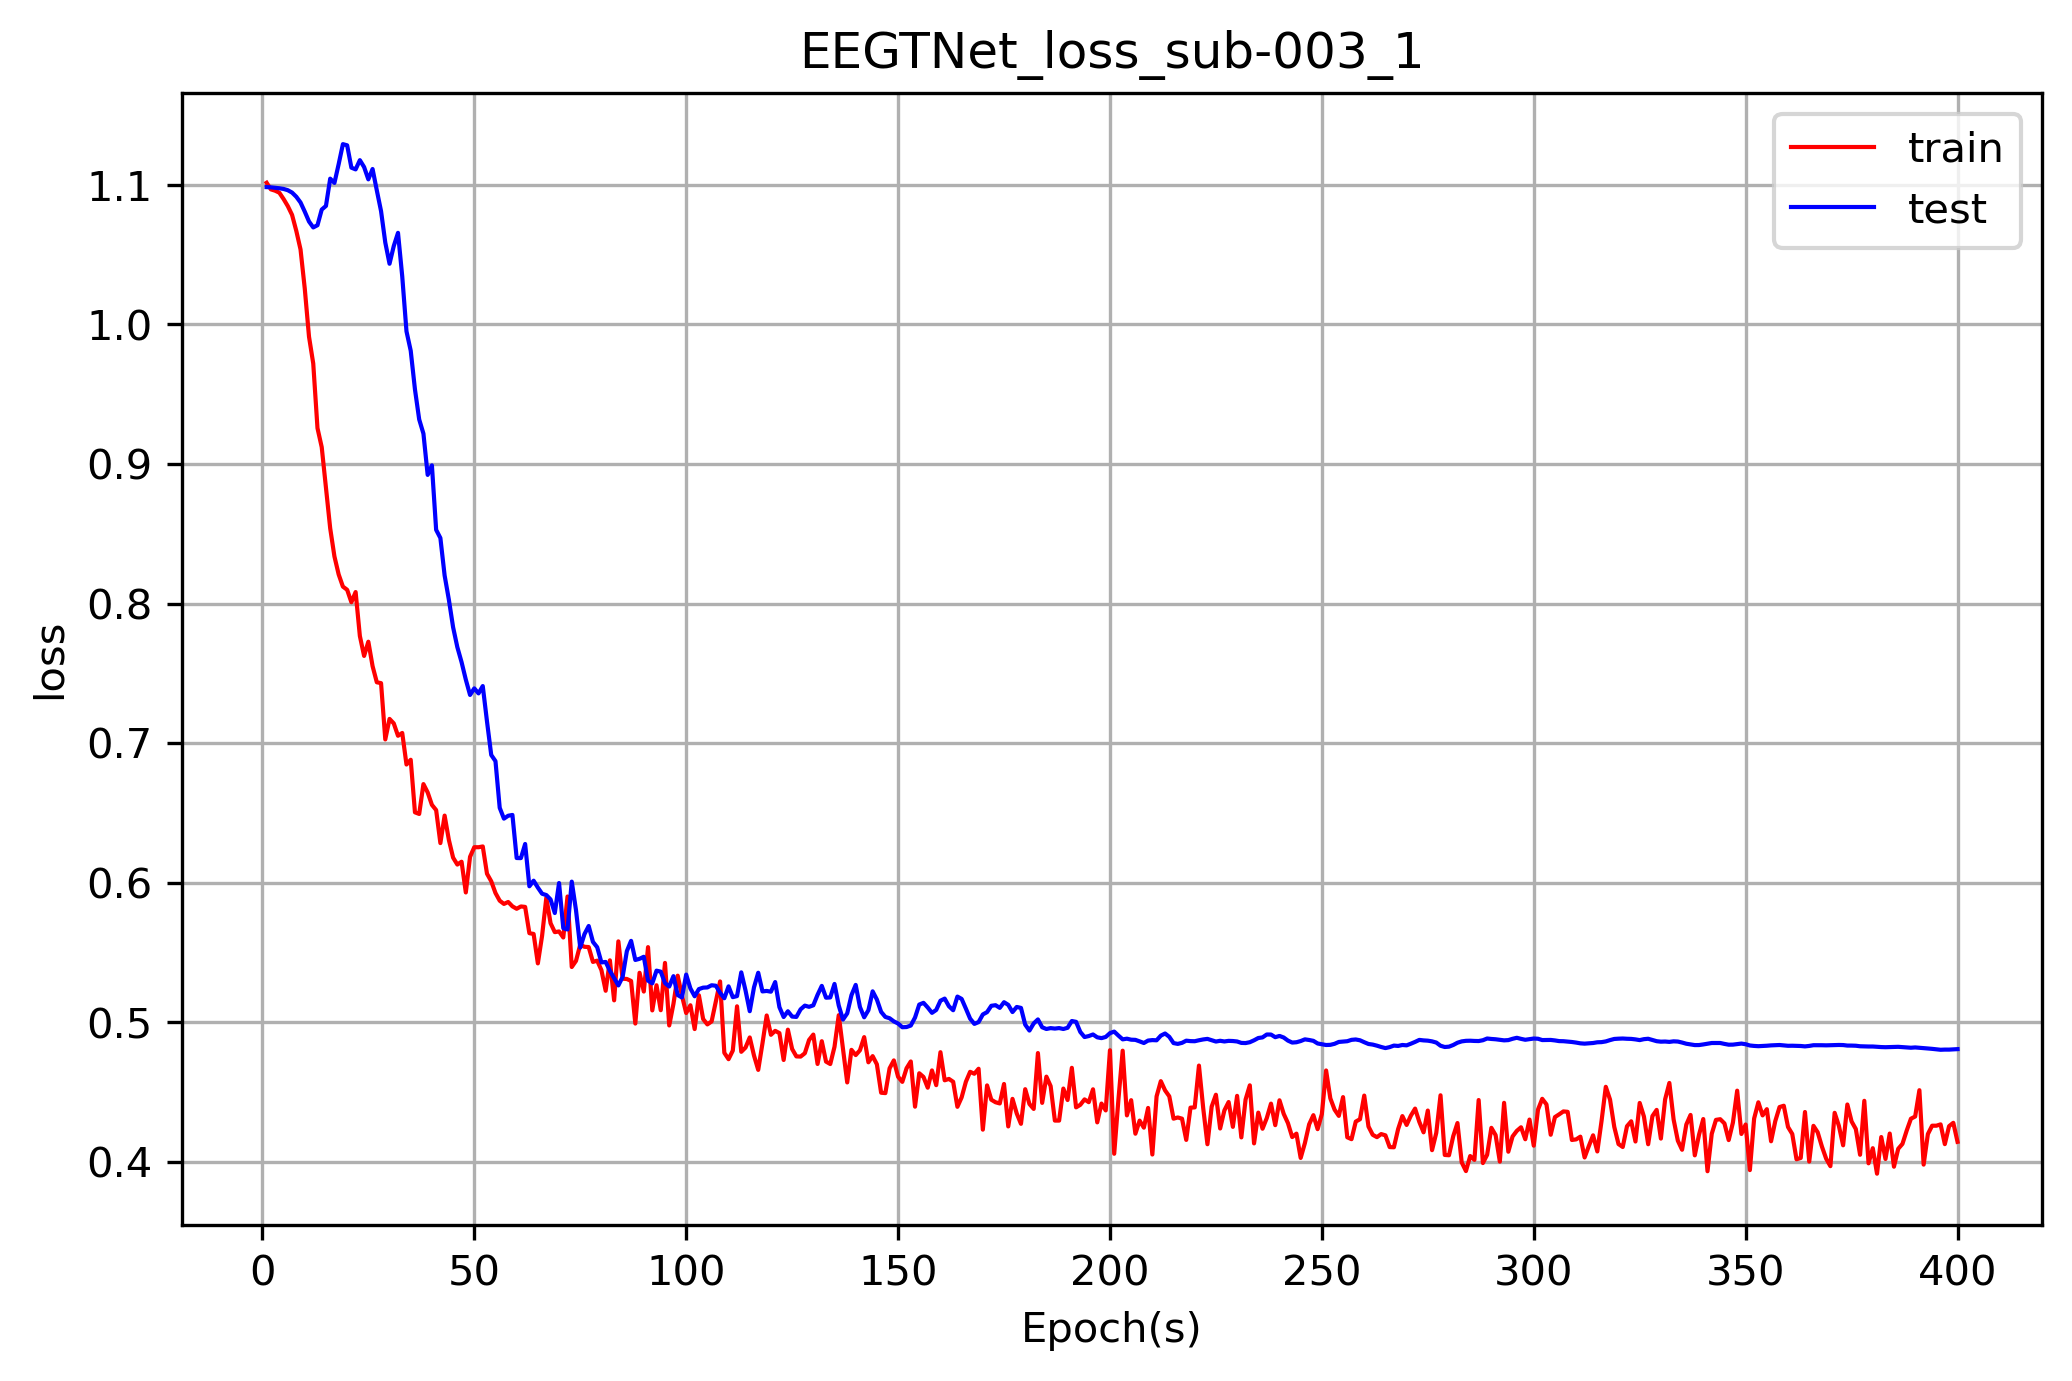

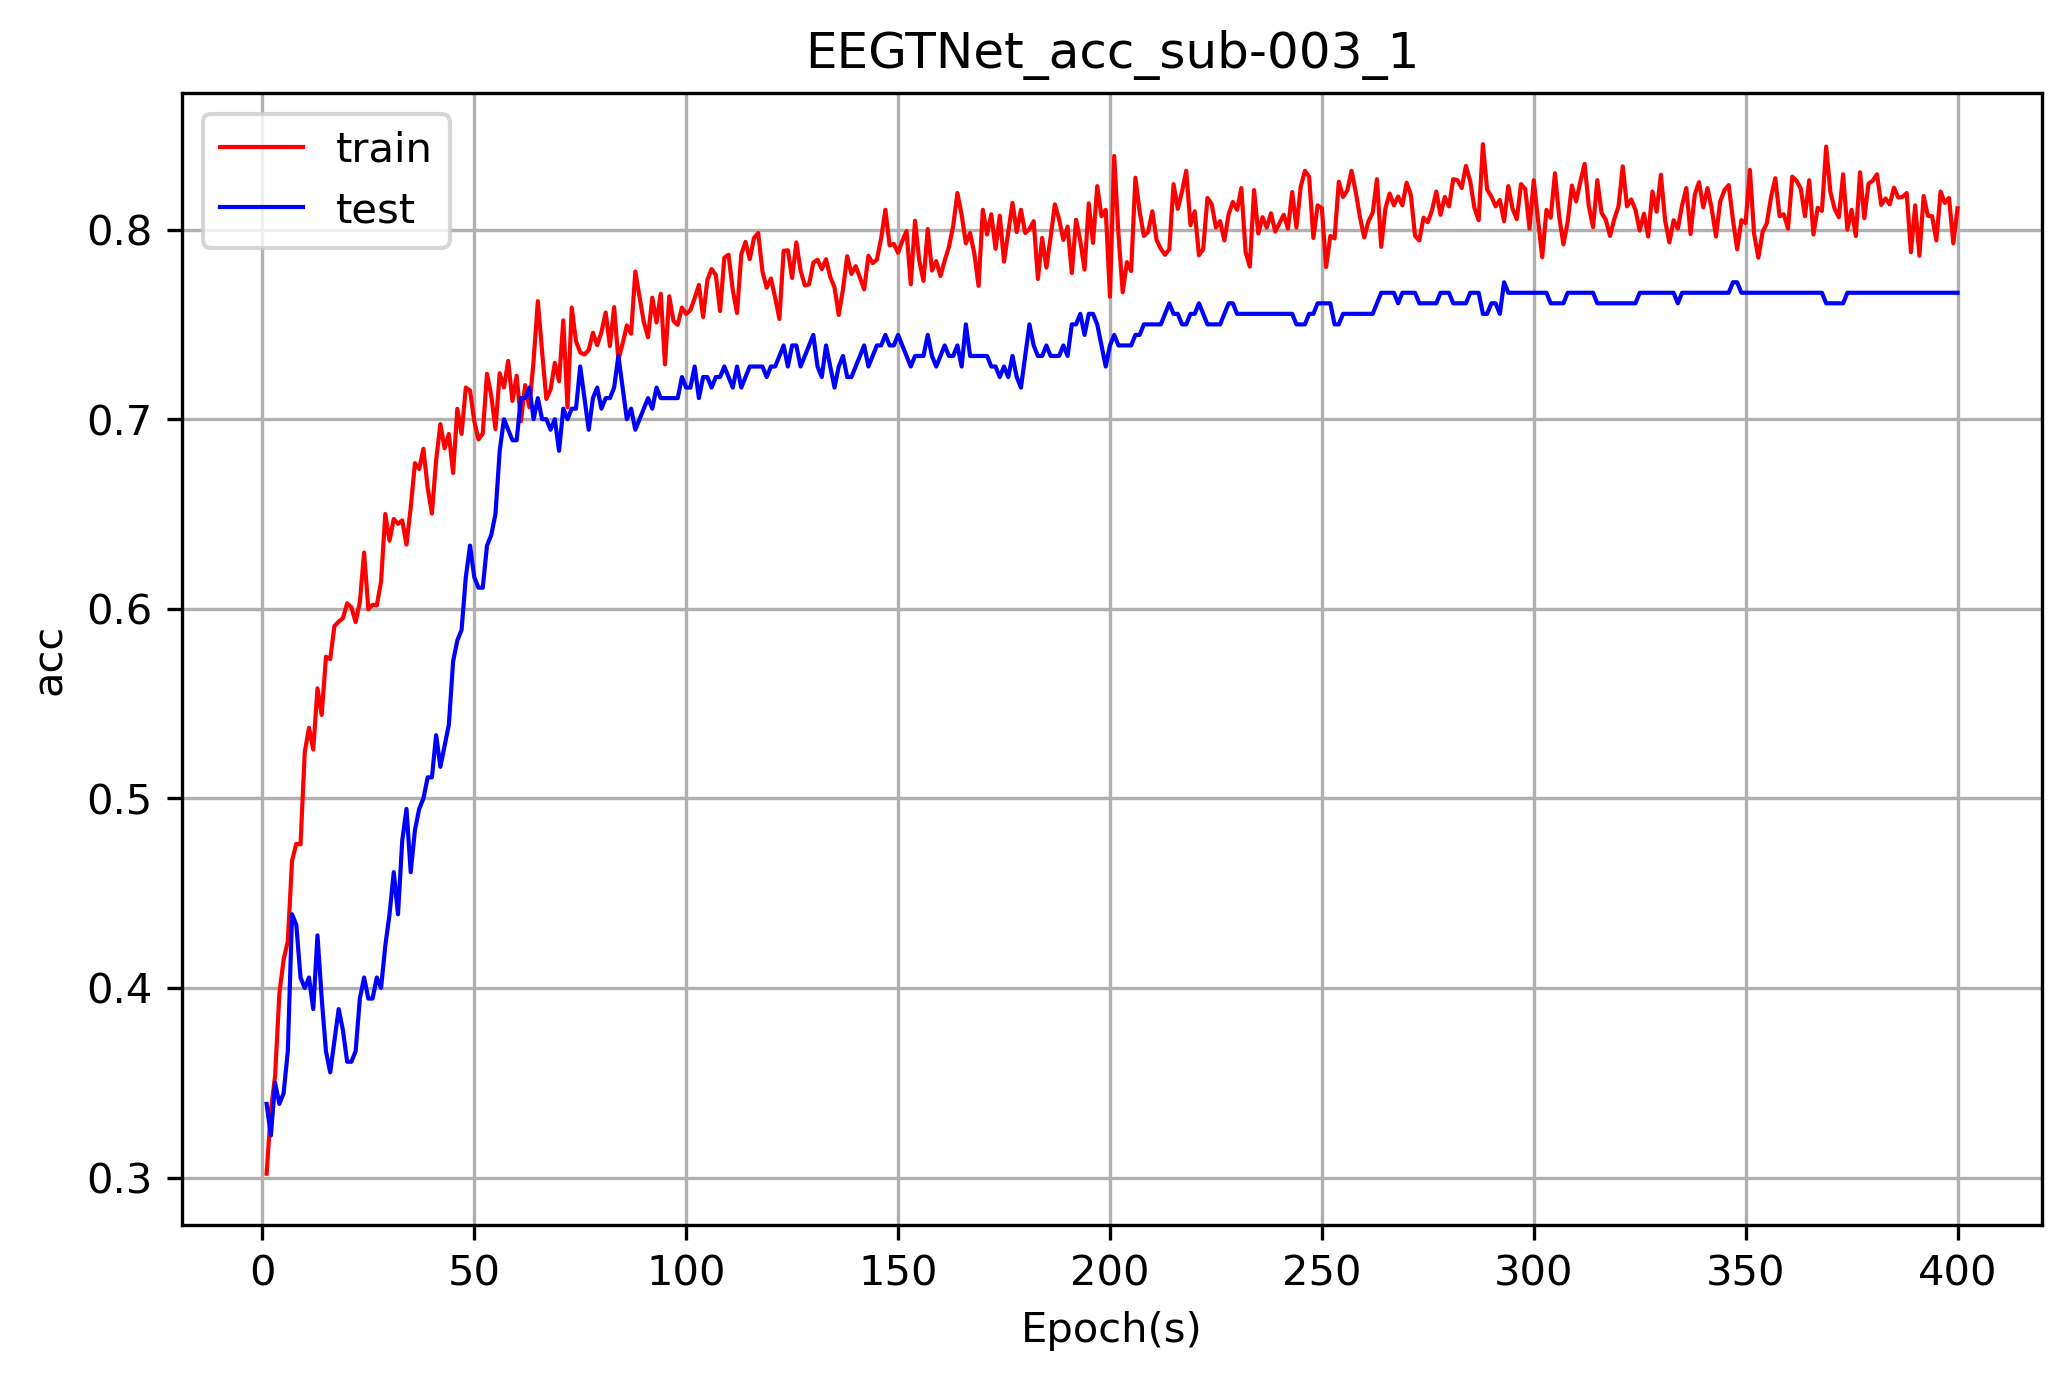

[2021-05-25 19:45:18] [INFO]    current_fold Acc : 0.7666666666666667
[2021-05-25 19:45:19] [INFO]    current_fold: 2 
[2021-05-25 19:45:19] [INFO]    model_path: C:/Users/BCIgroup/Desktop/yqh/Experiment/samelimb/samelimb_EEGTNet_4hp_noresample_e400_b128_1e-3decay/model/sub-003_fold_2_max_model.pt 


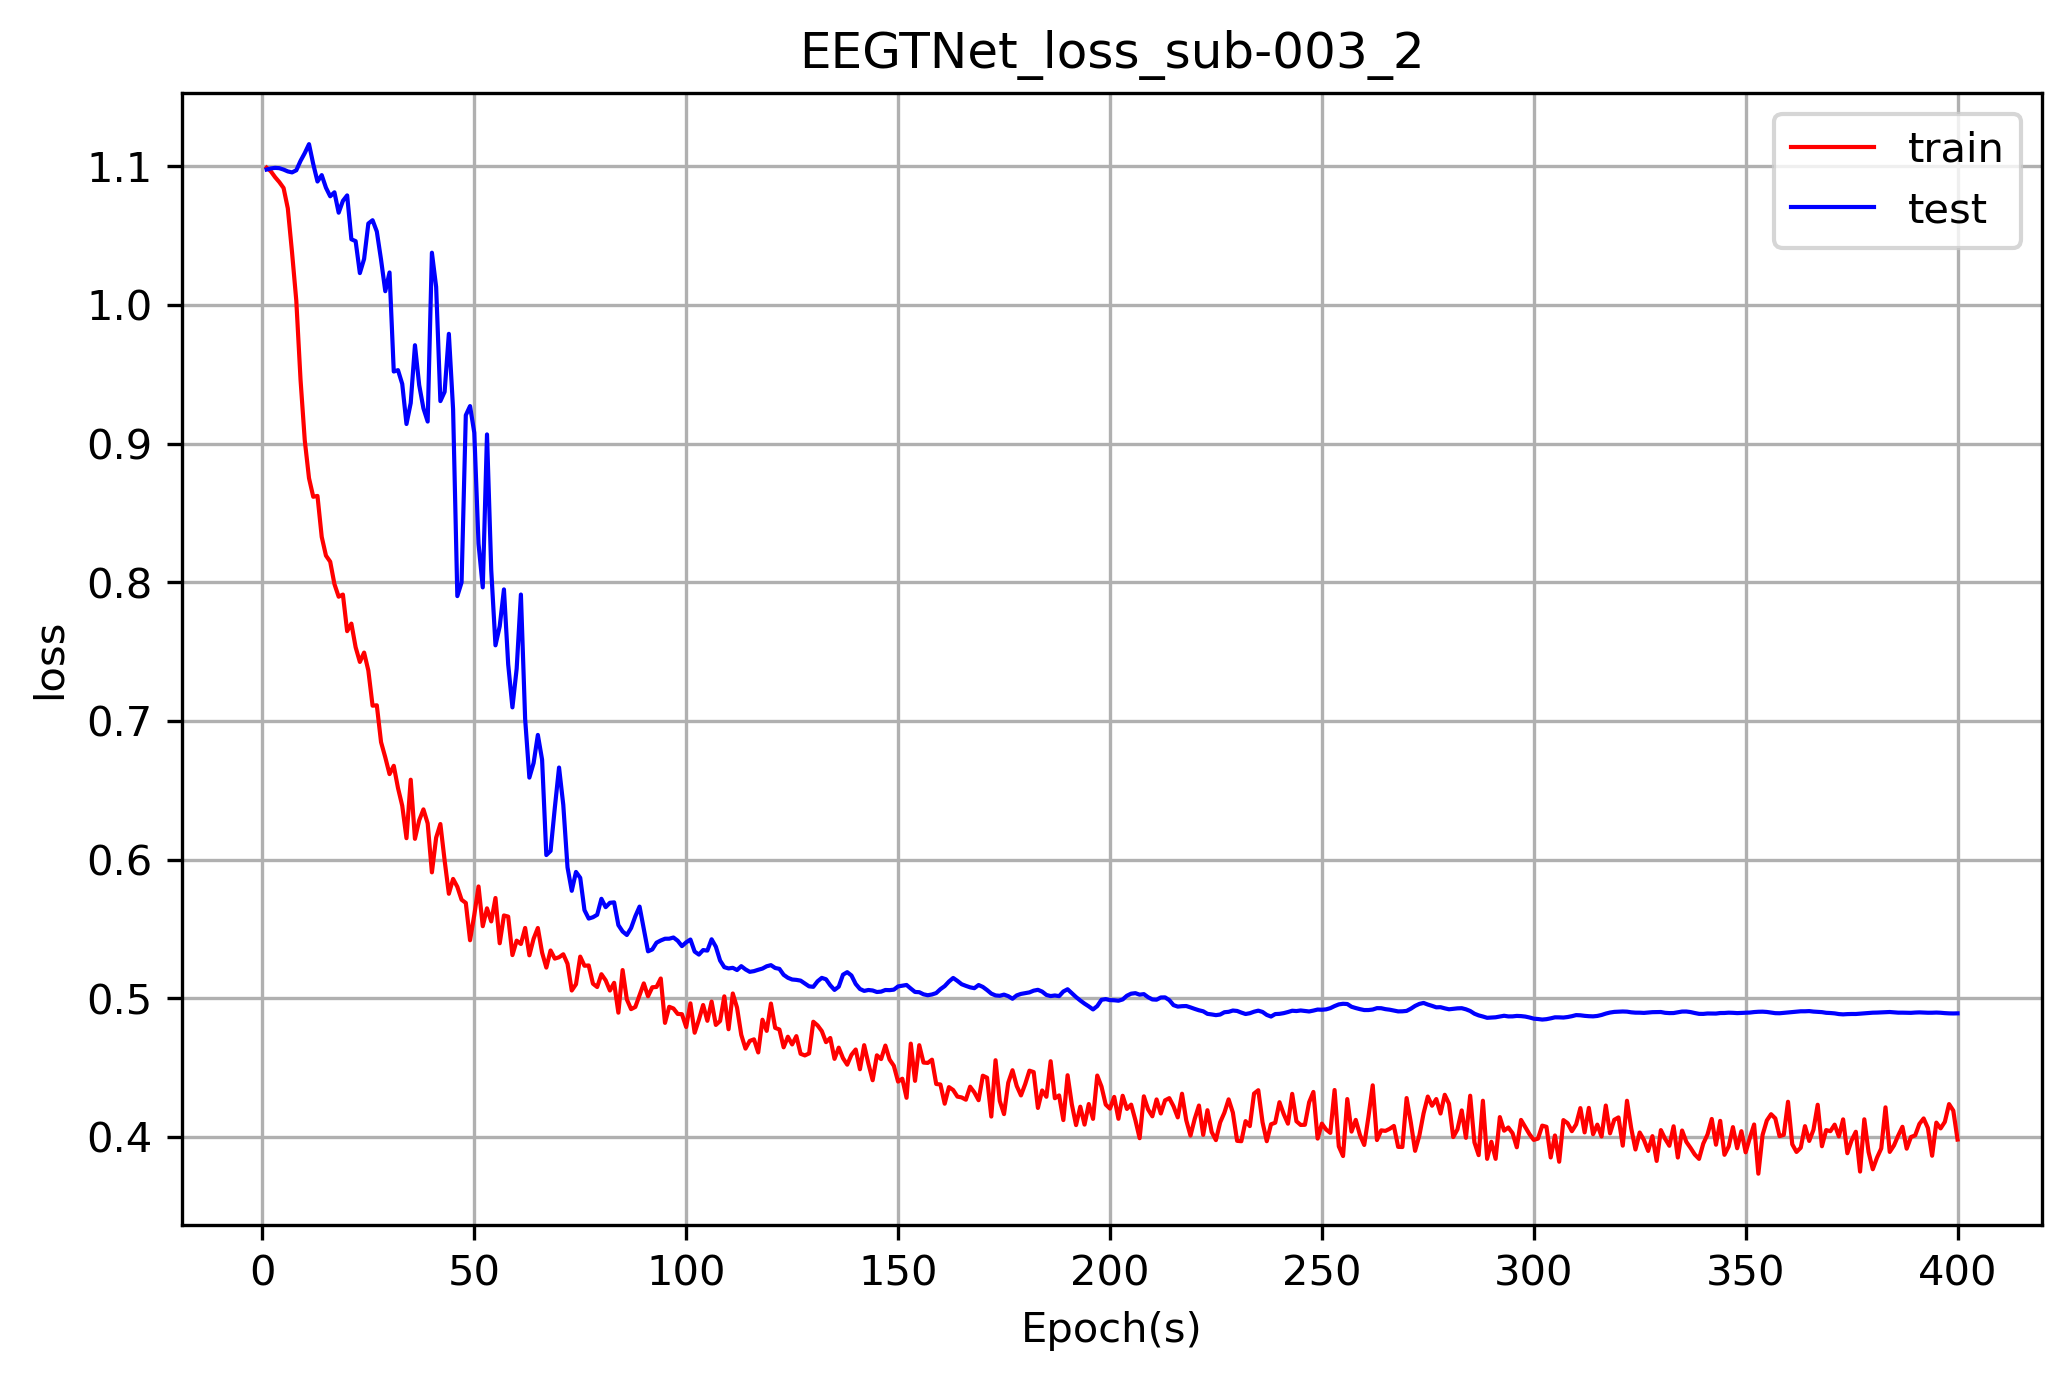

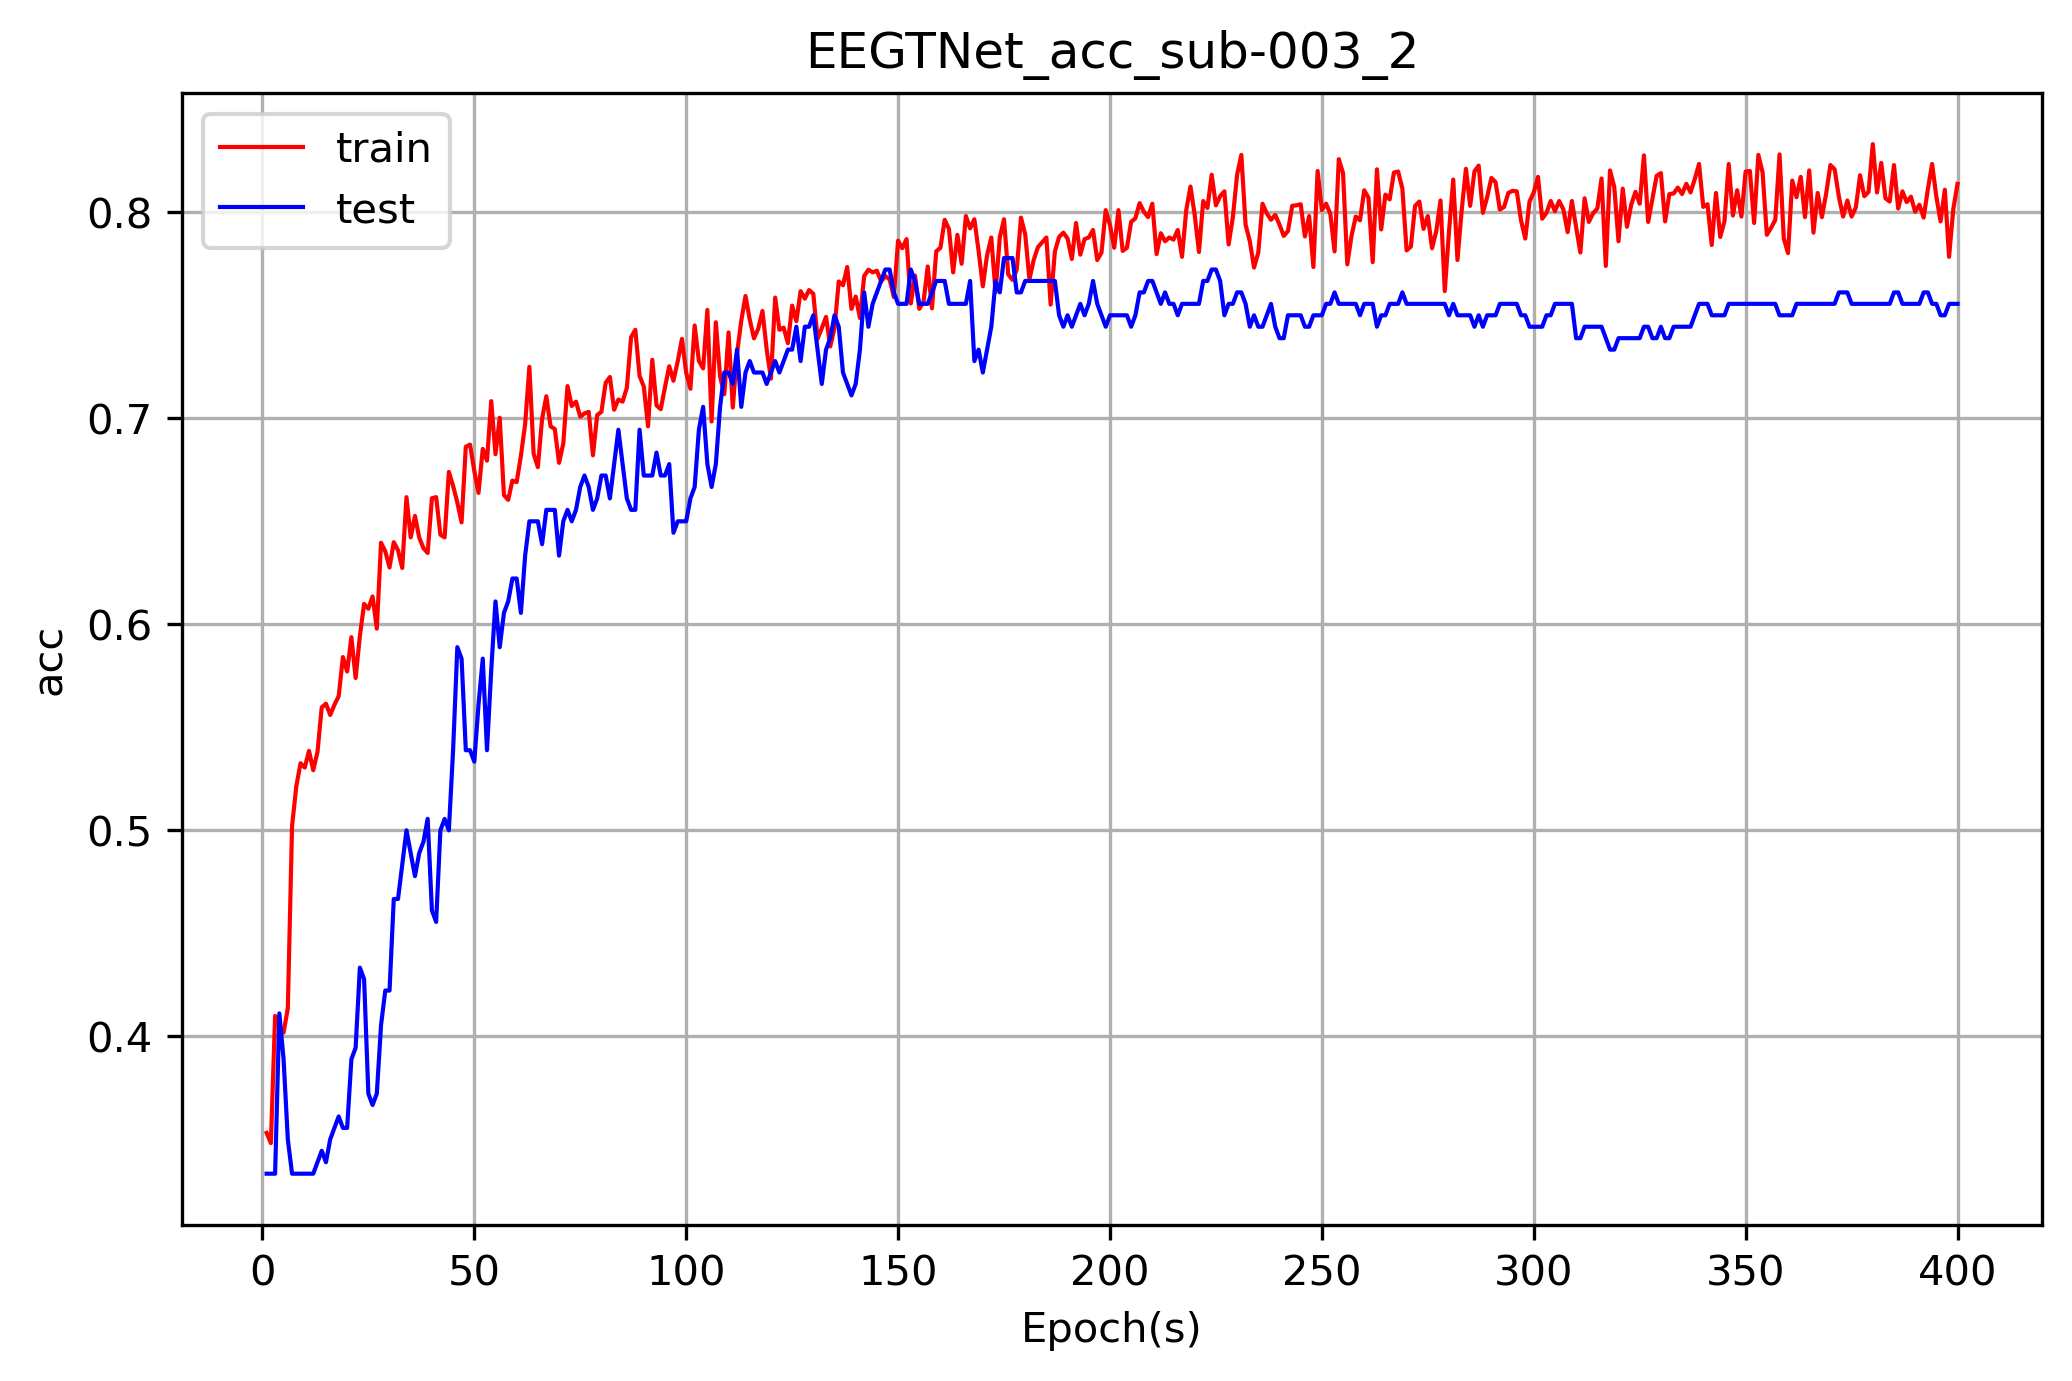

[2021-05-25 20:27:43] [INFO]    current_fold Acc : 0.7555555555555555
[2021-05-25 20:27:44] [INFO]    current_fold: 3 
[2021-05-25 20:27:44] [INFO]    model_path: C:/Users/BCIgroup/Desktop/yqh/Experiment/samelimb/samelimb_EEGTNet_4hp_noresample_e400_b128_1e-3decay/model/sub-003_fold_3_max_model.pt 


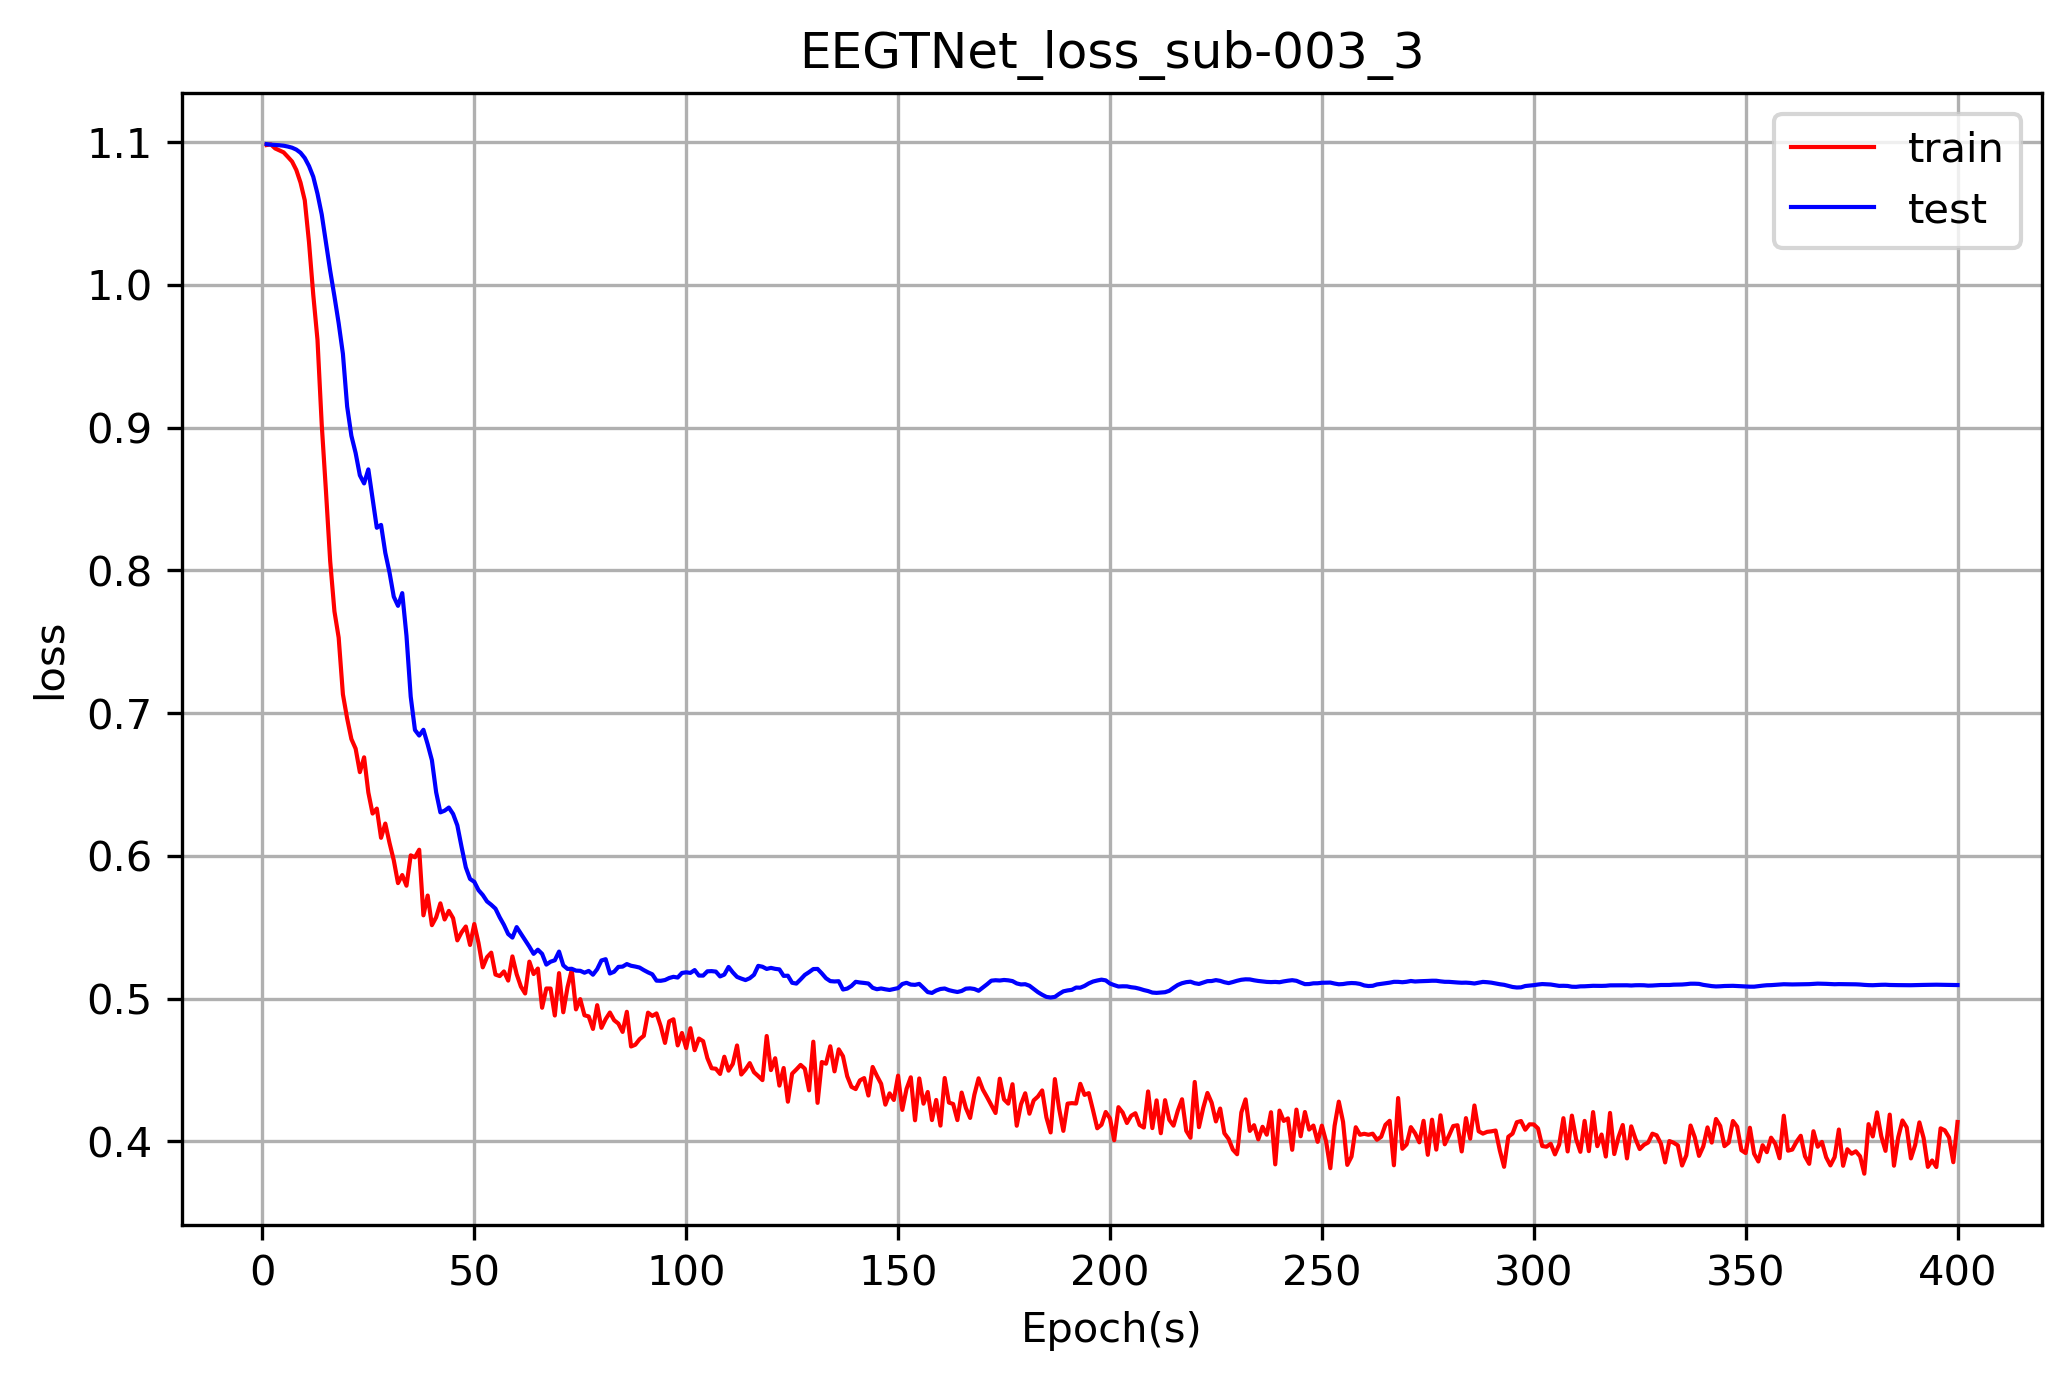

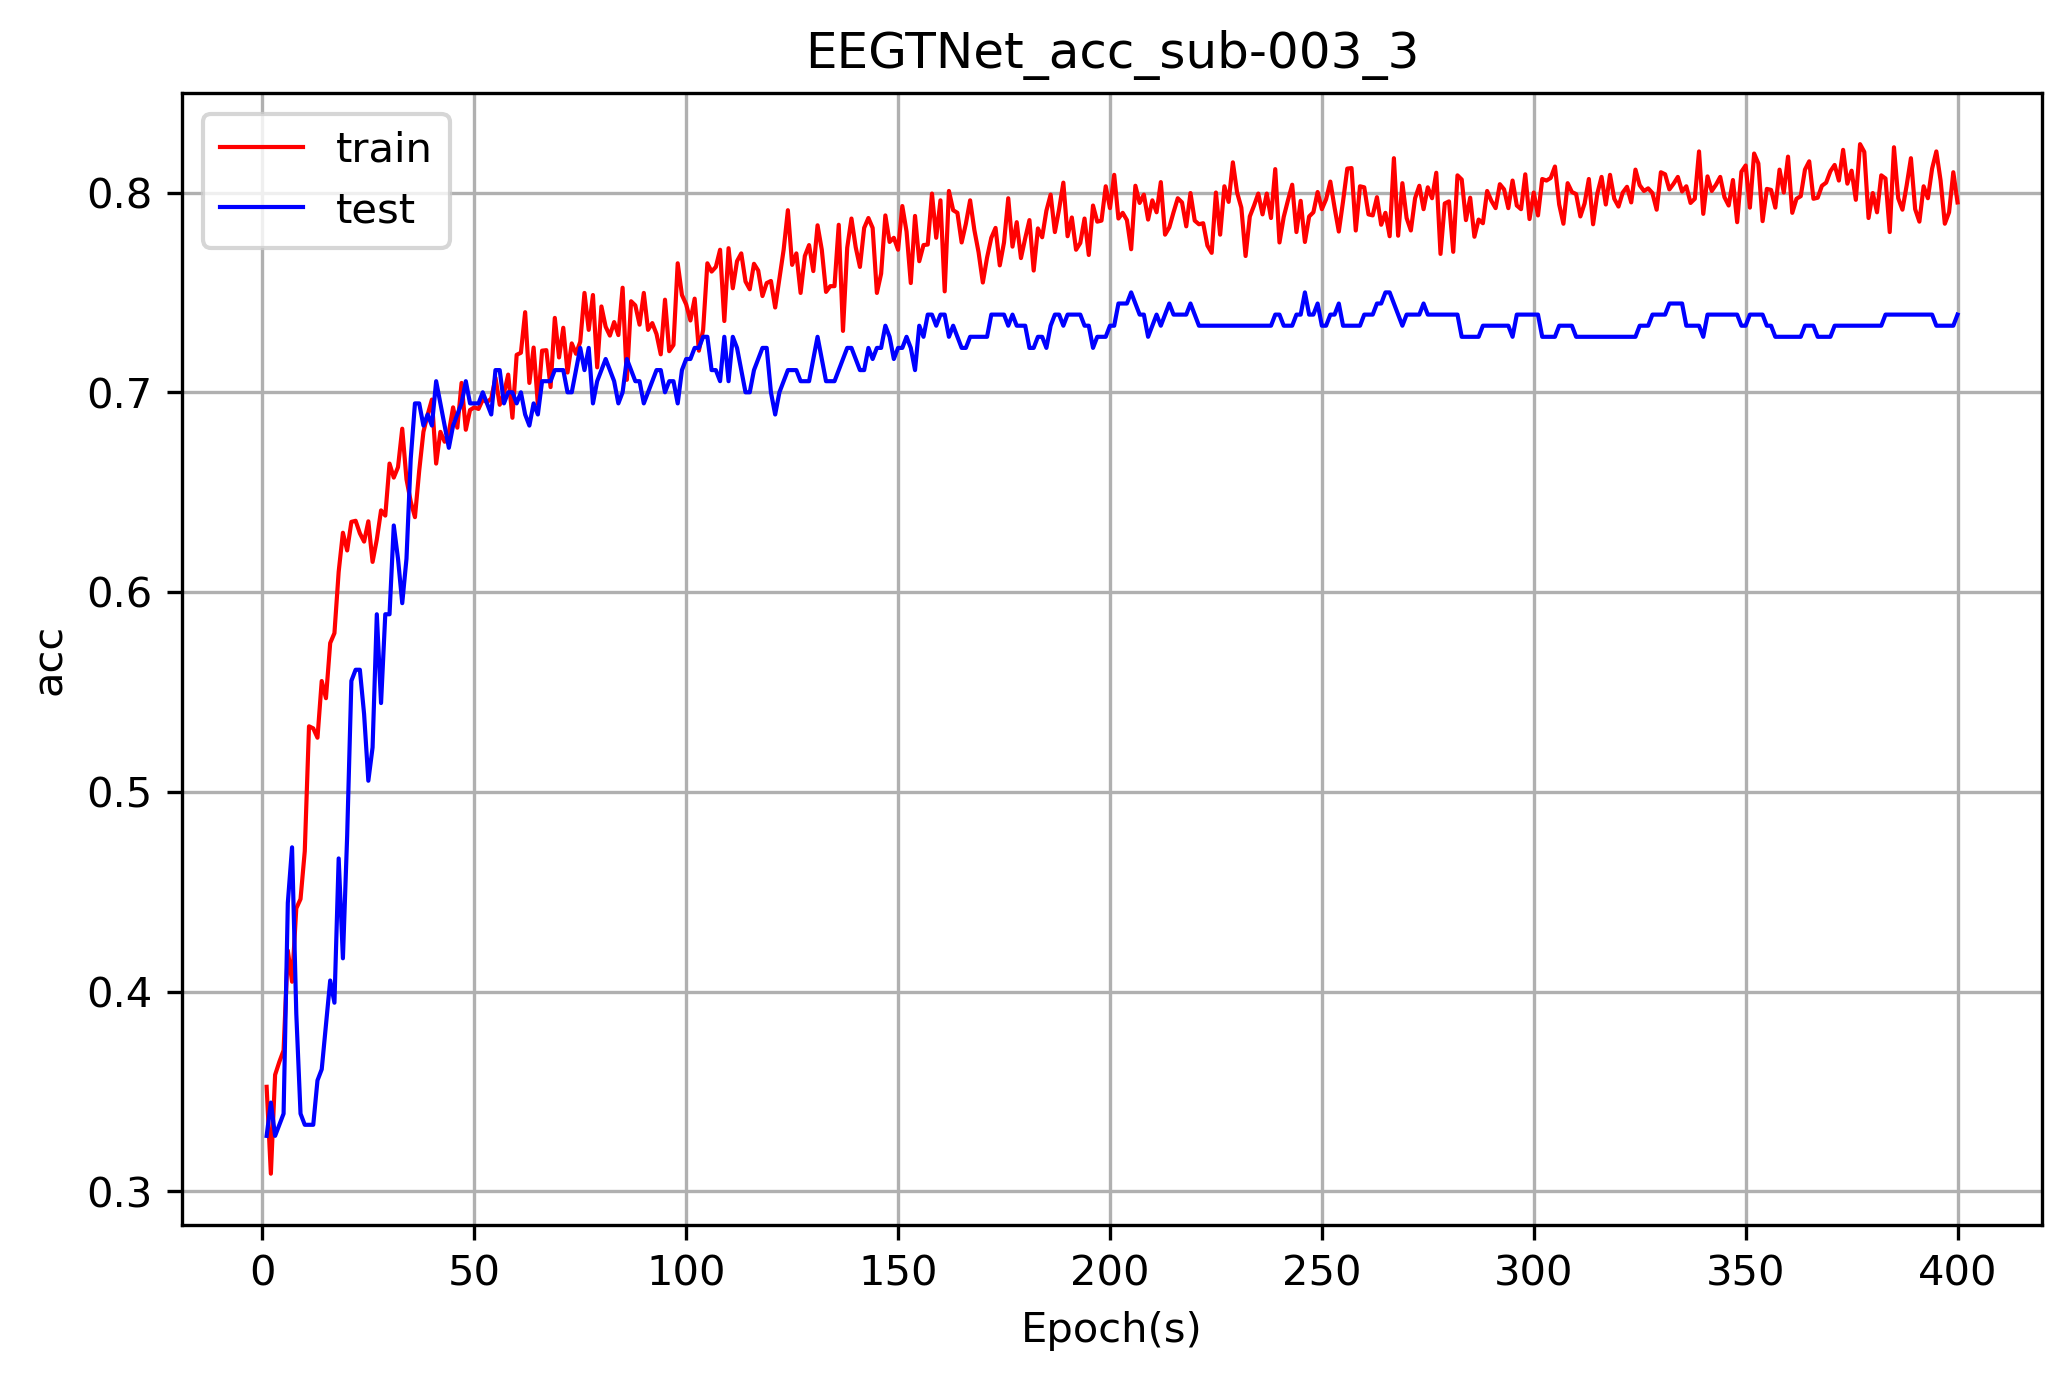

[2021-05-25 20:53:55] [INFO]    current_fold Acc : 0.7388888888888889
[2021-05-25 20:53:56] [INFO]    current_fold: 4 
[2021-05-25 20:53:56] [INFO]    model_path: C:/Users/BCIgroup/Desktop/yqh/Experiment/samelimb/samelimb_EEGTNet_4hp_noresample_e400_b128_1e-3decay/model/sub-003_fold_4_max_model.pt 


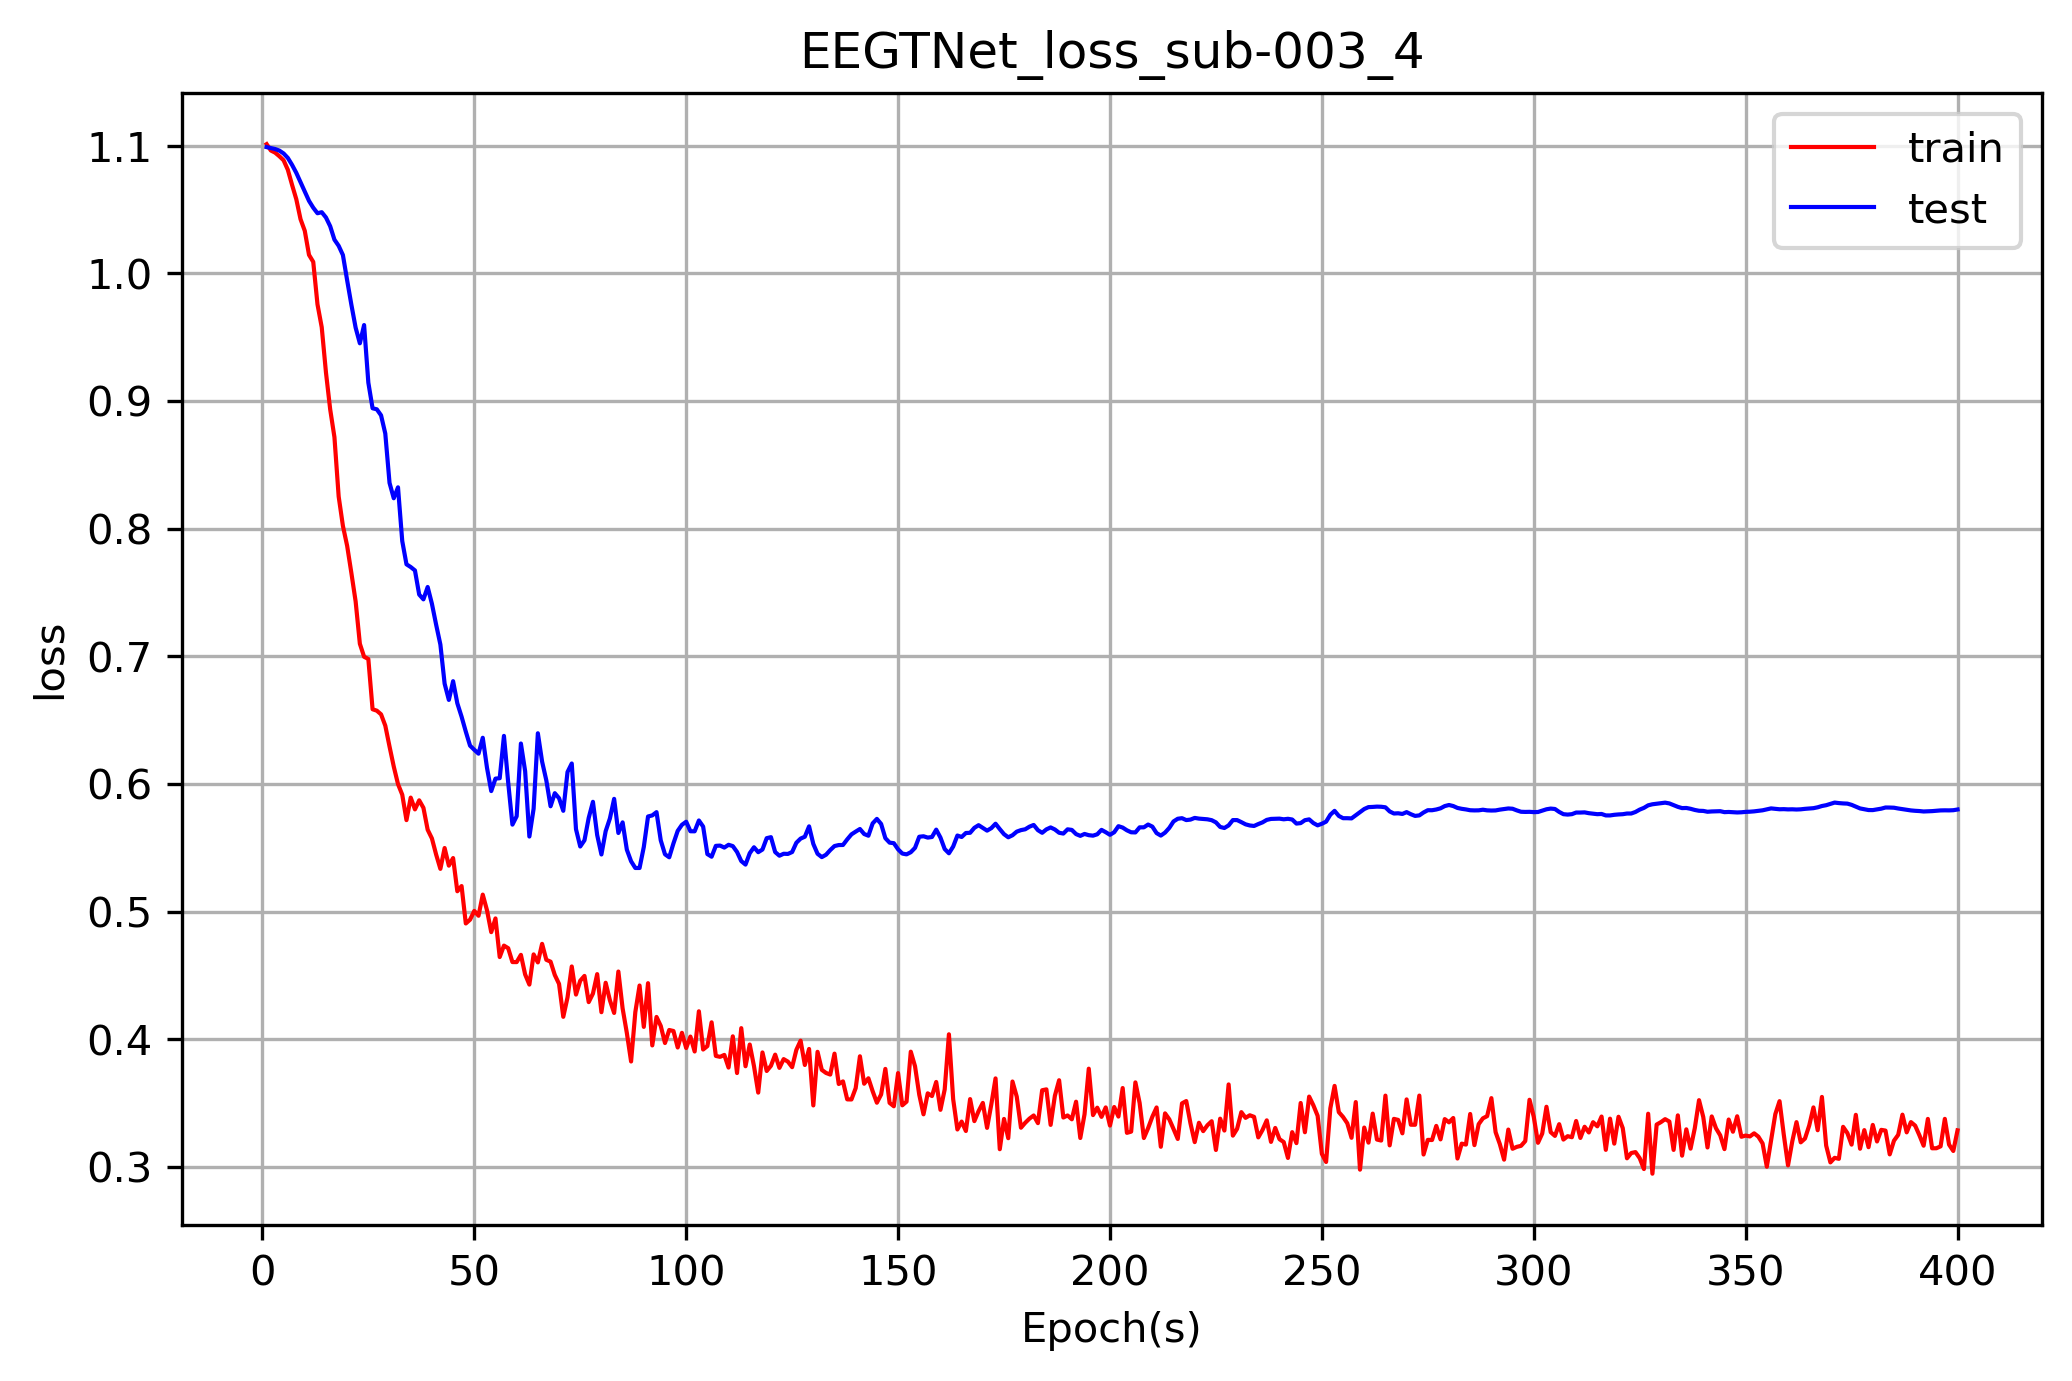

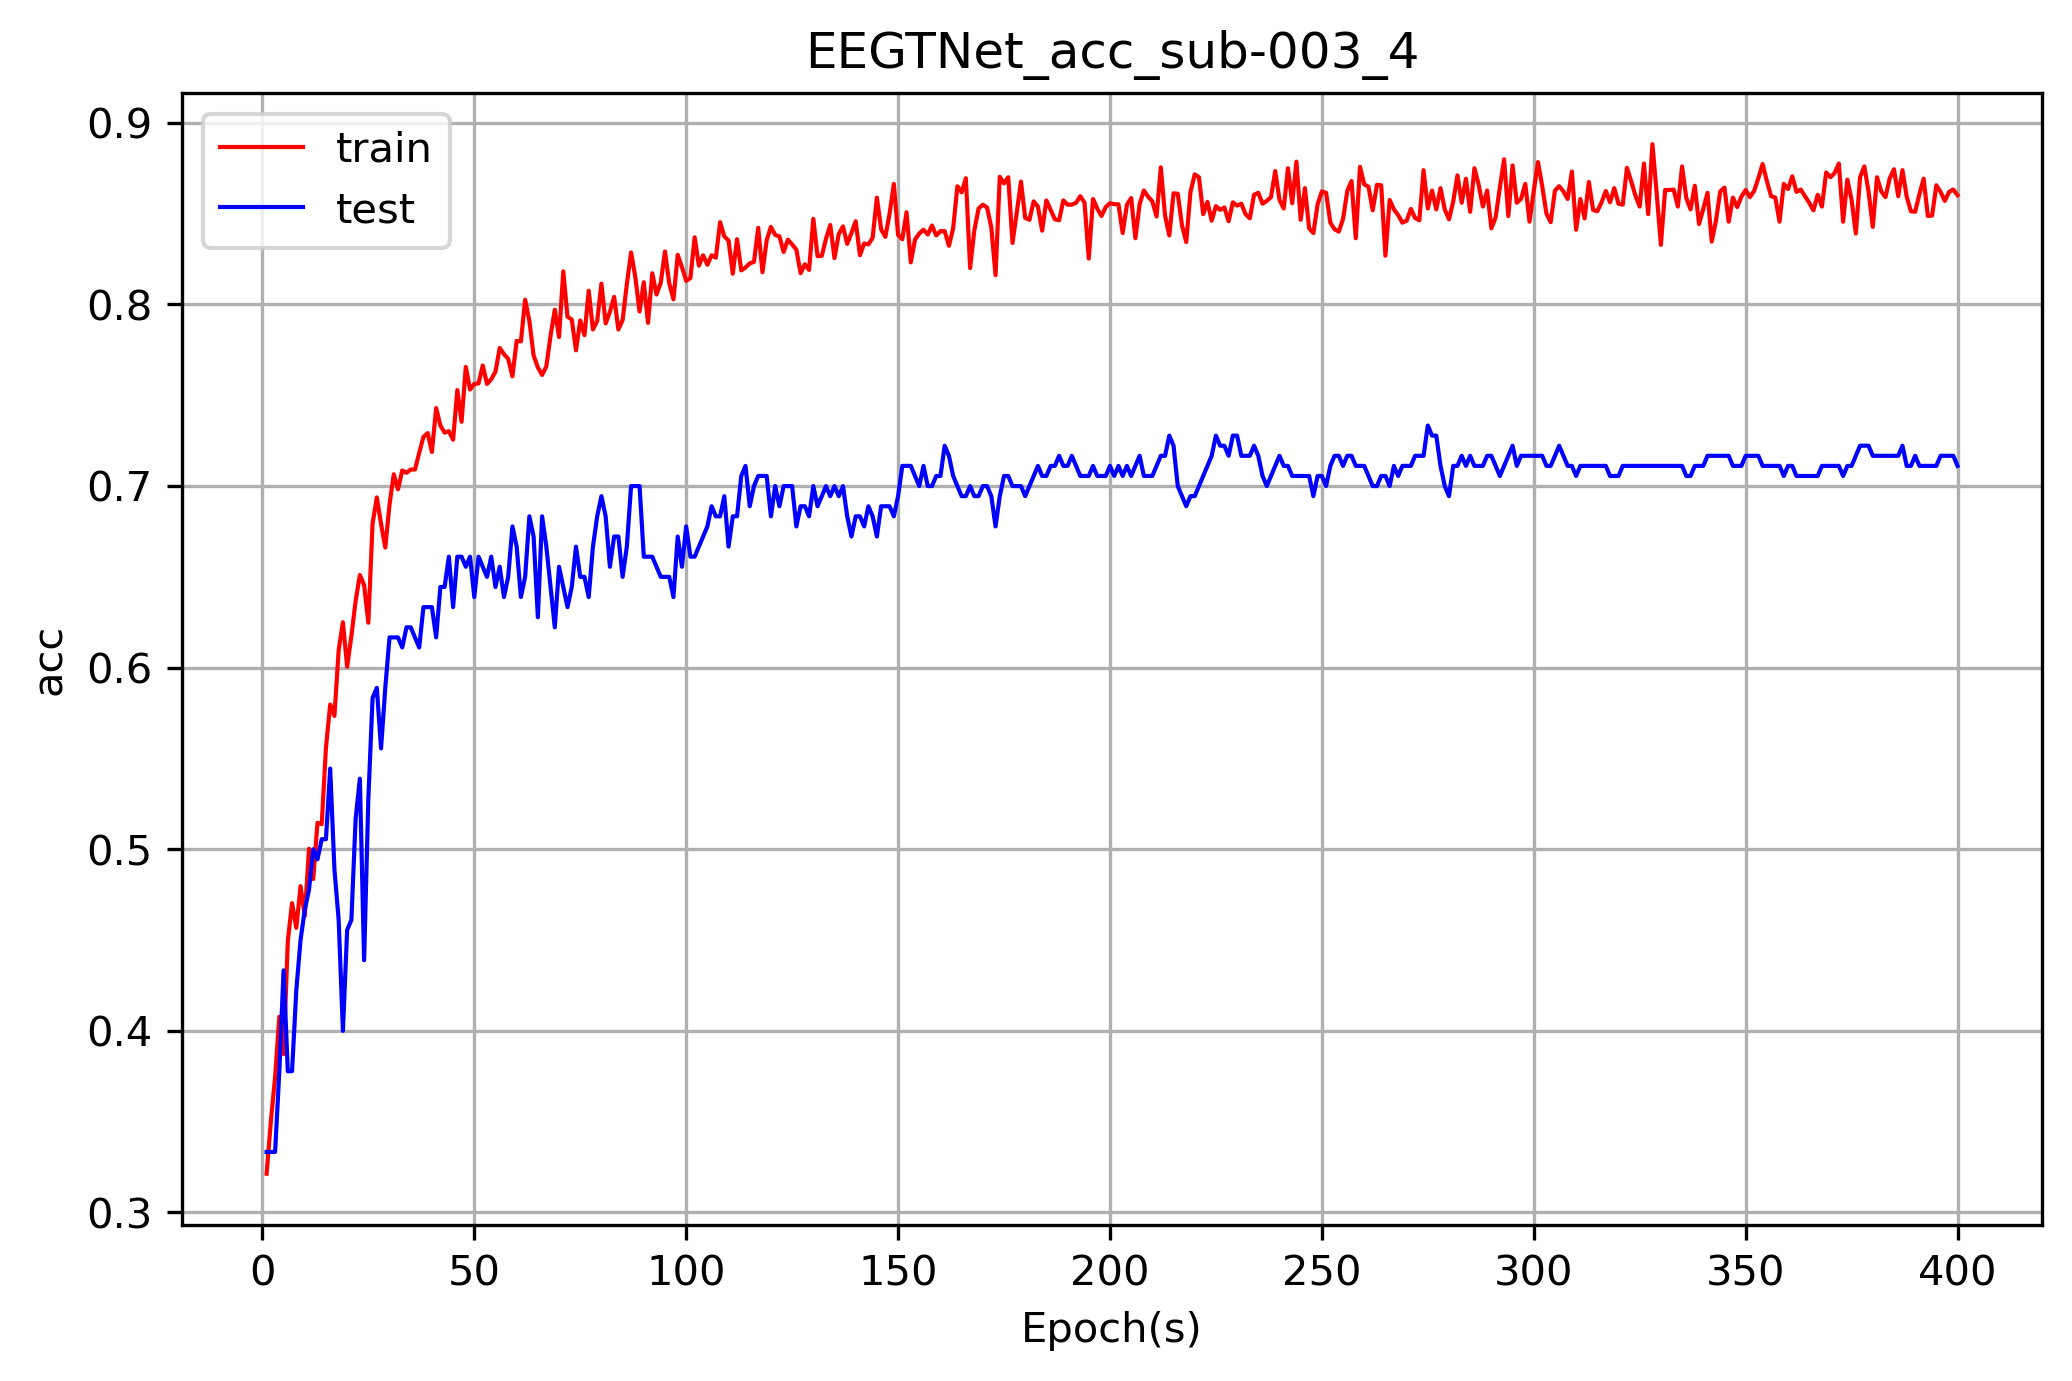

[2021-05-25 21:53:58] [INFO]    current_fold Acc : 0.7111111111111111
[2021-05-25 21:53:59] [INFO]    current_fold: 5 
[2021-05-25 21:53:59] [INFO]    model_path: C:/Users/BCIgroup/Desktop/yqh/Experiment/samelimb/samelimb_EEGTNet_4hp_noresample_e400_b128_1e-3decay/model/sub-003_fold_5_max_model.pt 


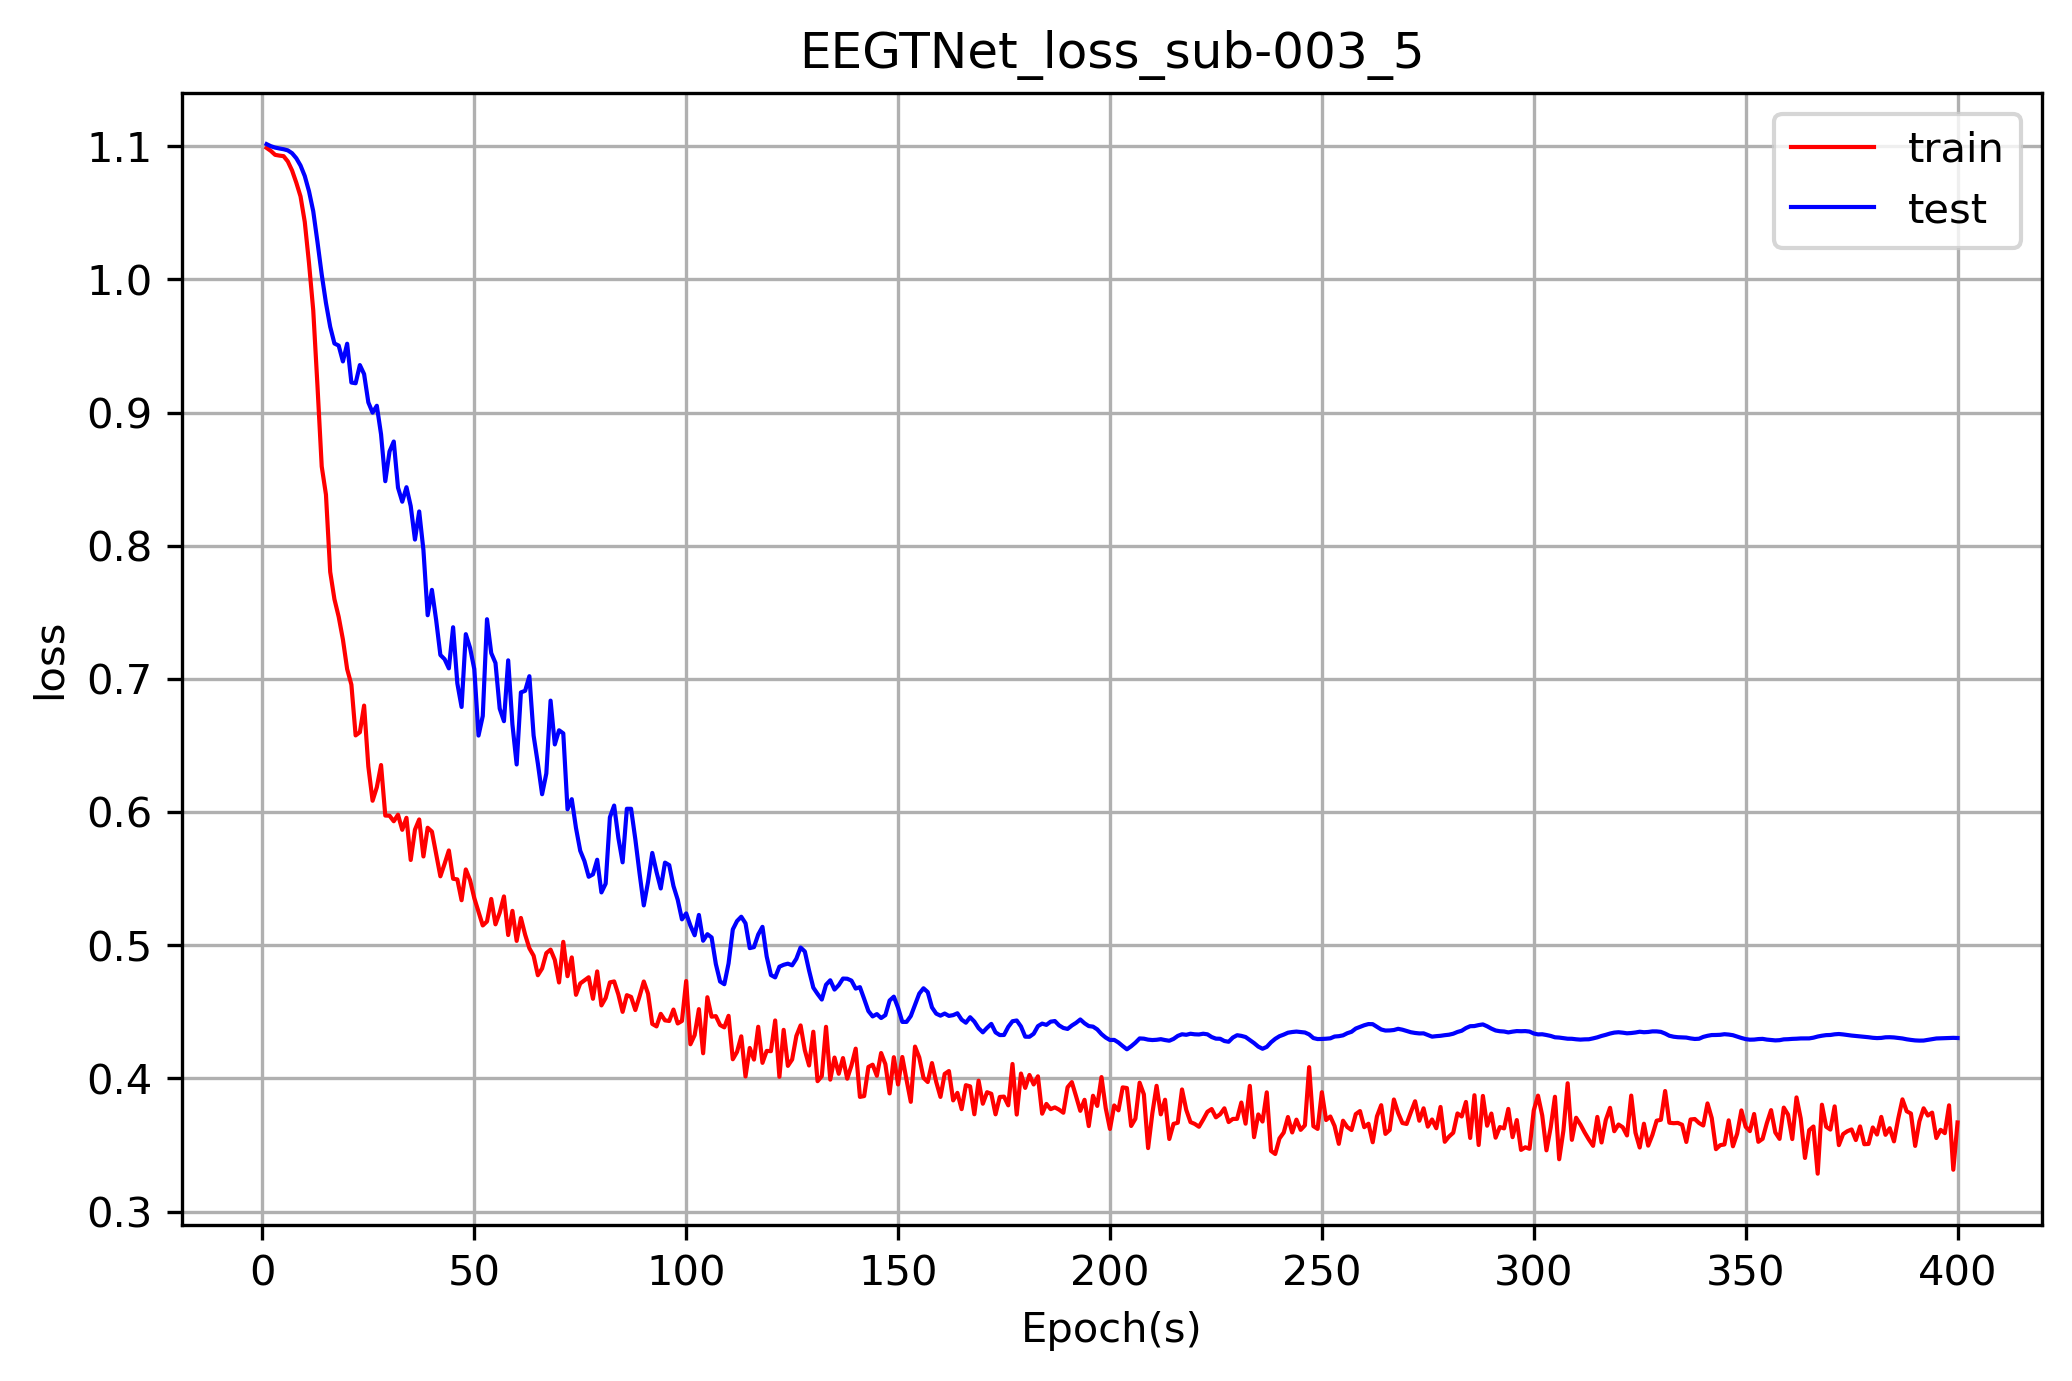

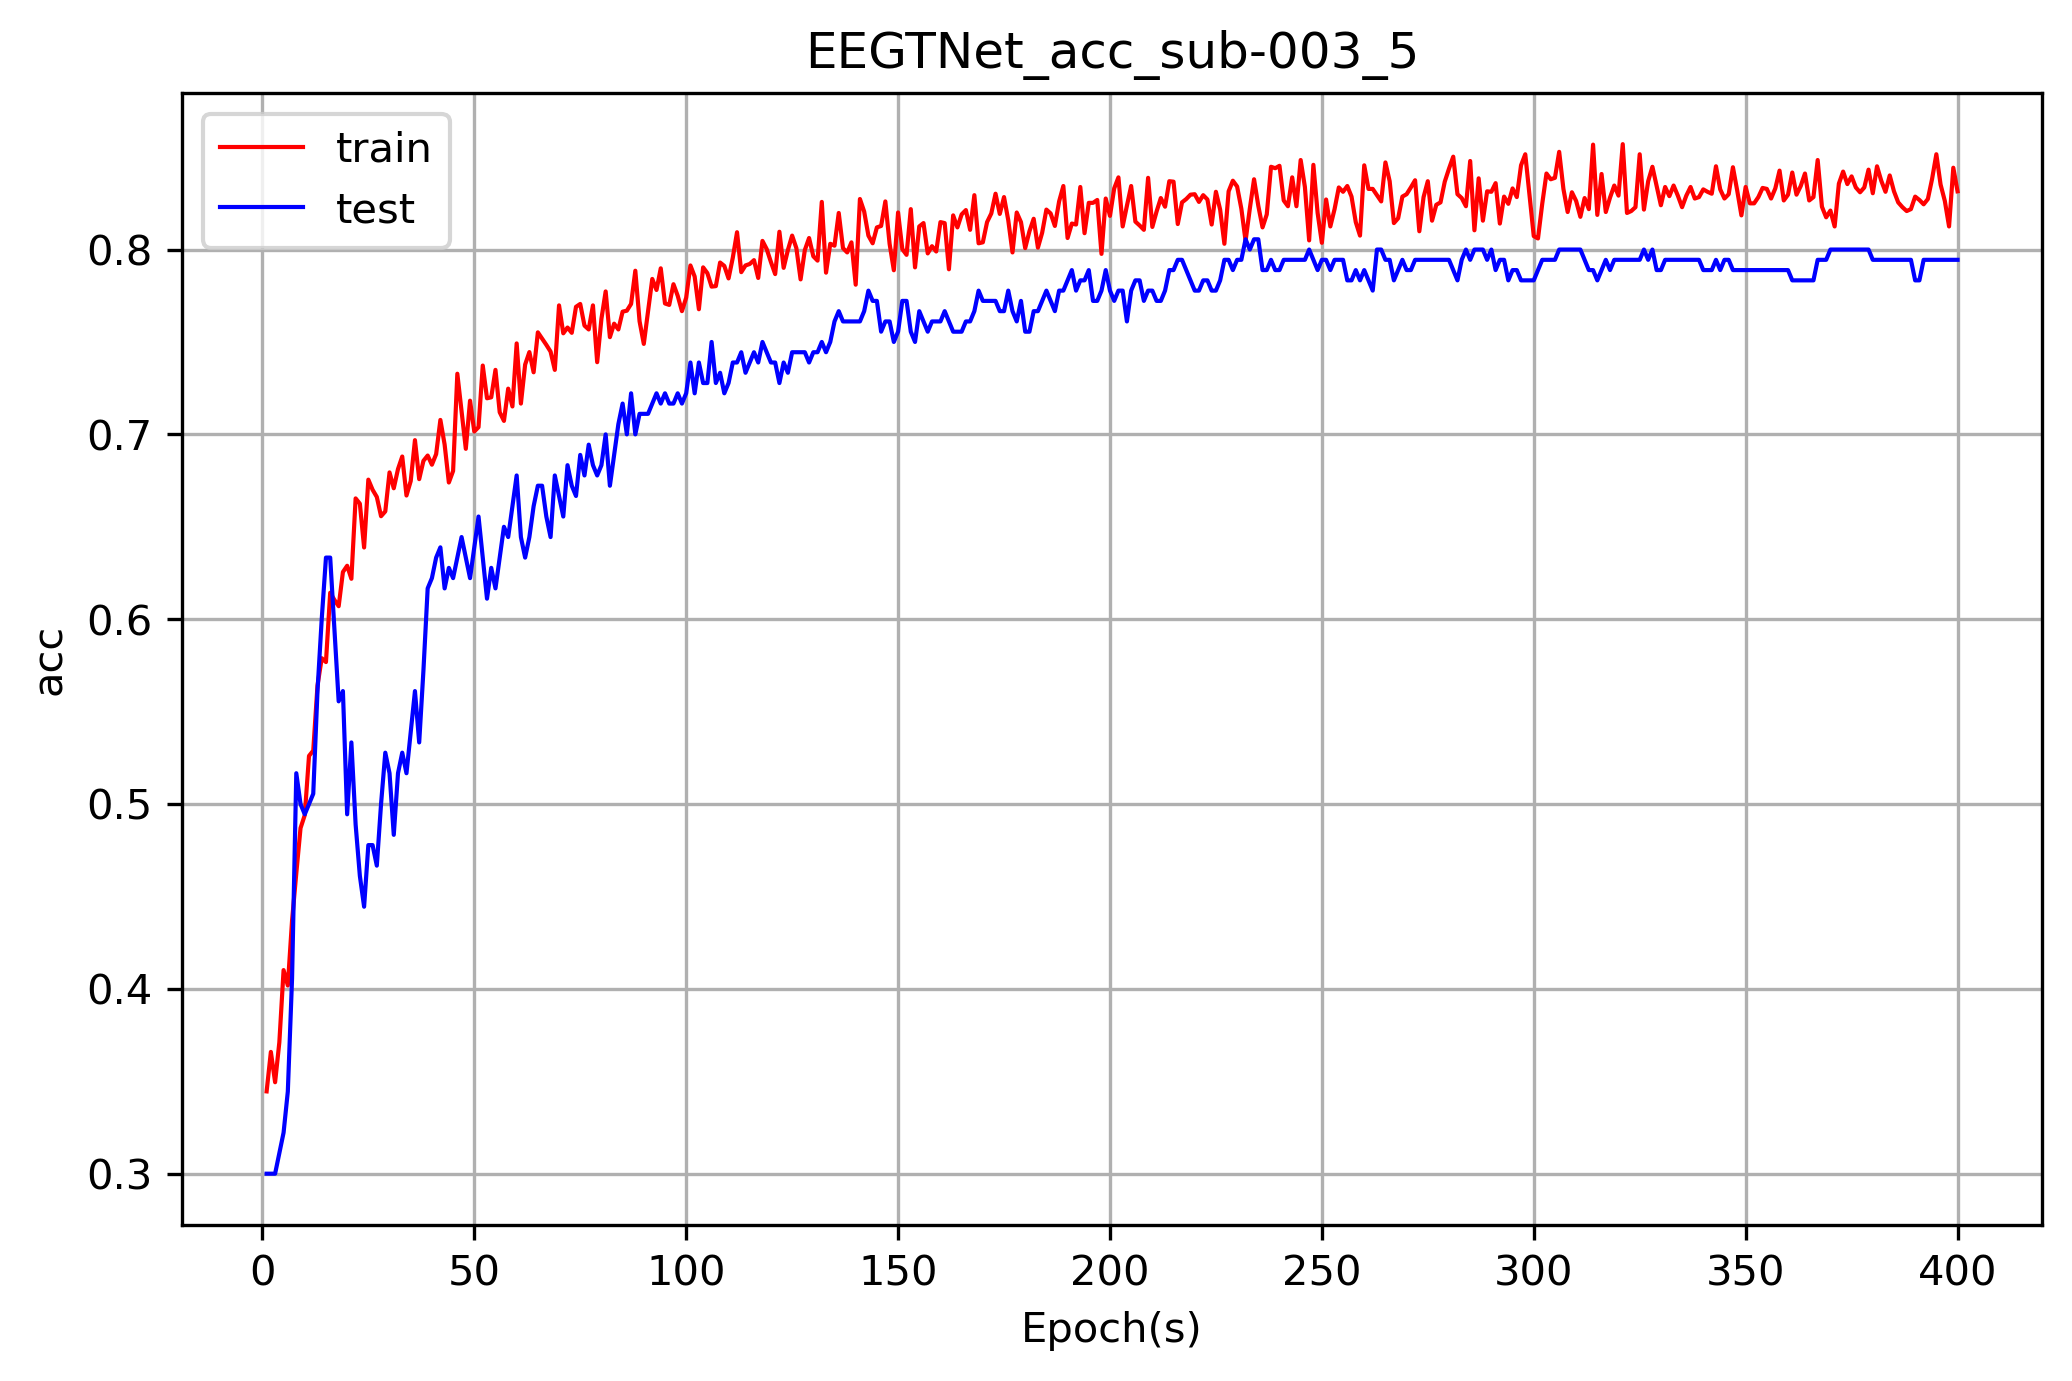

[2021-05-25 23:34:37] [INFO]    current_fold Acc : 0.7944444444444445
[2021-05-25 23:34:37] [INFO]    datapath 	sub-003_task-motorimagery_eeg
[2021-05-25 23:34:37] [INFO]    subject 	sub-003
[2021-05-25 23:34:37] [INFO]    result of KFlodTrain : [0.7666666666666667, 0.7555555555555555, 0.7388888888888889, 0.7111111111111111, 0.7944444444444445]
[2021-05-25 23:34:37] [INFO]    mean of KFlodTrain 	0.7533 
[2021-05-25 23:34:37] [INFO]    std of KFlodTrain 	0.0278 


datapath C:\Users\BCIgroup\Desktop\yqh\data\samelimb\sub-004_task-motorimagery_eeg.mat
load C:\Users\BCIgroup\Desktop\yqh\data\samelimb\sub-004_task-motorimagery_eeg.mat


[2021-05-25 23:34:42] [INFO]    image_path: C:/Users/BCIgroup/Desktop/yqh/Experiment/samelimb/samelimb_EEGTNet_4hp_noresample_e400_b128_1e-3decay/image/ 
[2021-05-25 23:34:42] [INFO]    logpath: C:/Users/BCIgroup/Desktop/yqh/Experiment/samelimb/samelimb_EEGTNet_4hp_noresample_e400_b128_1e-3decay/log/samelimb_EEGTNet_4hp_noresample_e400_b128_1e-3decay.log 
[2021-05-25 23:34:43] [INFO]    current_fold: 1 
[2021-05-25 23:34:43] [INFO]    model_path: C:/Users/BCIgroup/Desktop/yqh/Experiment/samelimb/samelimb_EEGTNet_4hp_noresample_e400_b128_1e-3decay/model/sub-004_fold_1_max_model.pt 


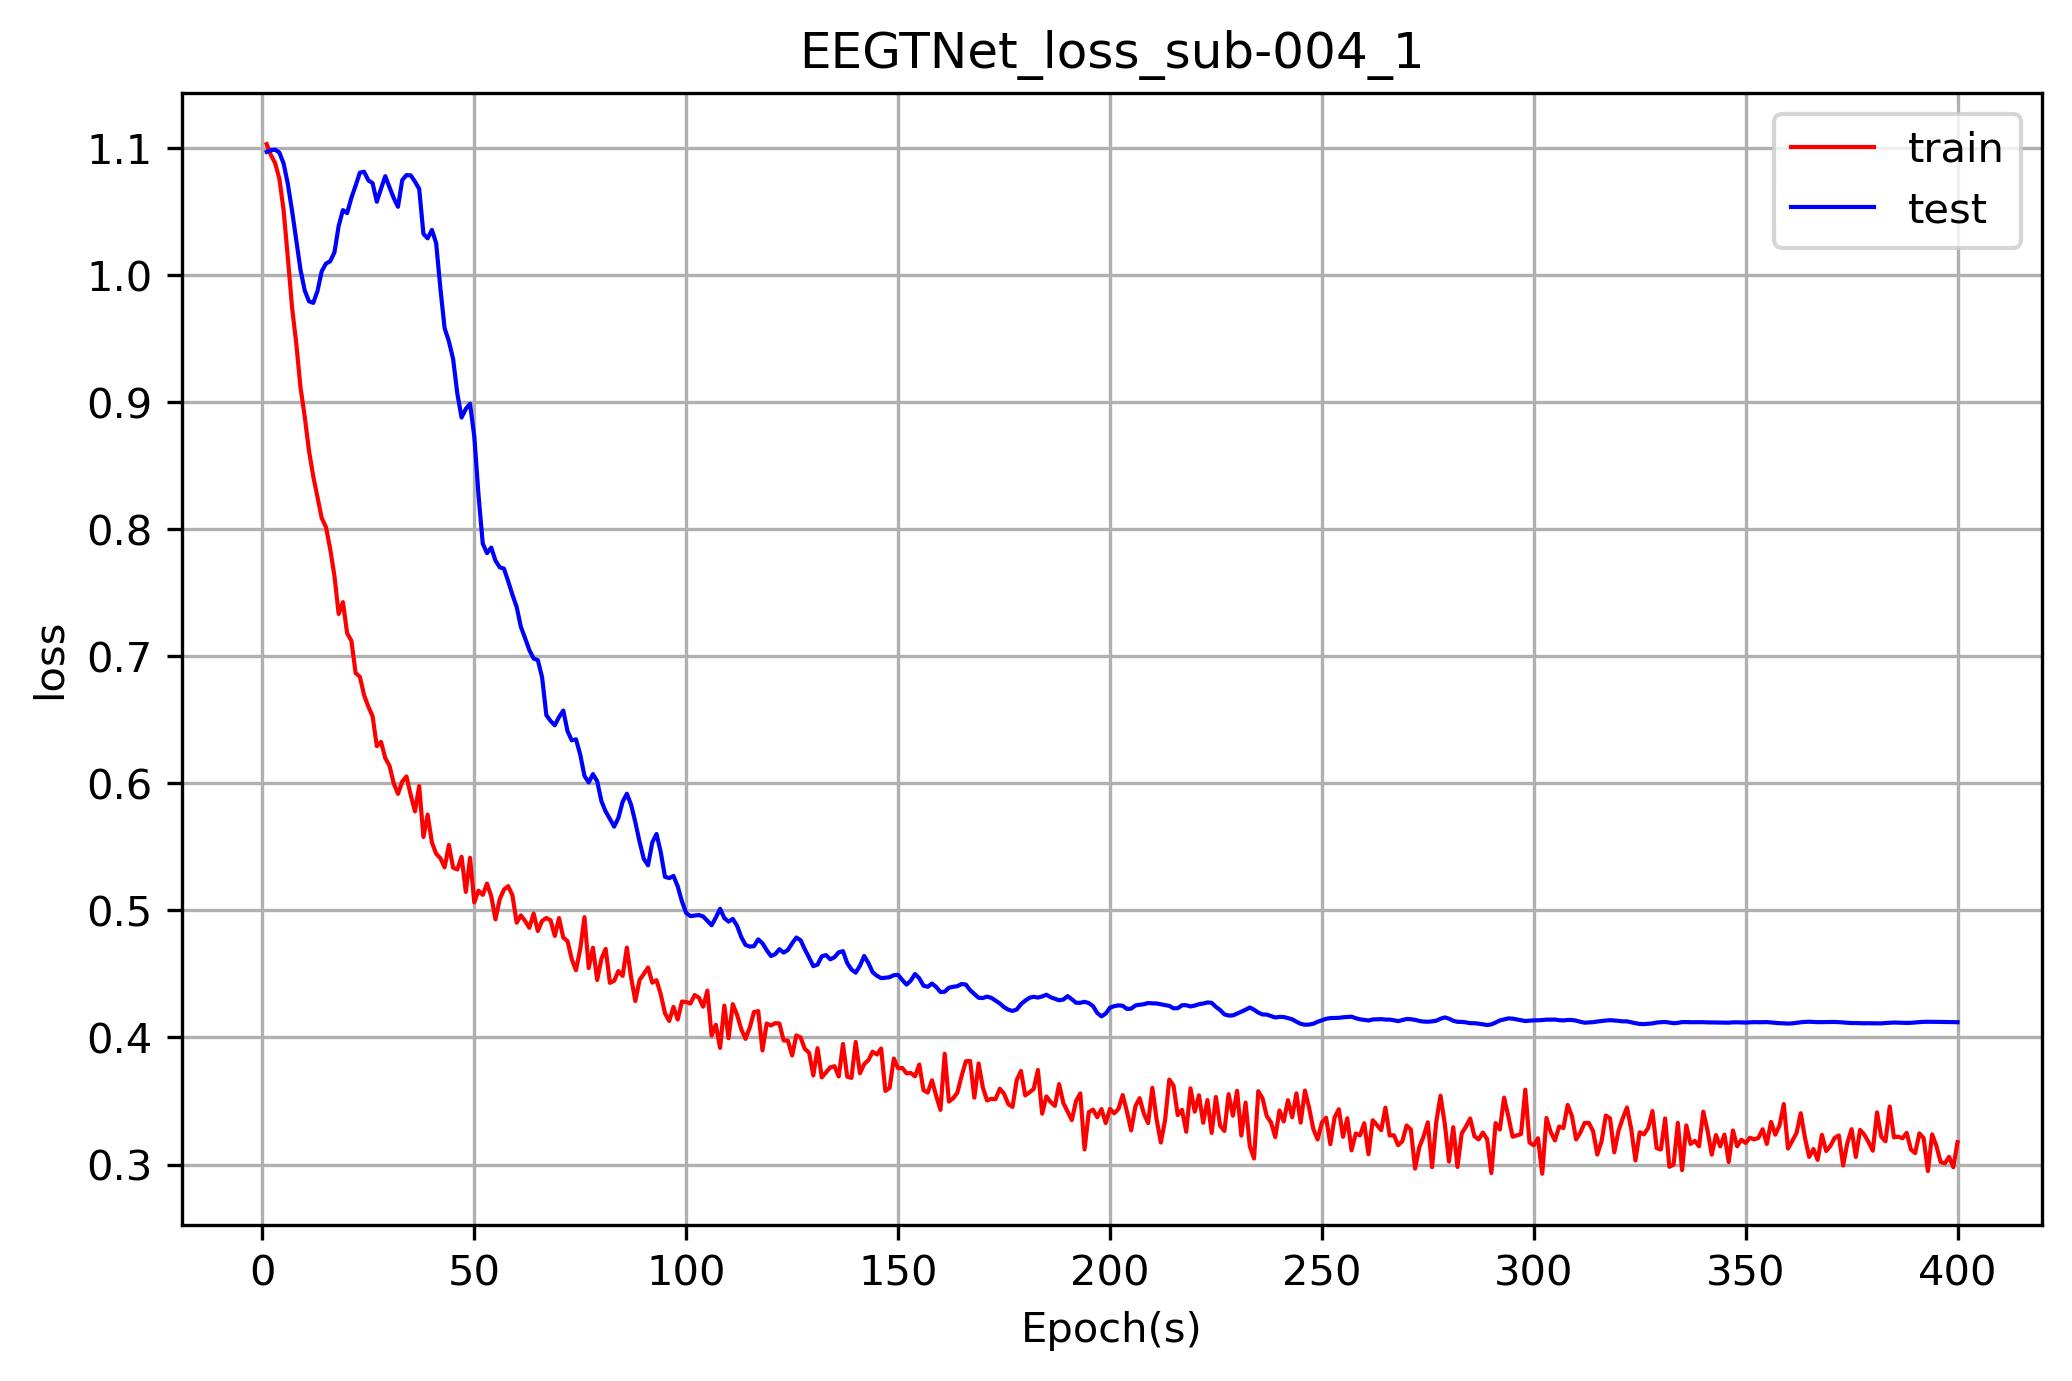

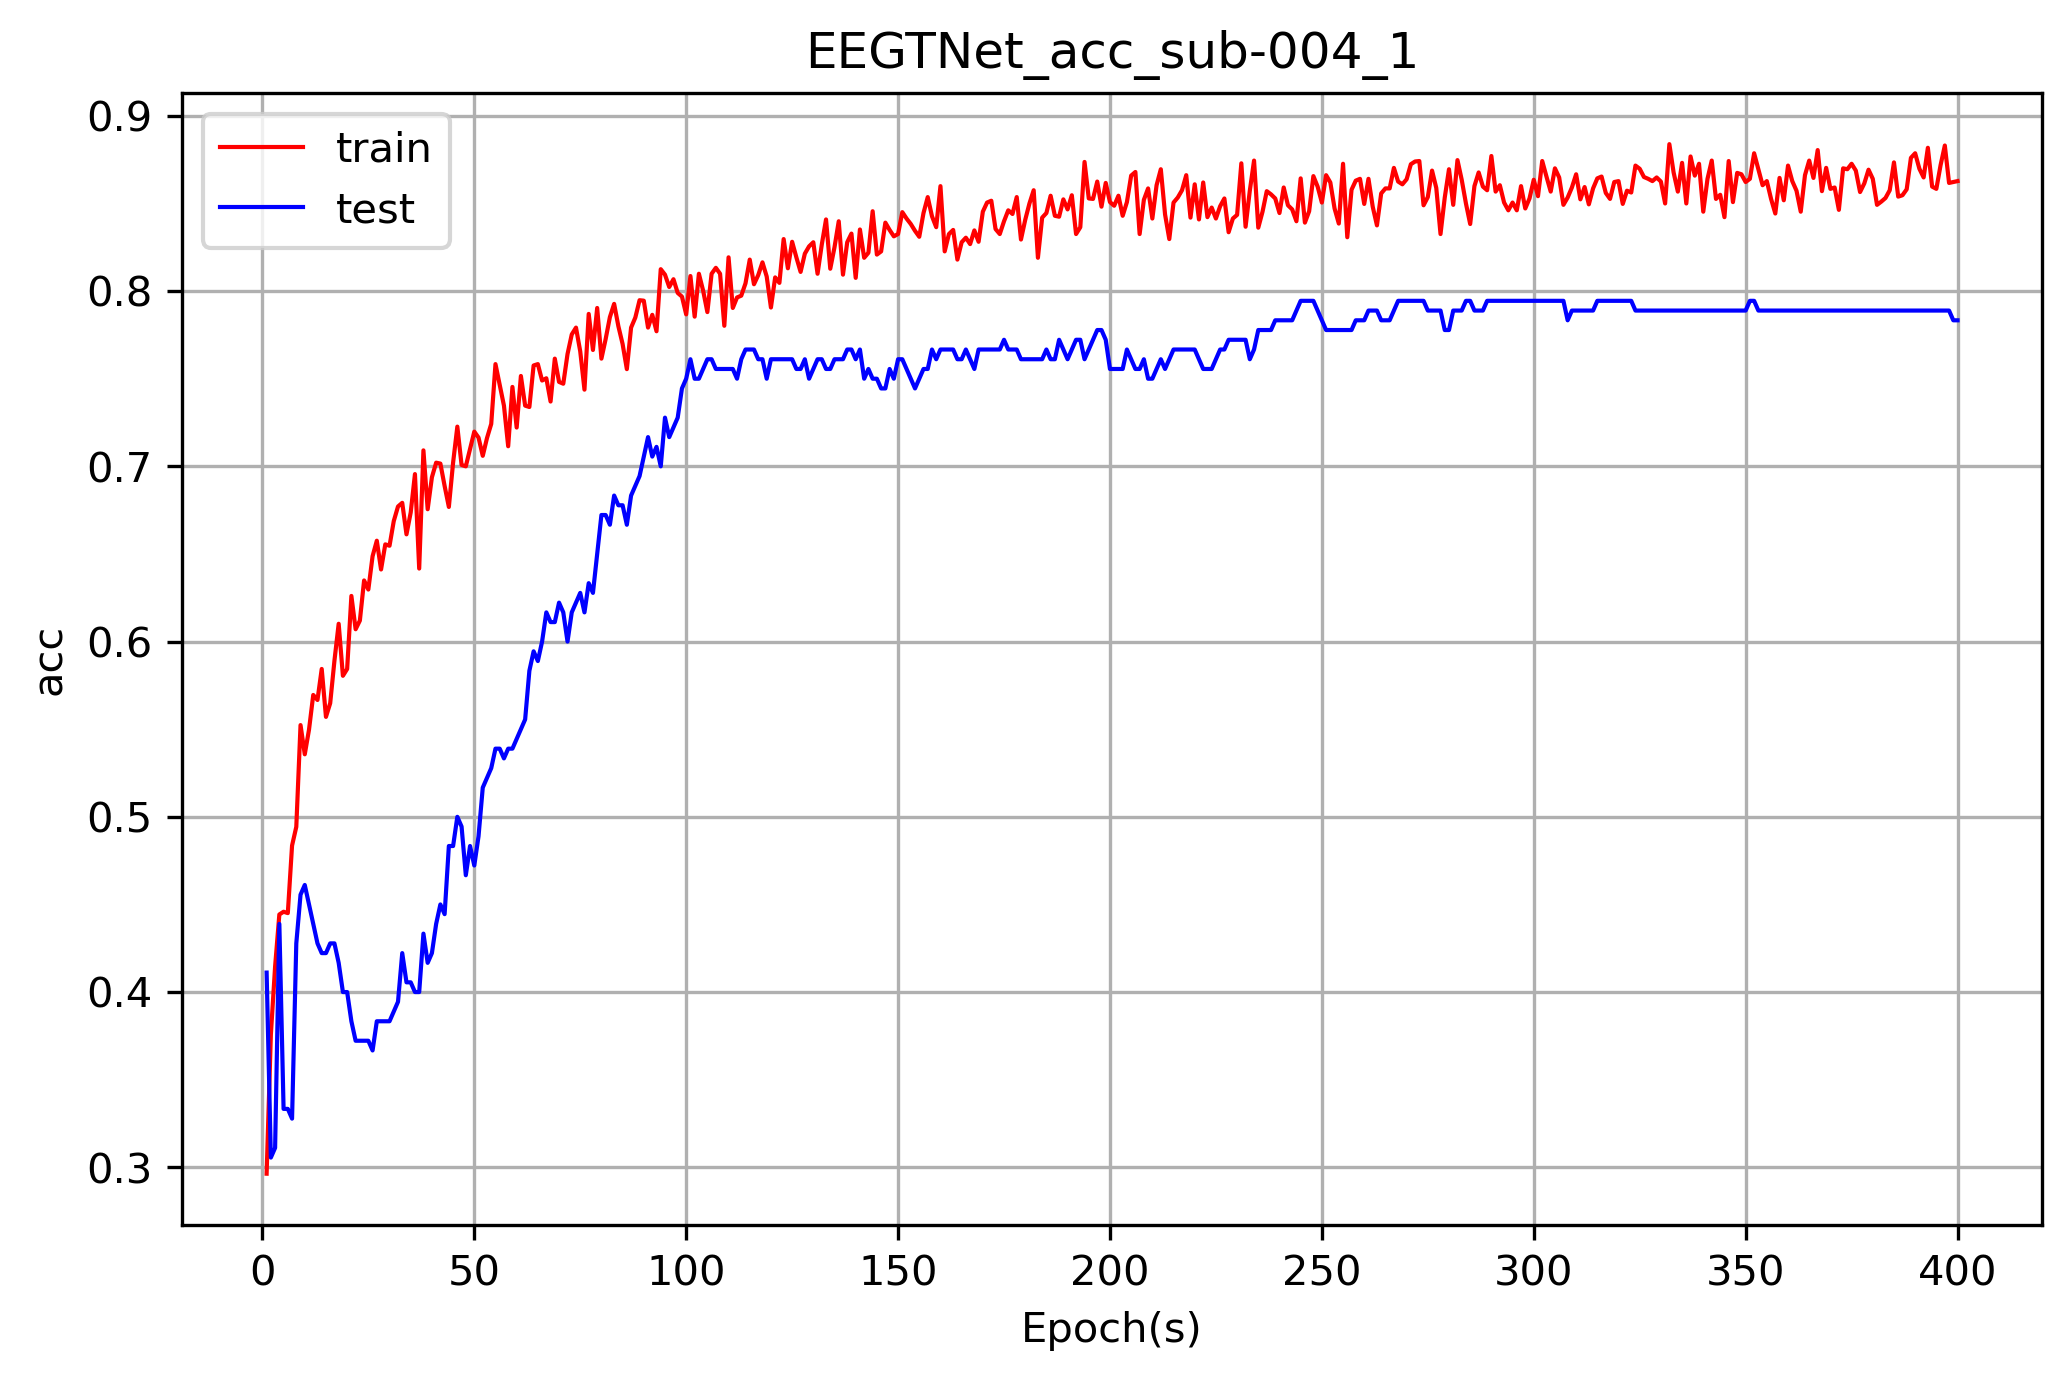

[2021-05-26 01:30:59] [INFO]    current_fold Acc : 0.7833333333333333
[2021-05-26 01:31:00] [INFO]    current_fold: 2 
[2021-05-26 01:31:00] [INFO]    model_path: C:/Users/BCIgroup/Desktop/yqh/Experiment/samelimb/samelimb_EEGTNet_4hp_noresample_e400_b128_1e-3decay/model/sub-004_fold_2_max_model.pt 


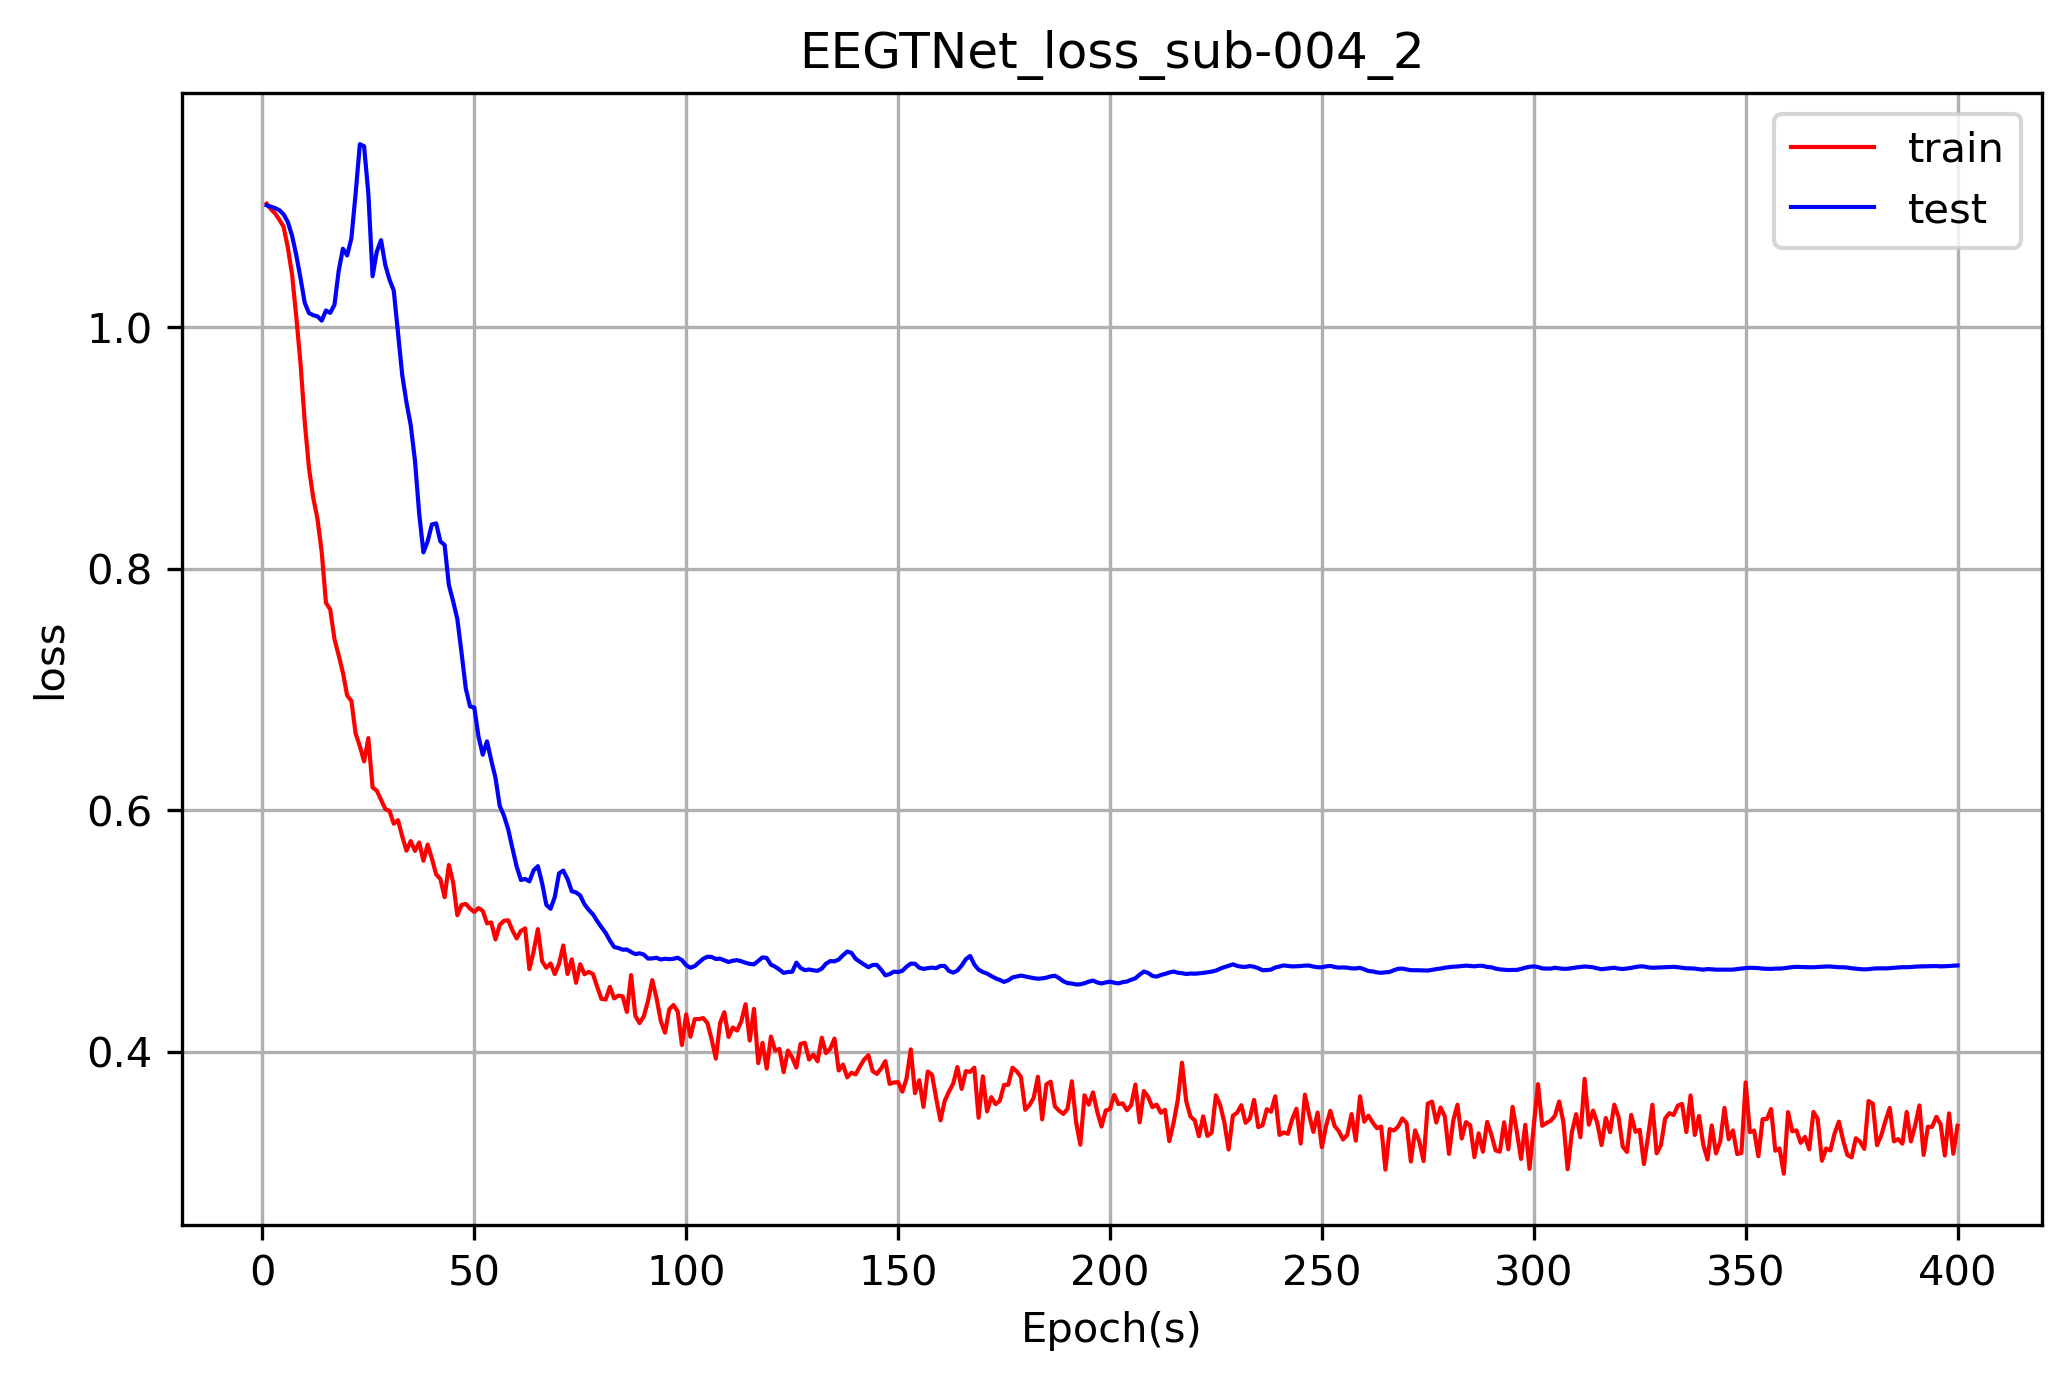

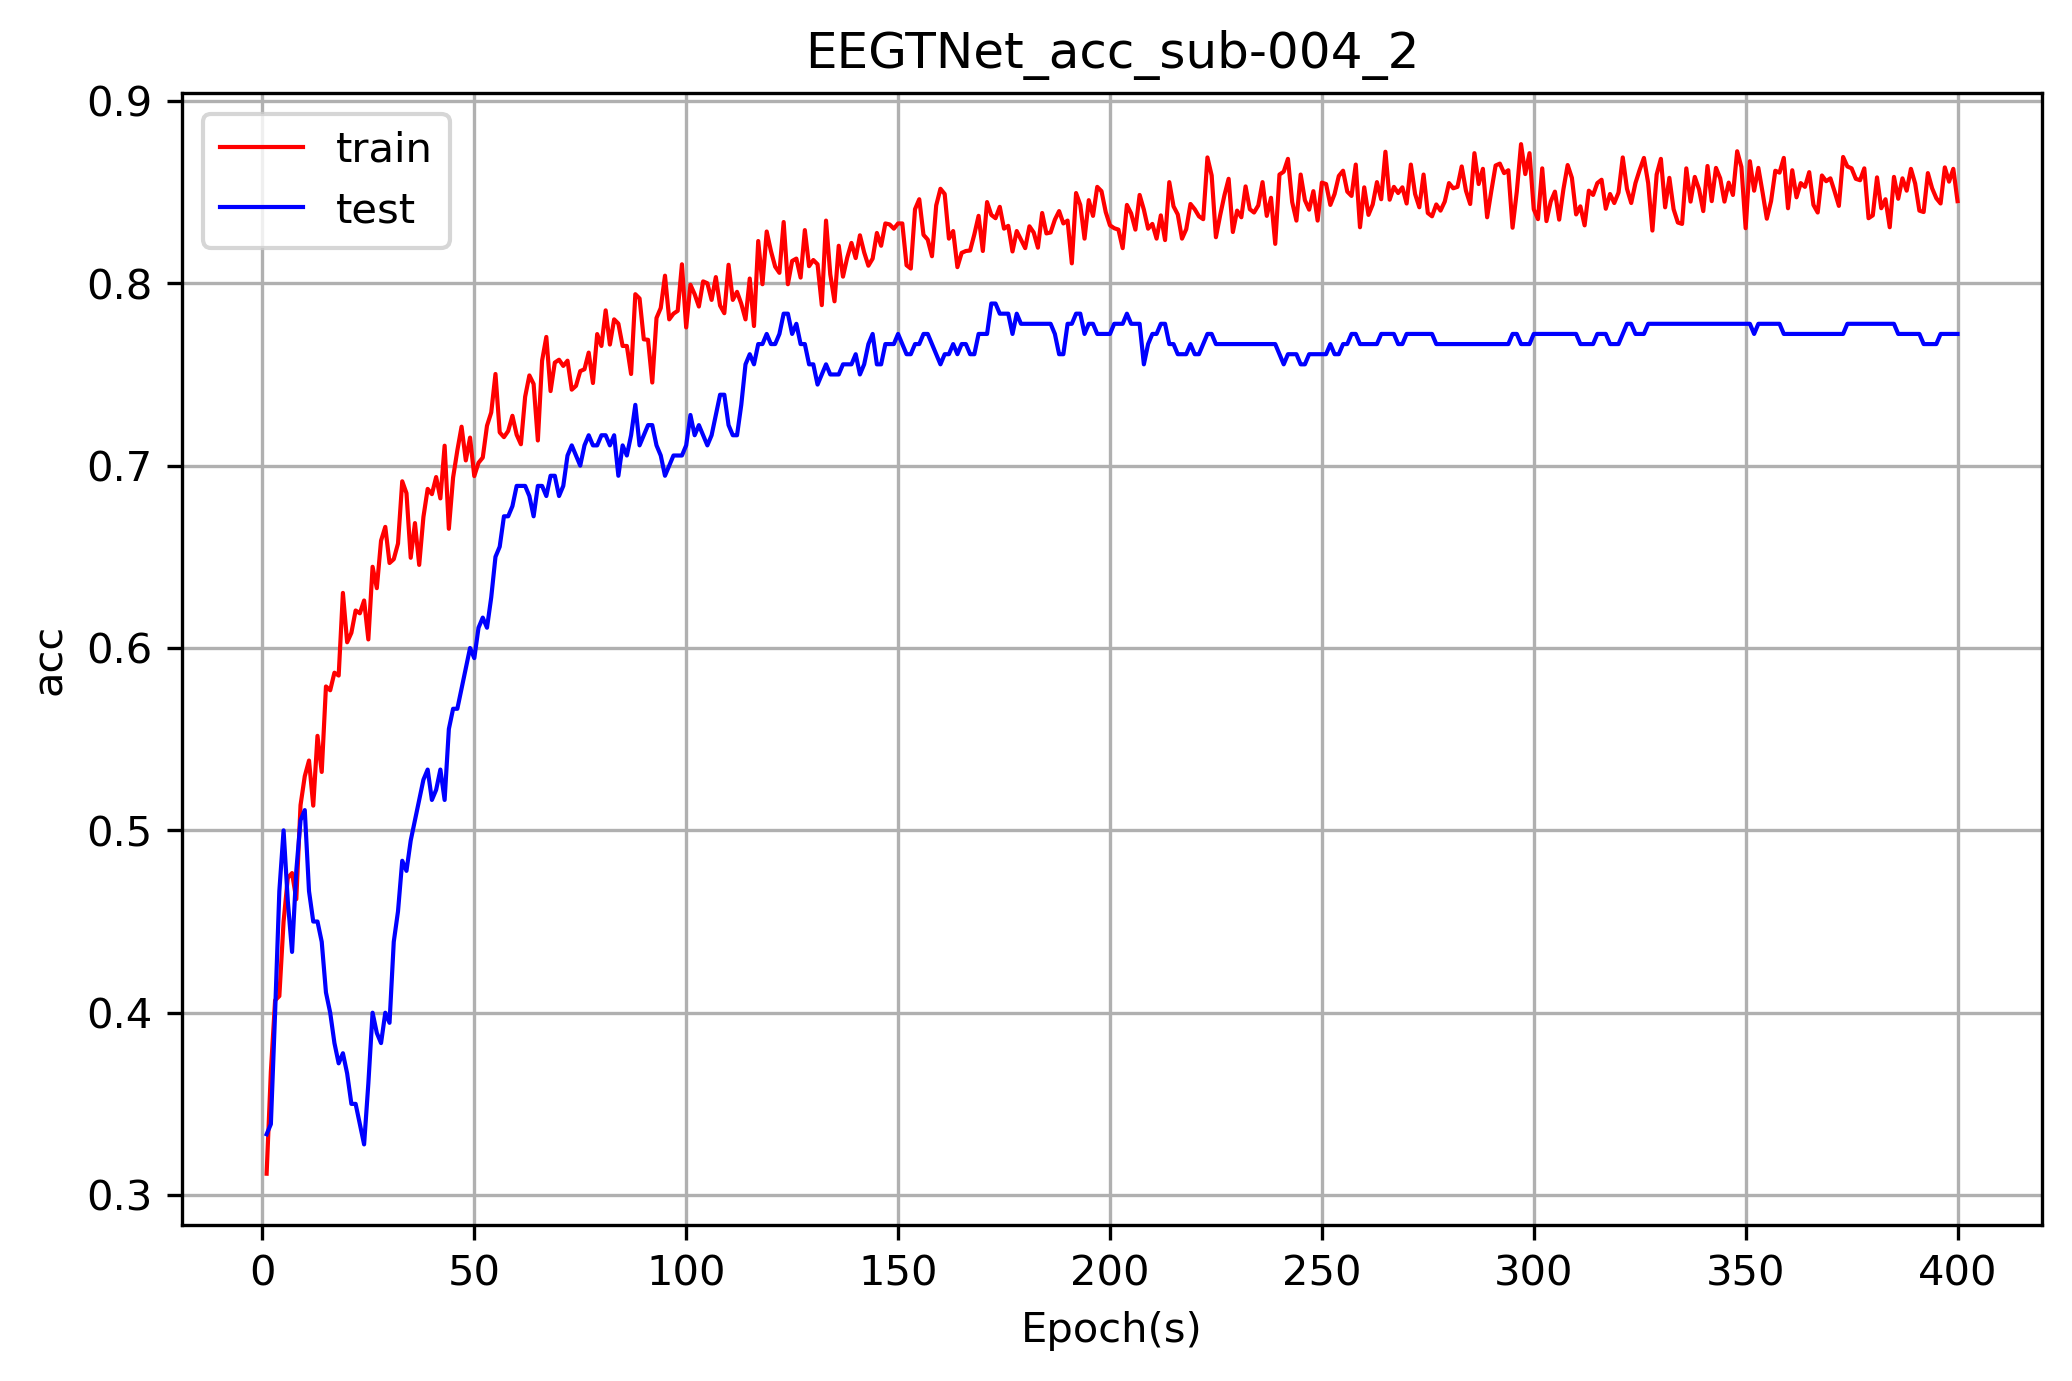

[2021-05-26 03:25:45] [INFO]    current_fold Acc : 0.7722222222222223
[2021-05-26 03:25:45] [INFO]    current_fold: 3 
[2021-05-26 03:25:45] [INFO]    model_path: C:/Users/BCIgroup/Desktop/yqh/Experiment/samelimb/samelimb_EEGTNet_4hp_noresample_e400_b128_1e-3decay/model/sub-004_fold_3_max_model.pt 


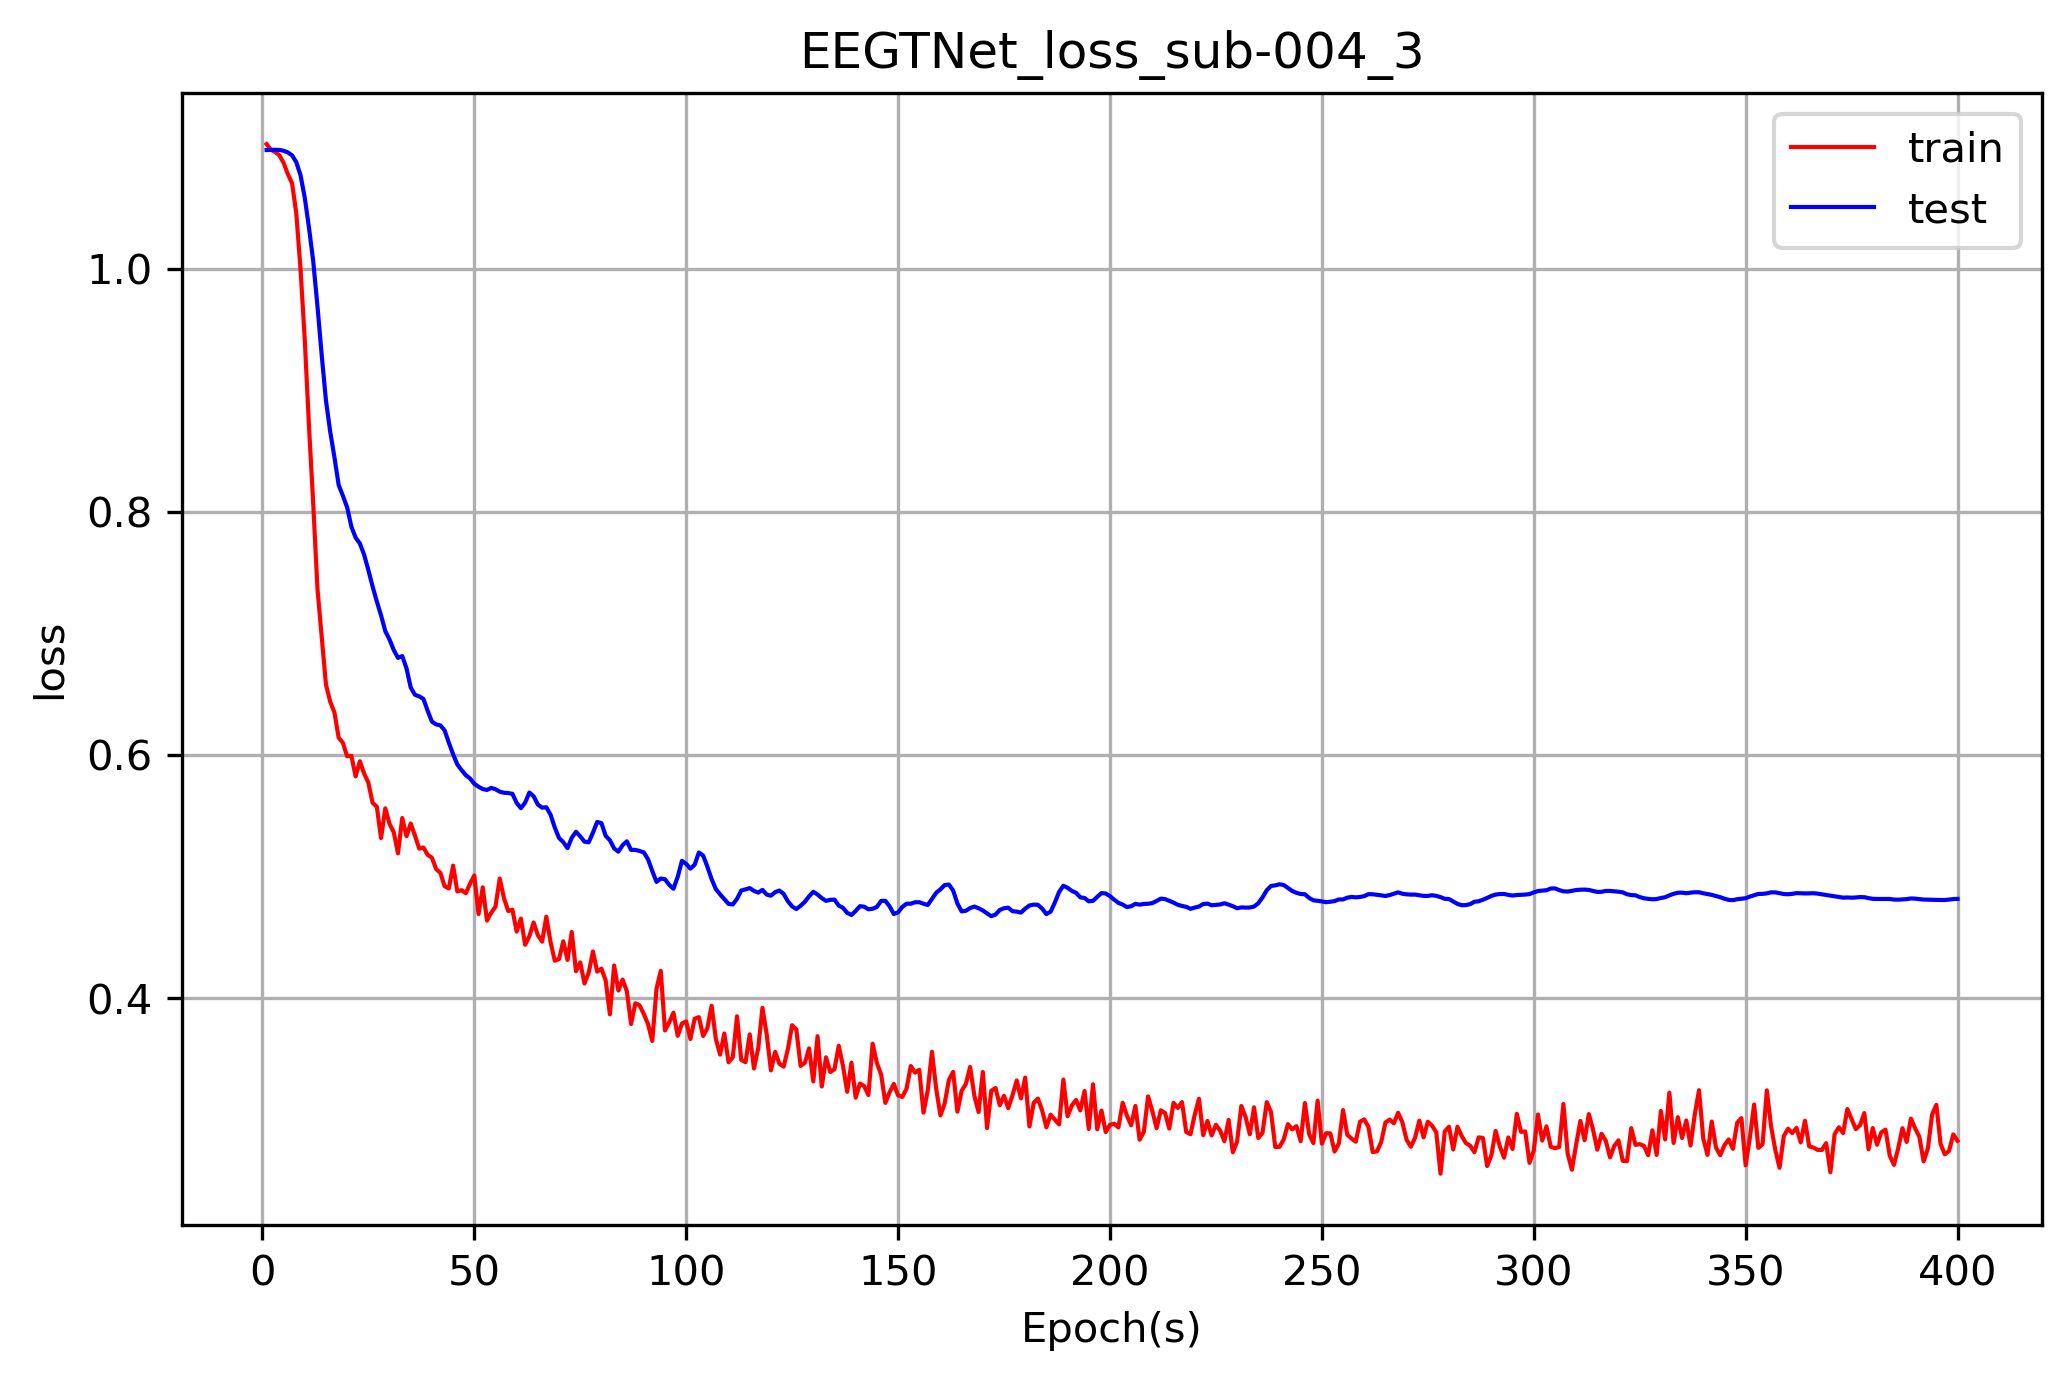

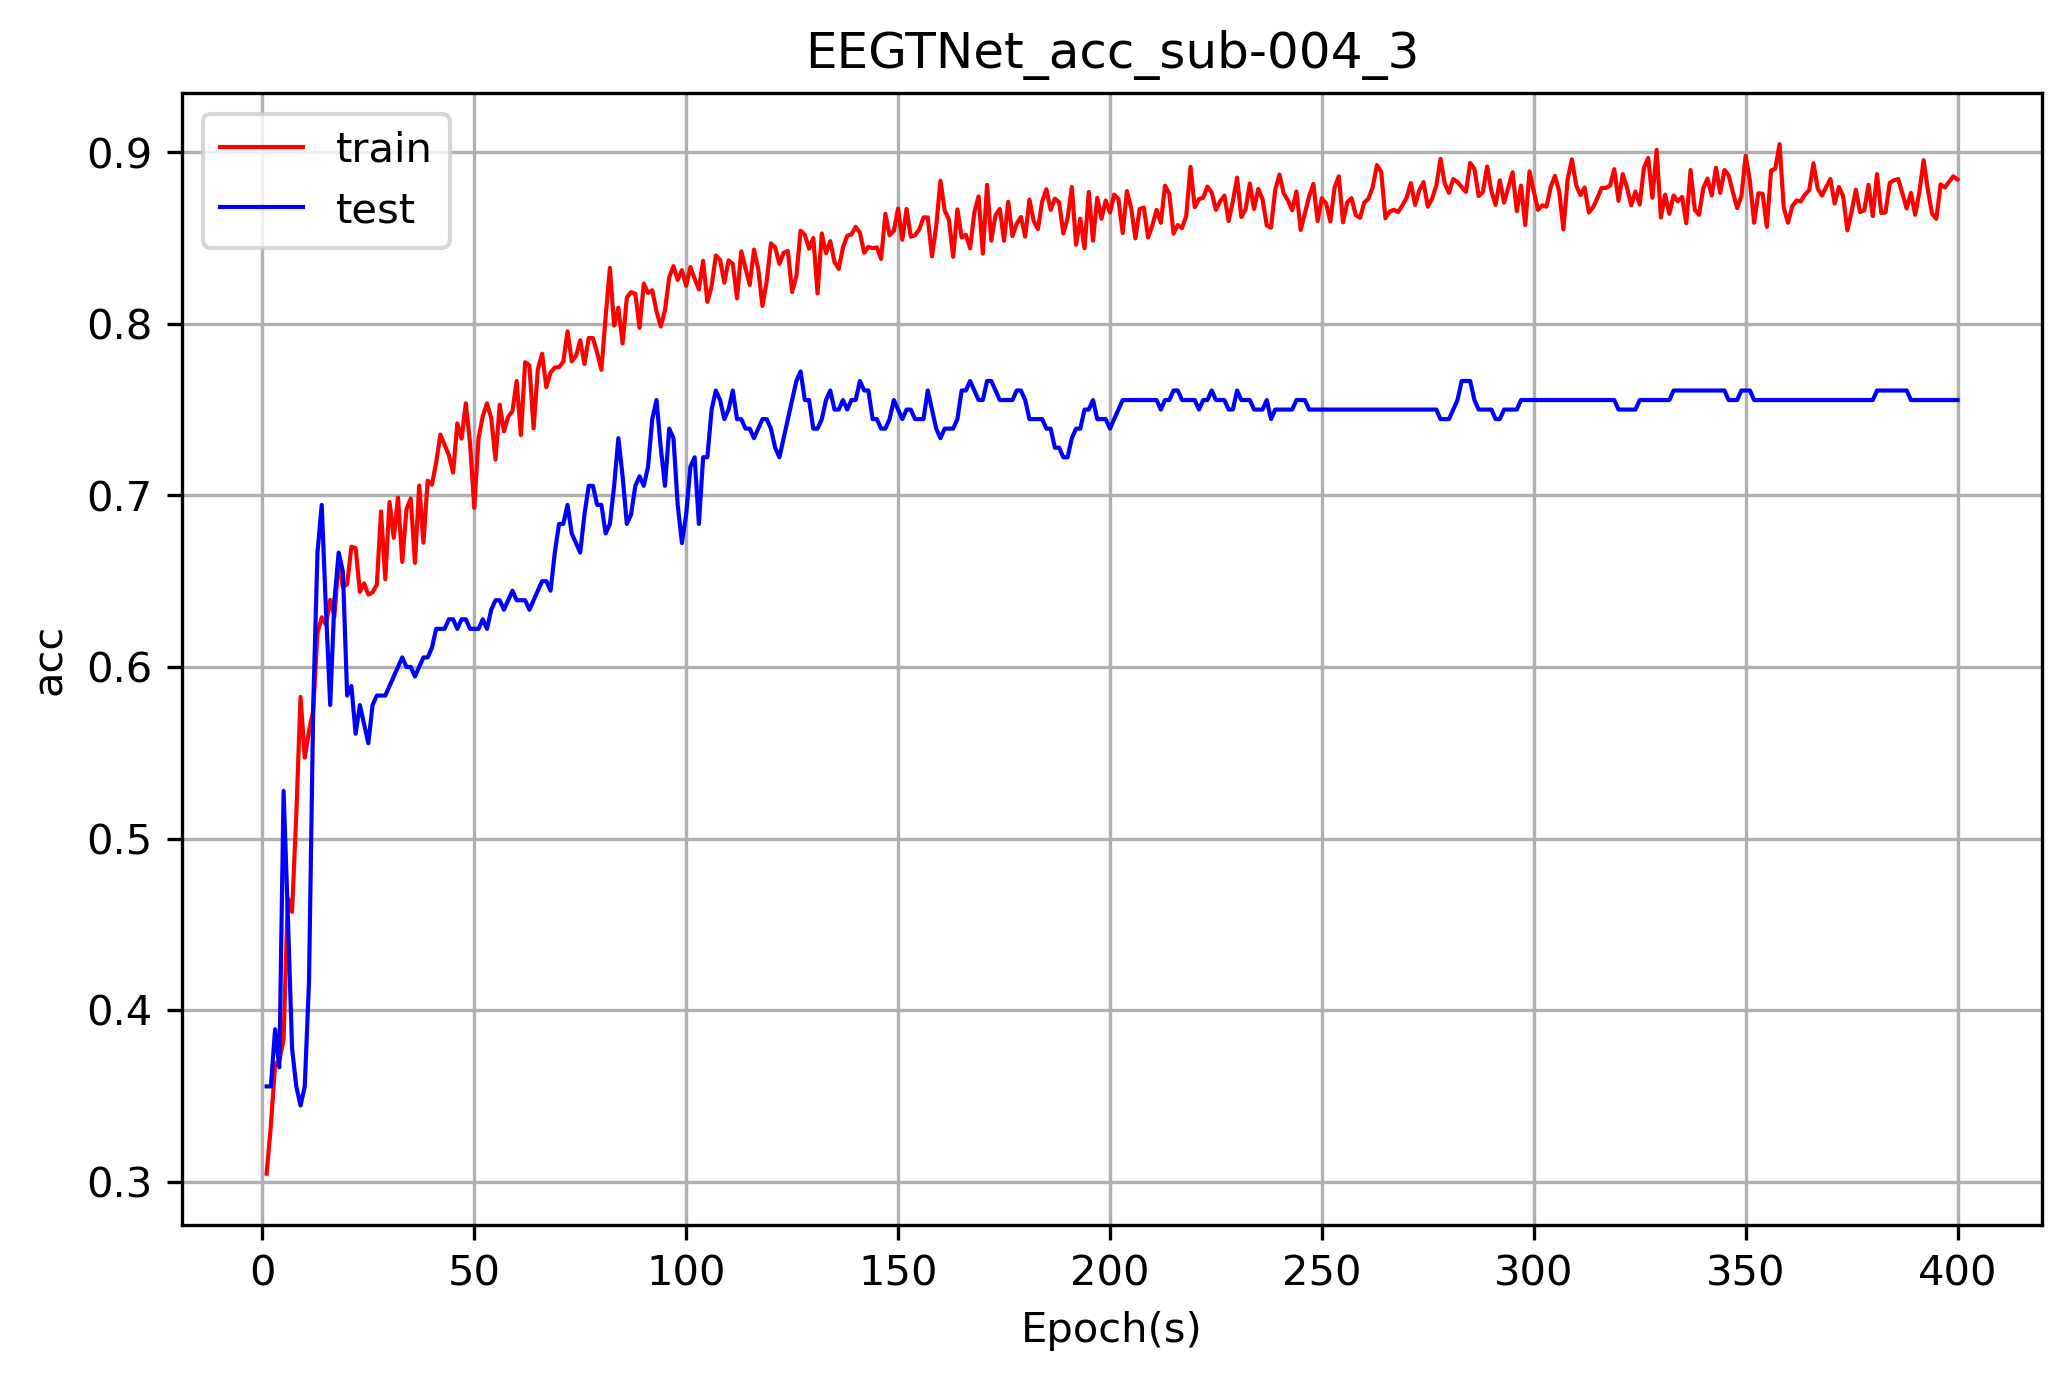

[2021-05-26 05:20:16] [INFO]    current_fold Acc : 0.7555555555555555
[2021-05-26 05:20:16] [INFO]    current_fold: 4 
[2021-05-26 05:20:16] [INFO]    model_path: C:/Users/BCIgroup/Desktop/yqh/Experiment/samelimb/samelimb_EEGTNet_4hp_noresample_e400_b128_1e-3decay/model/sub-004_fold_4_max_model.pt 


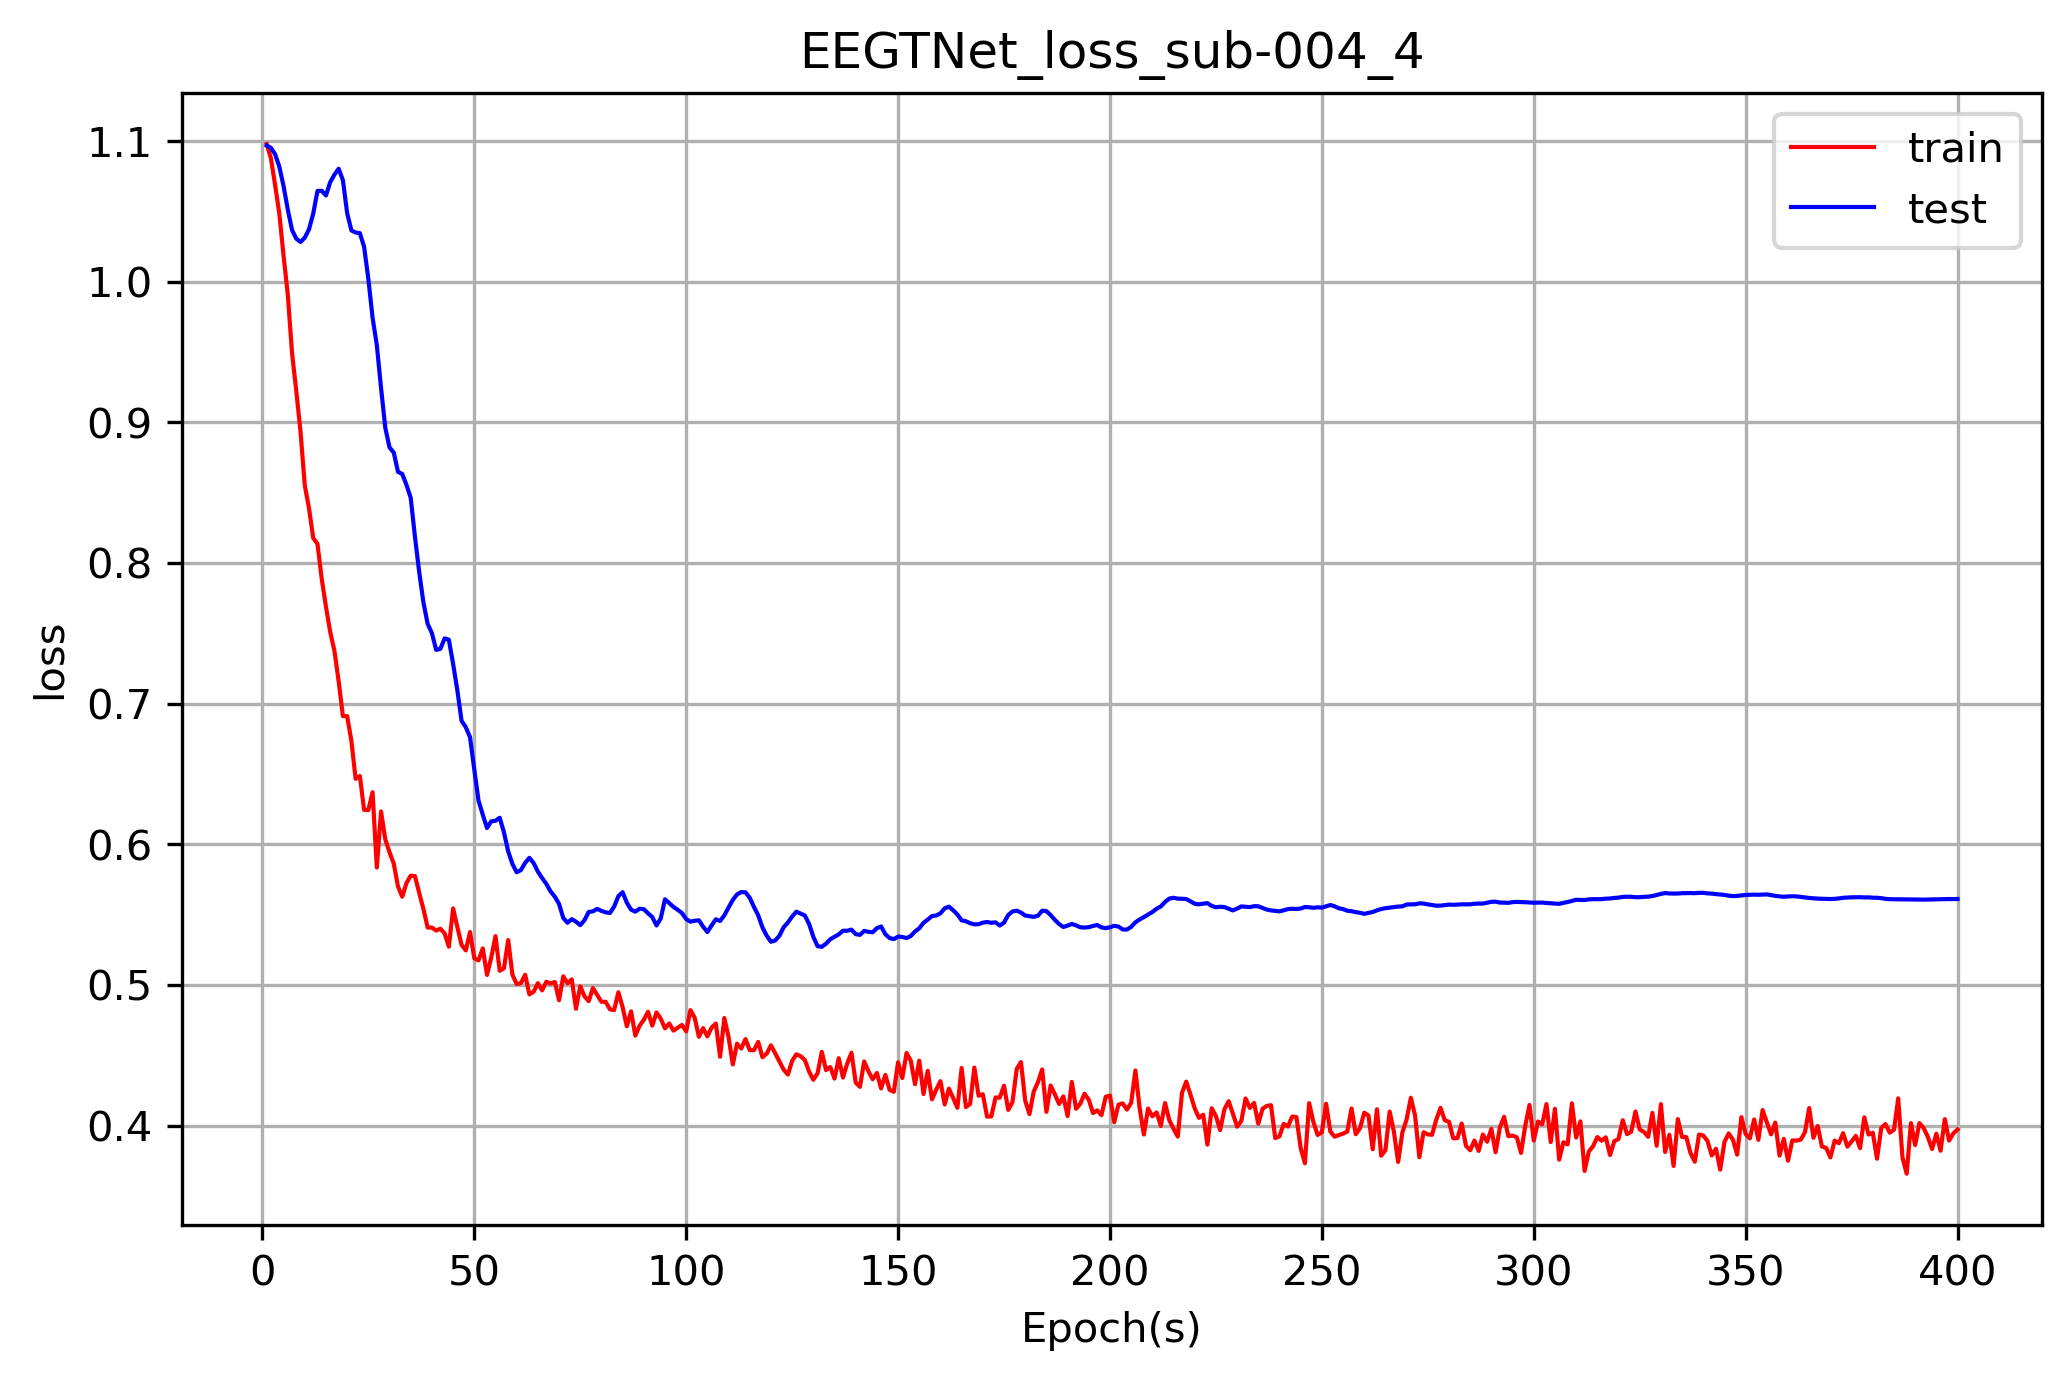

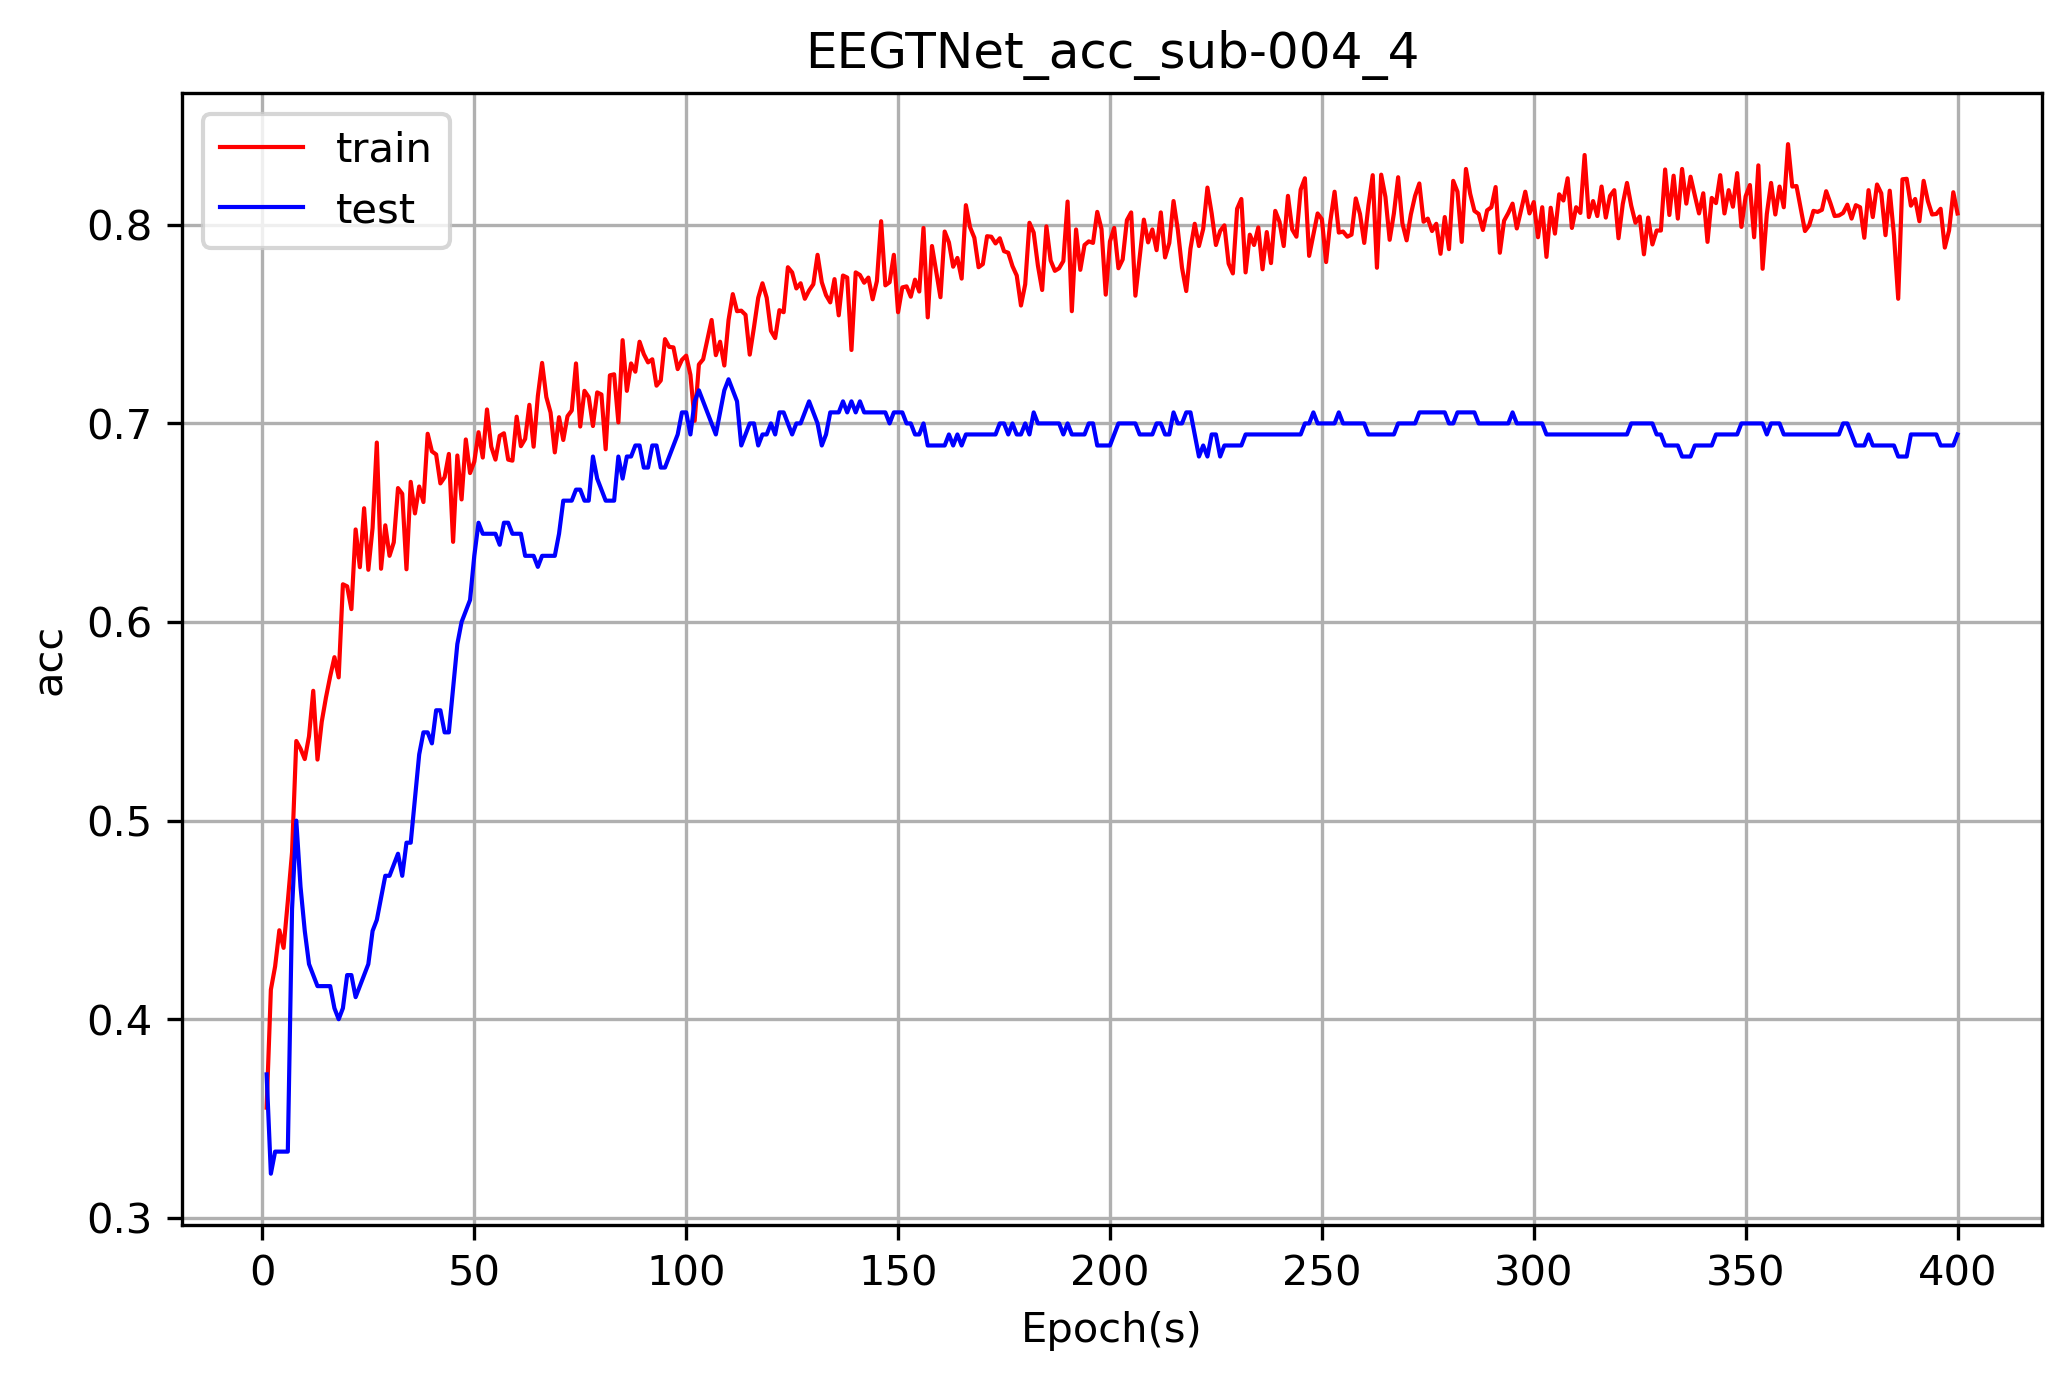

[2021-05-26 07:17:10] [INFO]    current_fold Acc : 0.6944444444444444
[2021-05-26 07:17:11] [INFO]    current_fold: 5 
[2021-05-26 07:17:11] [INFO]    model_path: C:/Users/BCIgroup/Desktop/yqh/Experiment/samelimb/samelimb_EEGTNet_4hp_noresample_e400_b128_1e-3decay/model/sub-004_fold_5_max_model.pt 


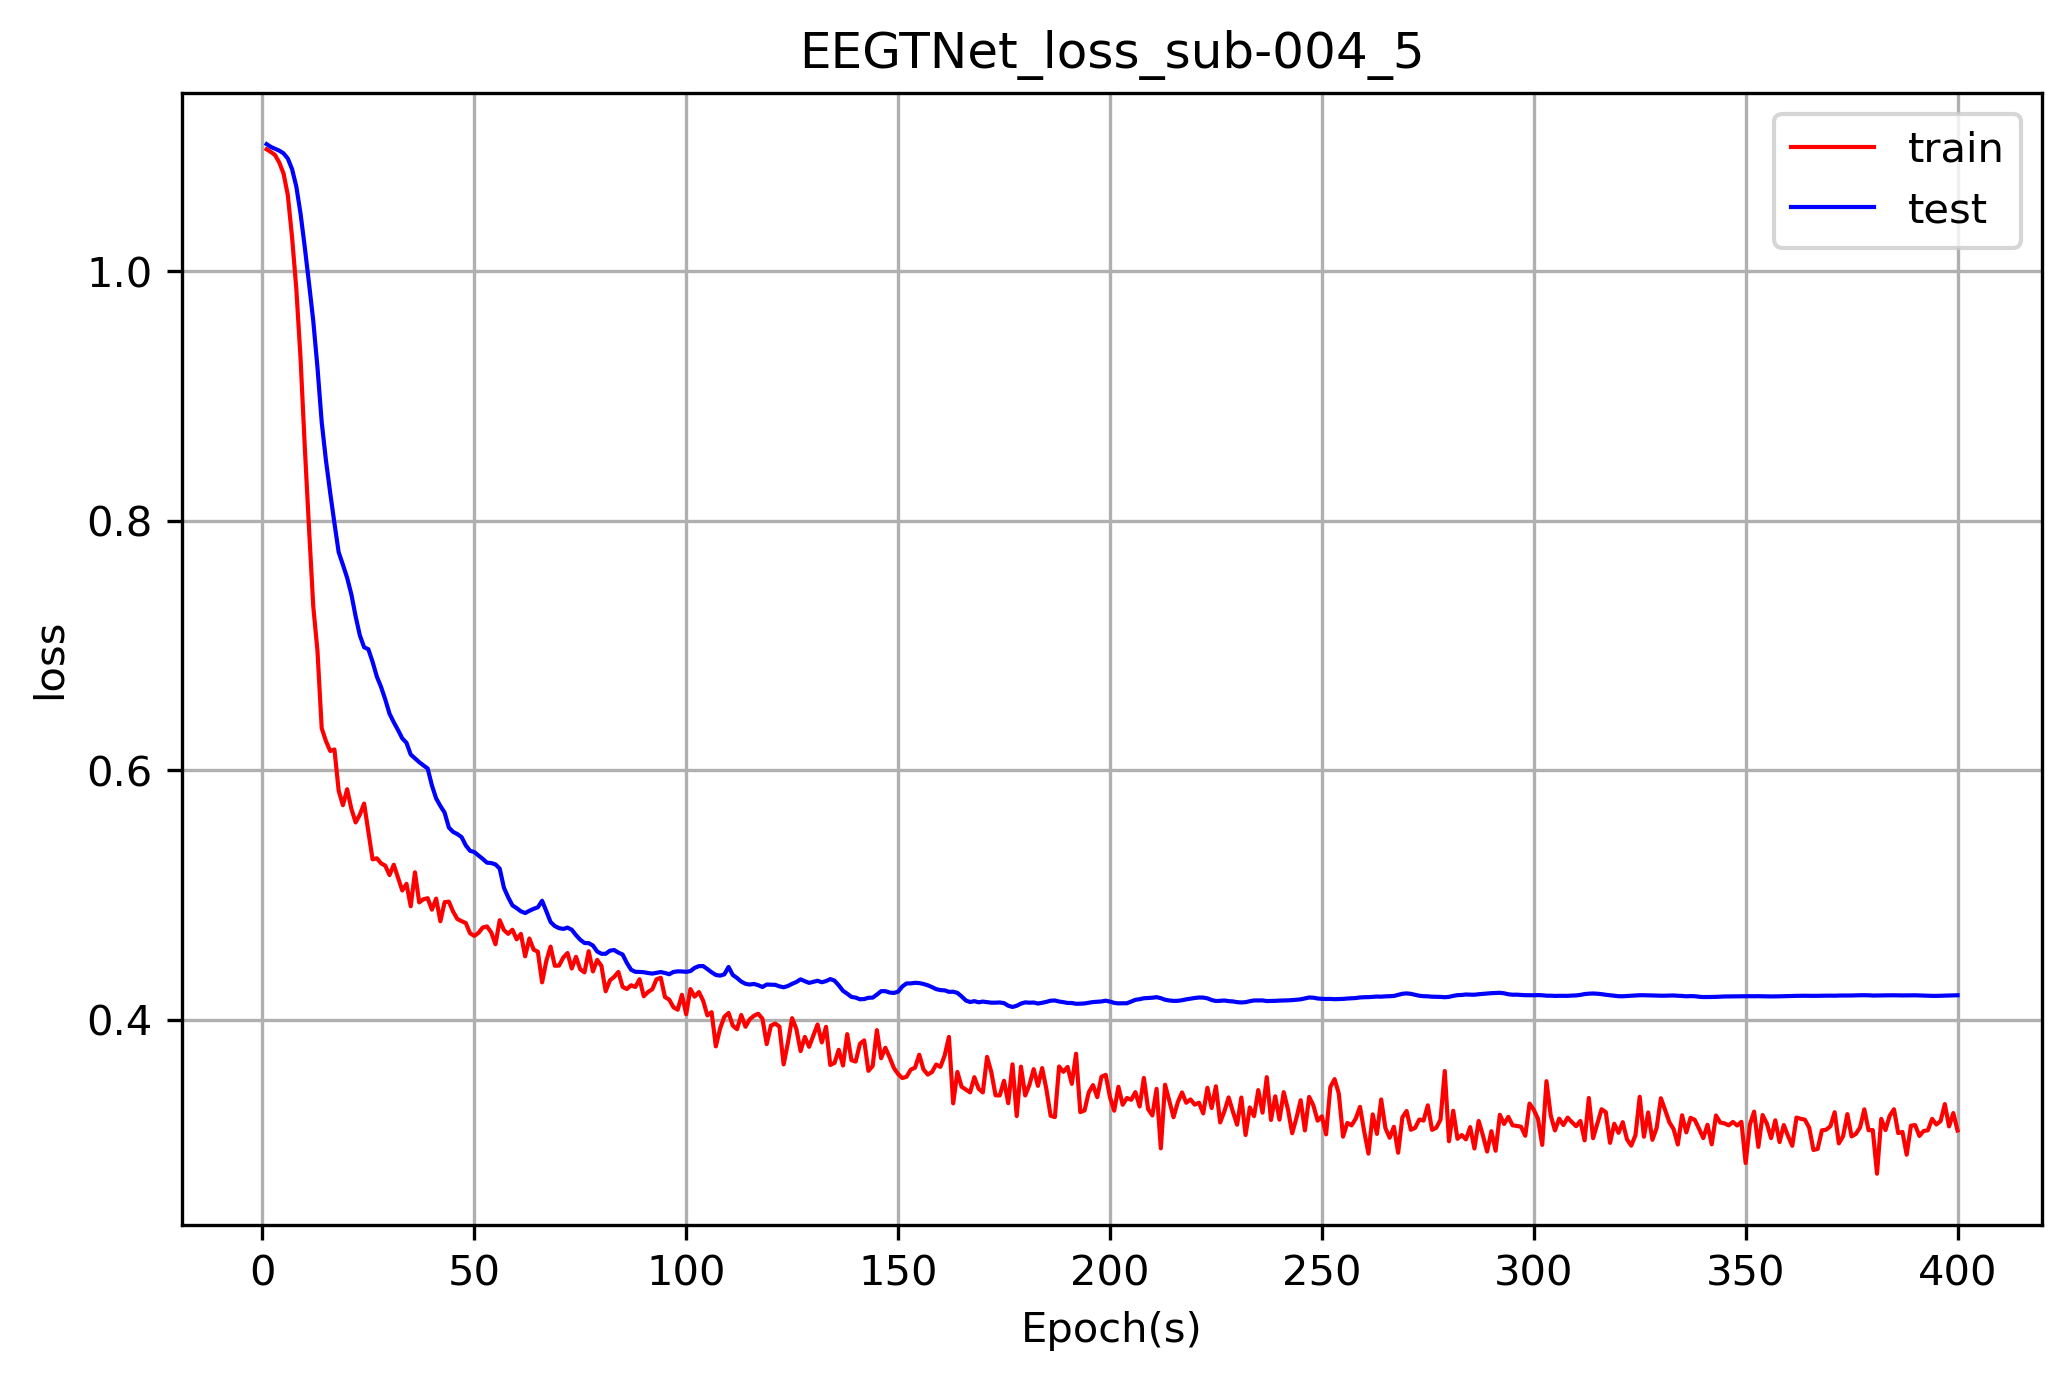

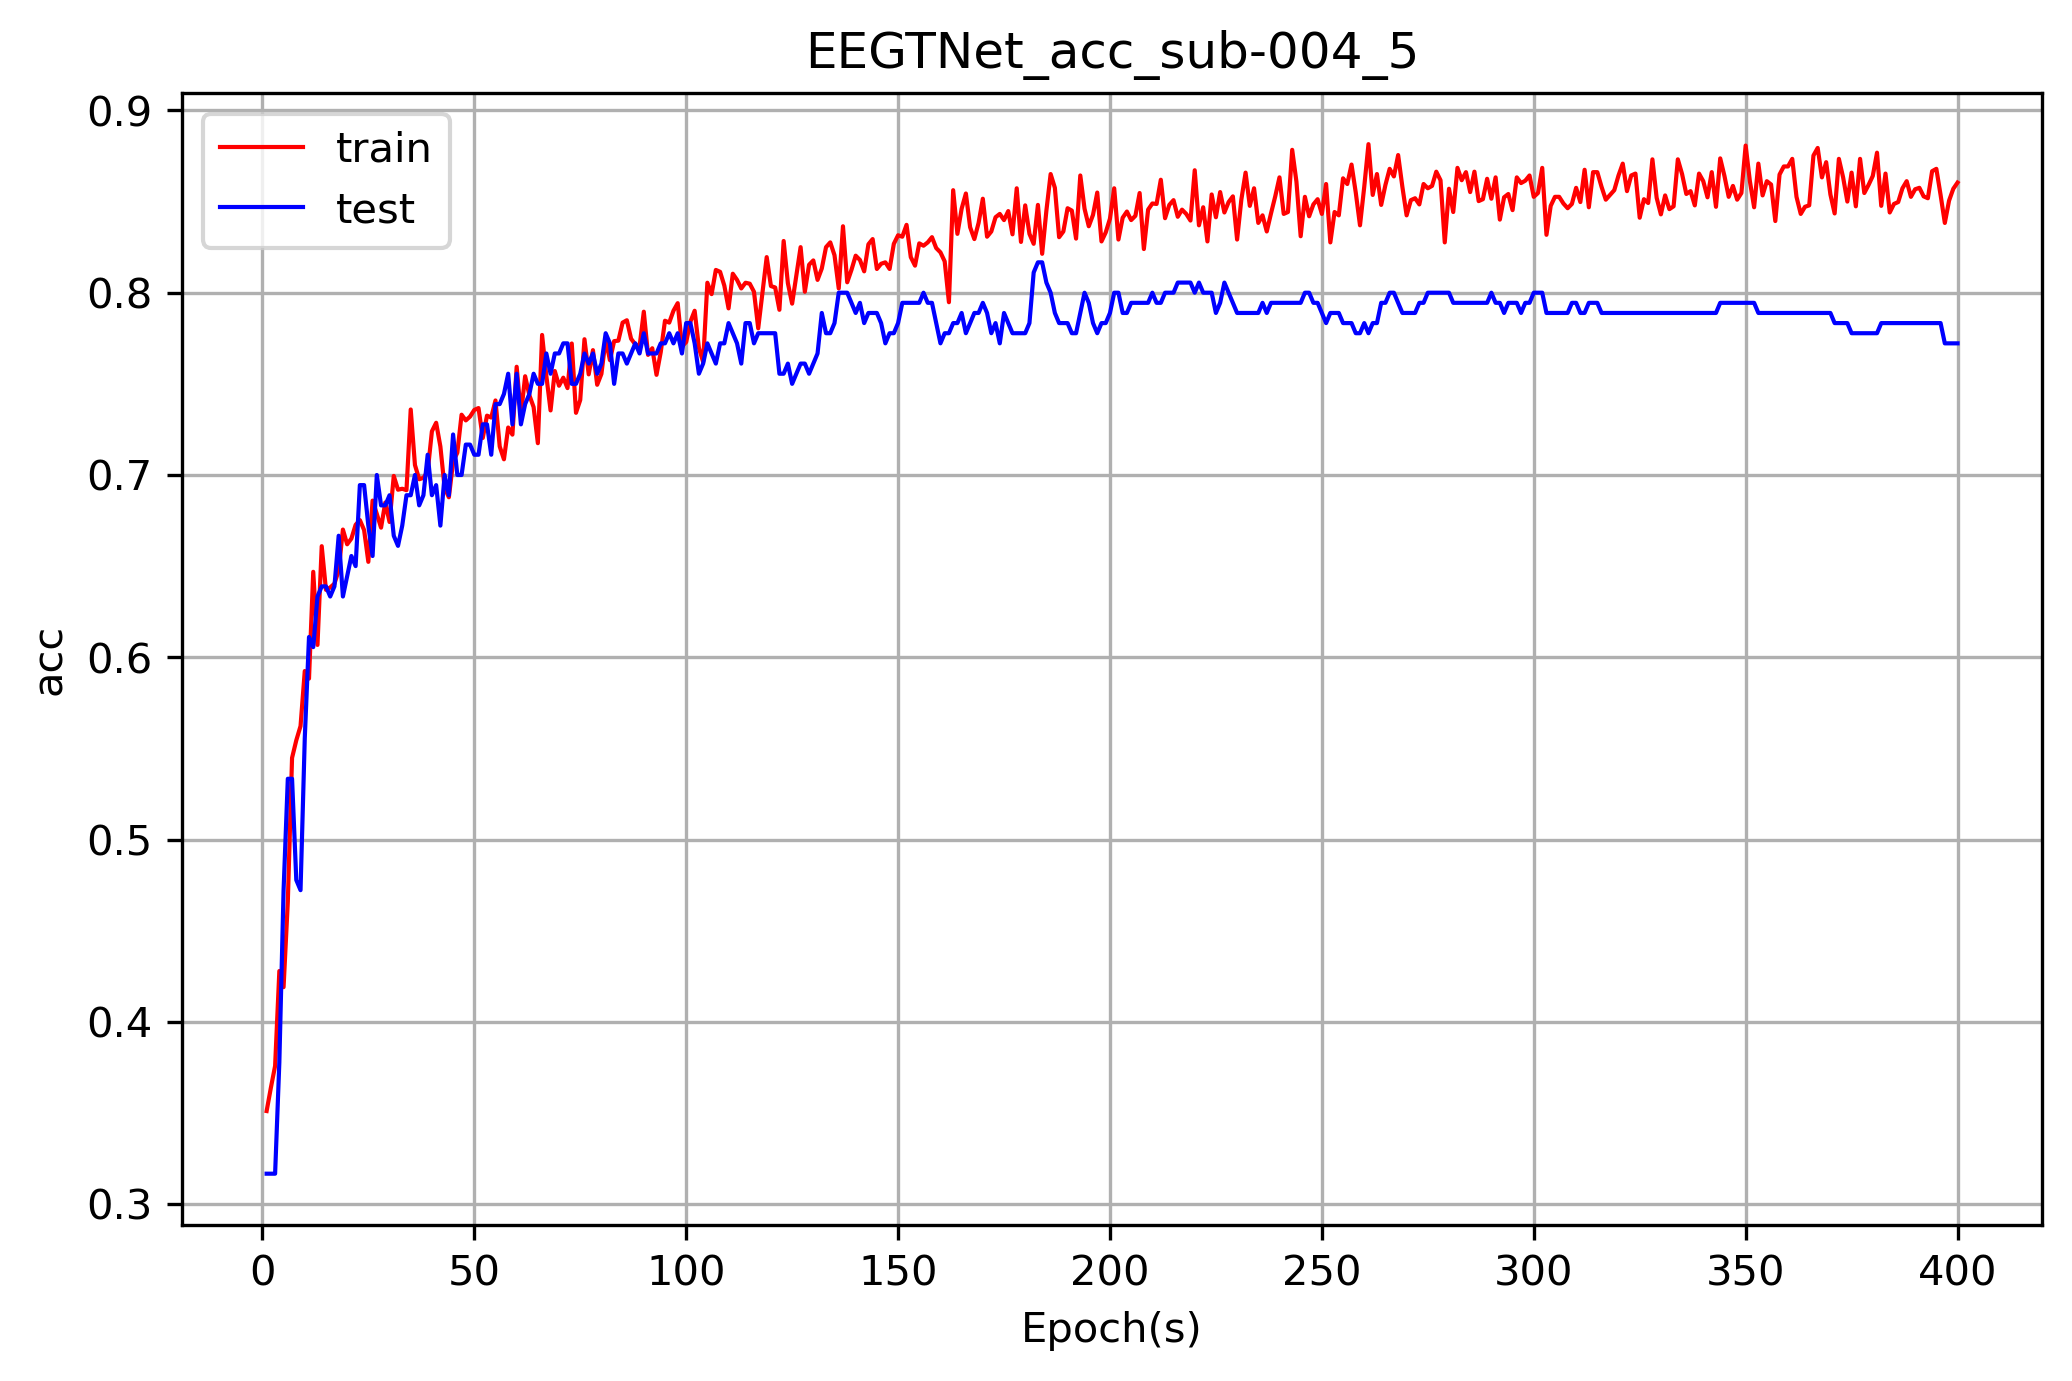

[2021-05-26 09:12:15] [INFO]    current_fold Acc : 0.7722222222222223
[2021-05-26 09:12:15] [INFO]    datapath 	sub-004_task-motorimagery_eeg
[2021-05-26 09:12:15] [INFO]    subject 	sub-004
[2021-05-26 09:12:15] [INFO]    result of KFlodTrain : [0.7833333333333333, 0.7722222222222223, 0.7555555555555555, 0.6944444444444444, 0.7722222222222223]
[2021-05-26 09:12:15] [INFO]    mean of KFlodTrain 	0.7556 
[2021-05-26 09:12:15] [INFO]    std of KFlodTrain 	0.0318 


datapath C:\Users\BCIgroup\Desktop\yqh\data\samelimb\sub-005_task-motorimagery_eeg.mat
load C:\Users\BCIgroup\Desktop\yqh\data\samelimb\sub-005_task-motorimagery_eeg.mat


[2021-05-26 09:12:20] [INFO]    image_path: C:/Users/BCIgroup/Desktop/yqh/Experiment/samelimb/samelimb_EEGTNet_4hp_noresample_e400_b128_1e-3decay/image/ 
[2021-05-26 09:12:20] [INFO]    logpath: C:/Users/BCIgroup/Desktop/yqh/Experiment/samelimb/samelimb_EEGTNet_4hp_noresample_e400_b128_1e-3decay/log/samelimb_EEGTNet_4hp_noresample_e400_b128_1e-3decay.log 
[2021-05-26 09:12:20] [INFO]    current_fold: 1 
[2021-05-26 09:12:20] [INFO]    model_path: C:/Users/BCIgroup/Desktop/yqh/Experiment/samelimb/samelimb_EEGTNet_4hp_noresample_e400_b128_1e-3decay/model/sub-005_fold_1_max_model.pt 


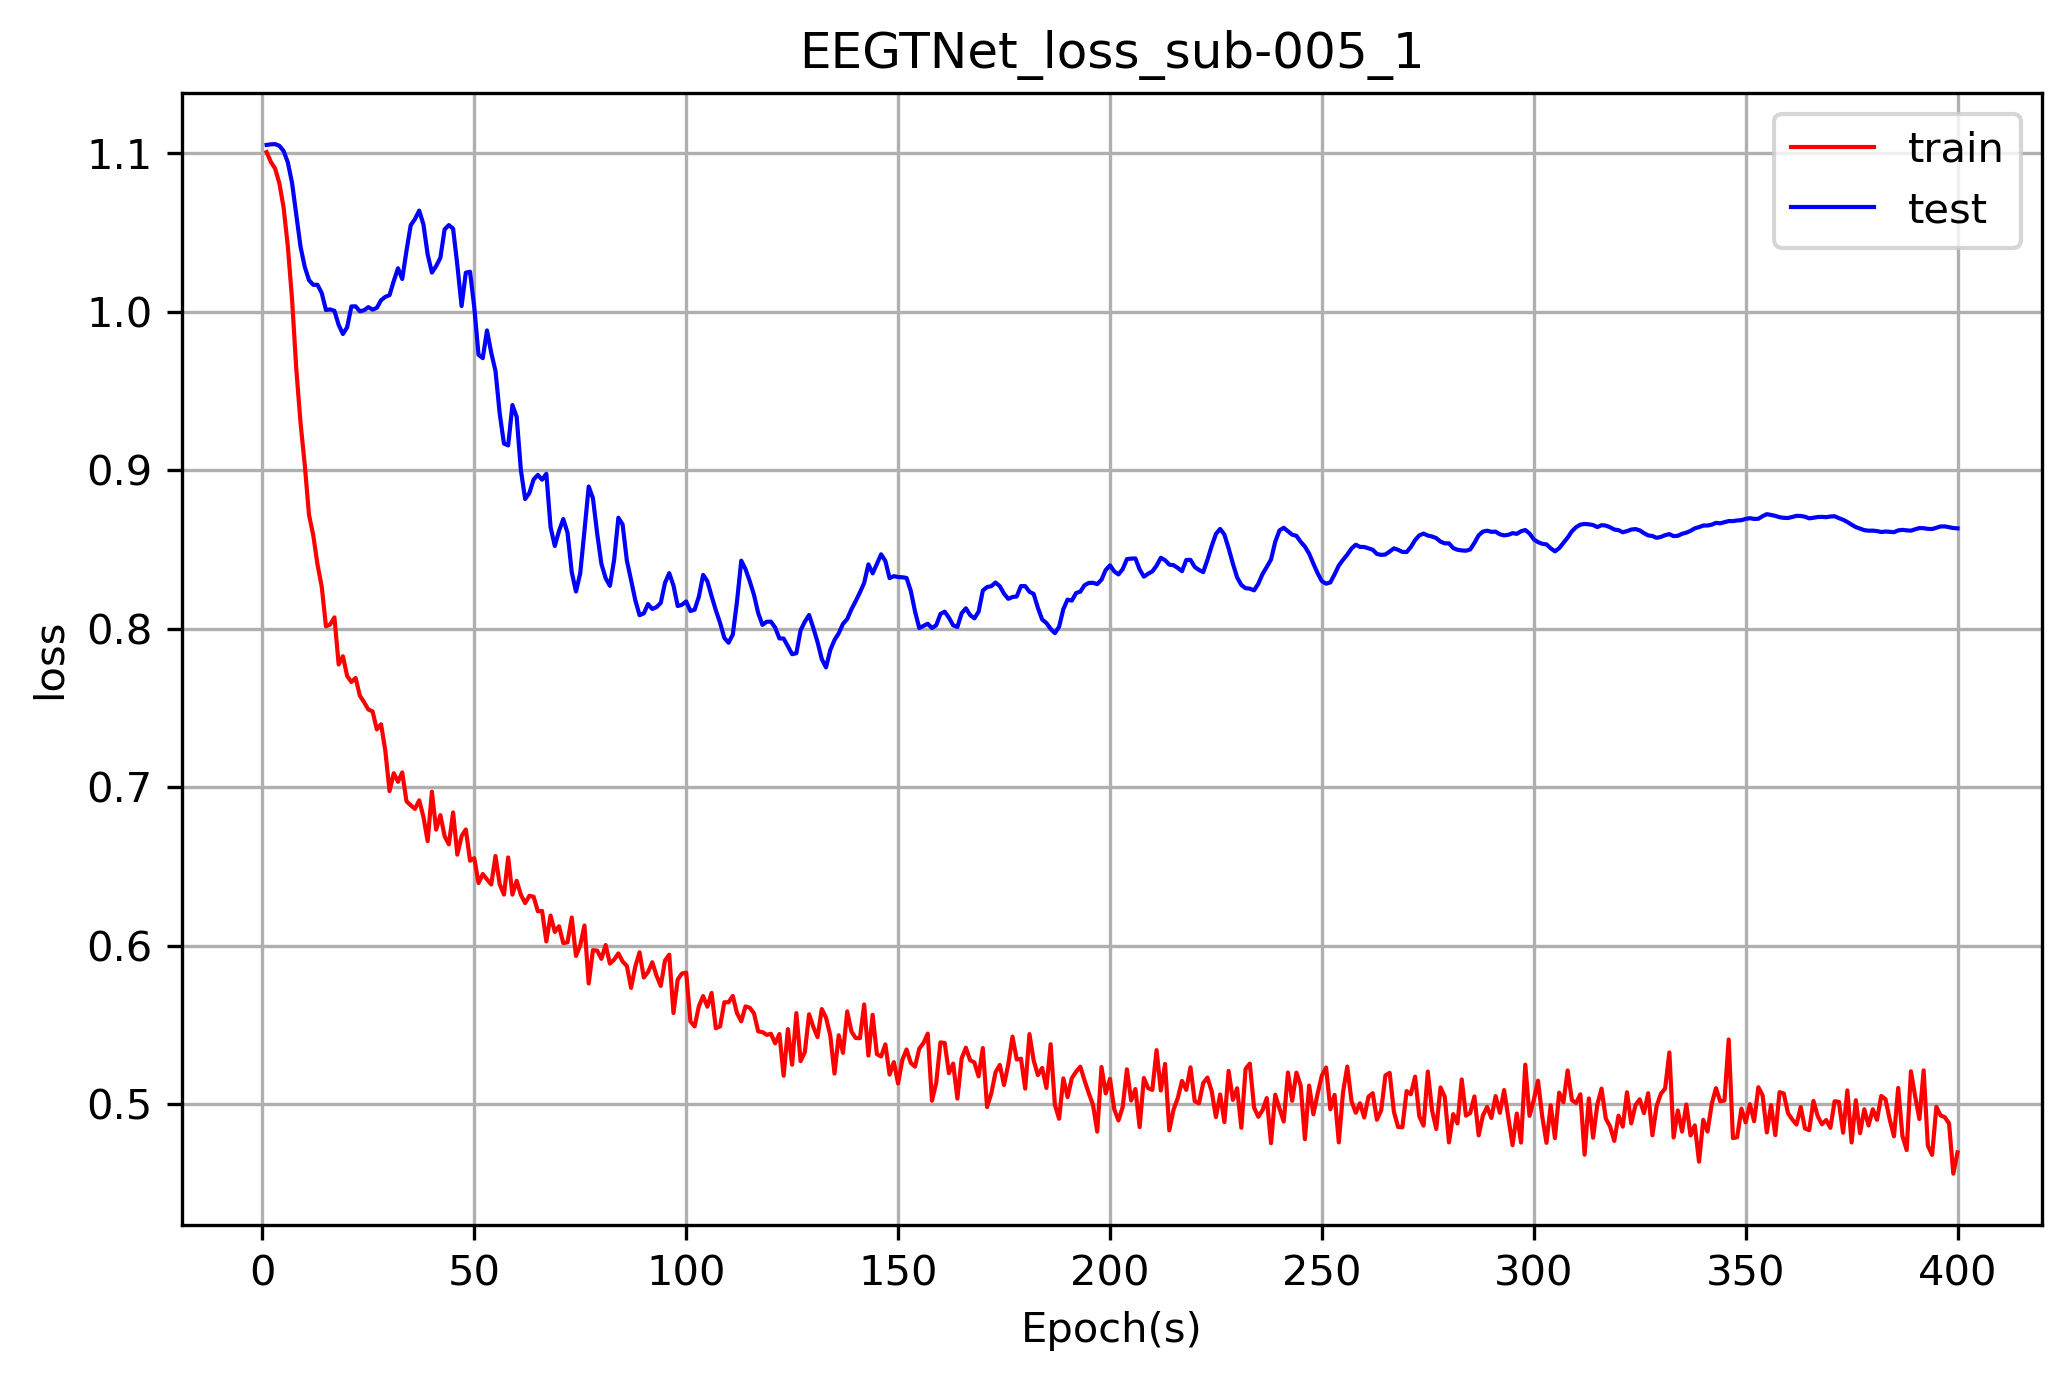

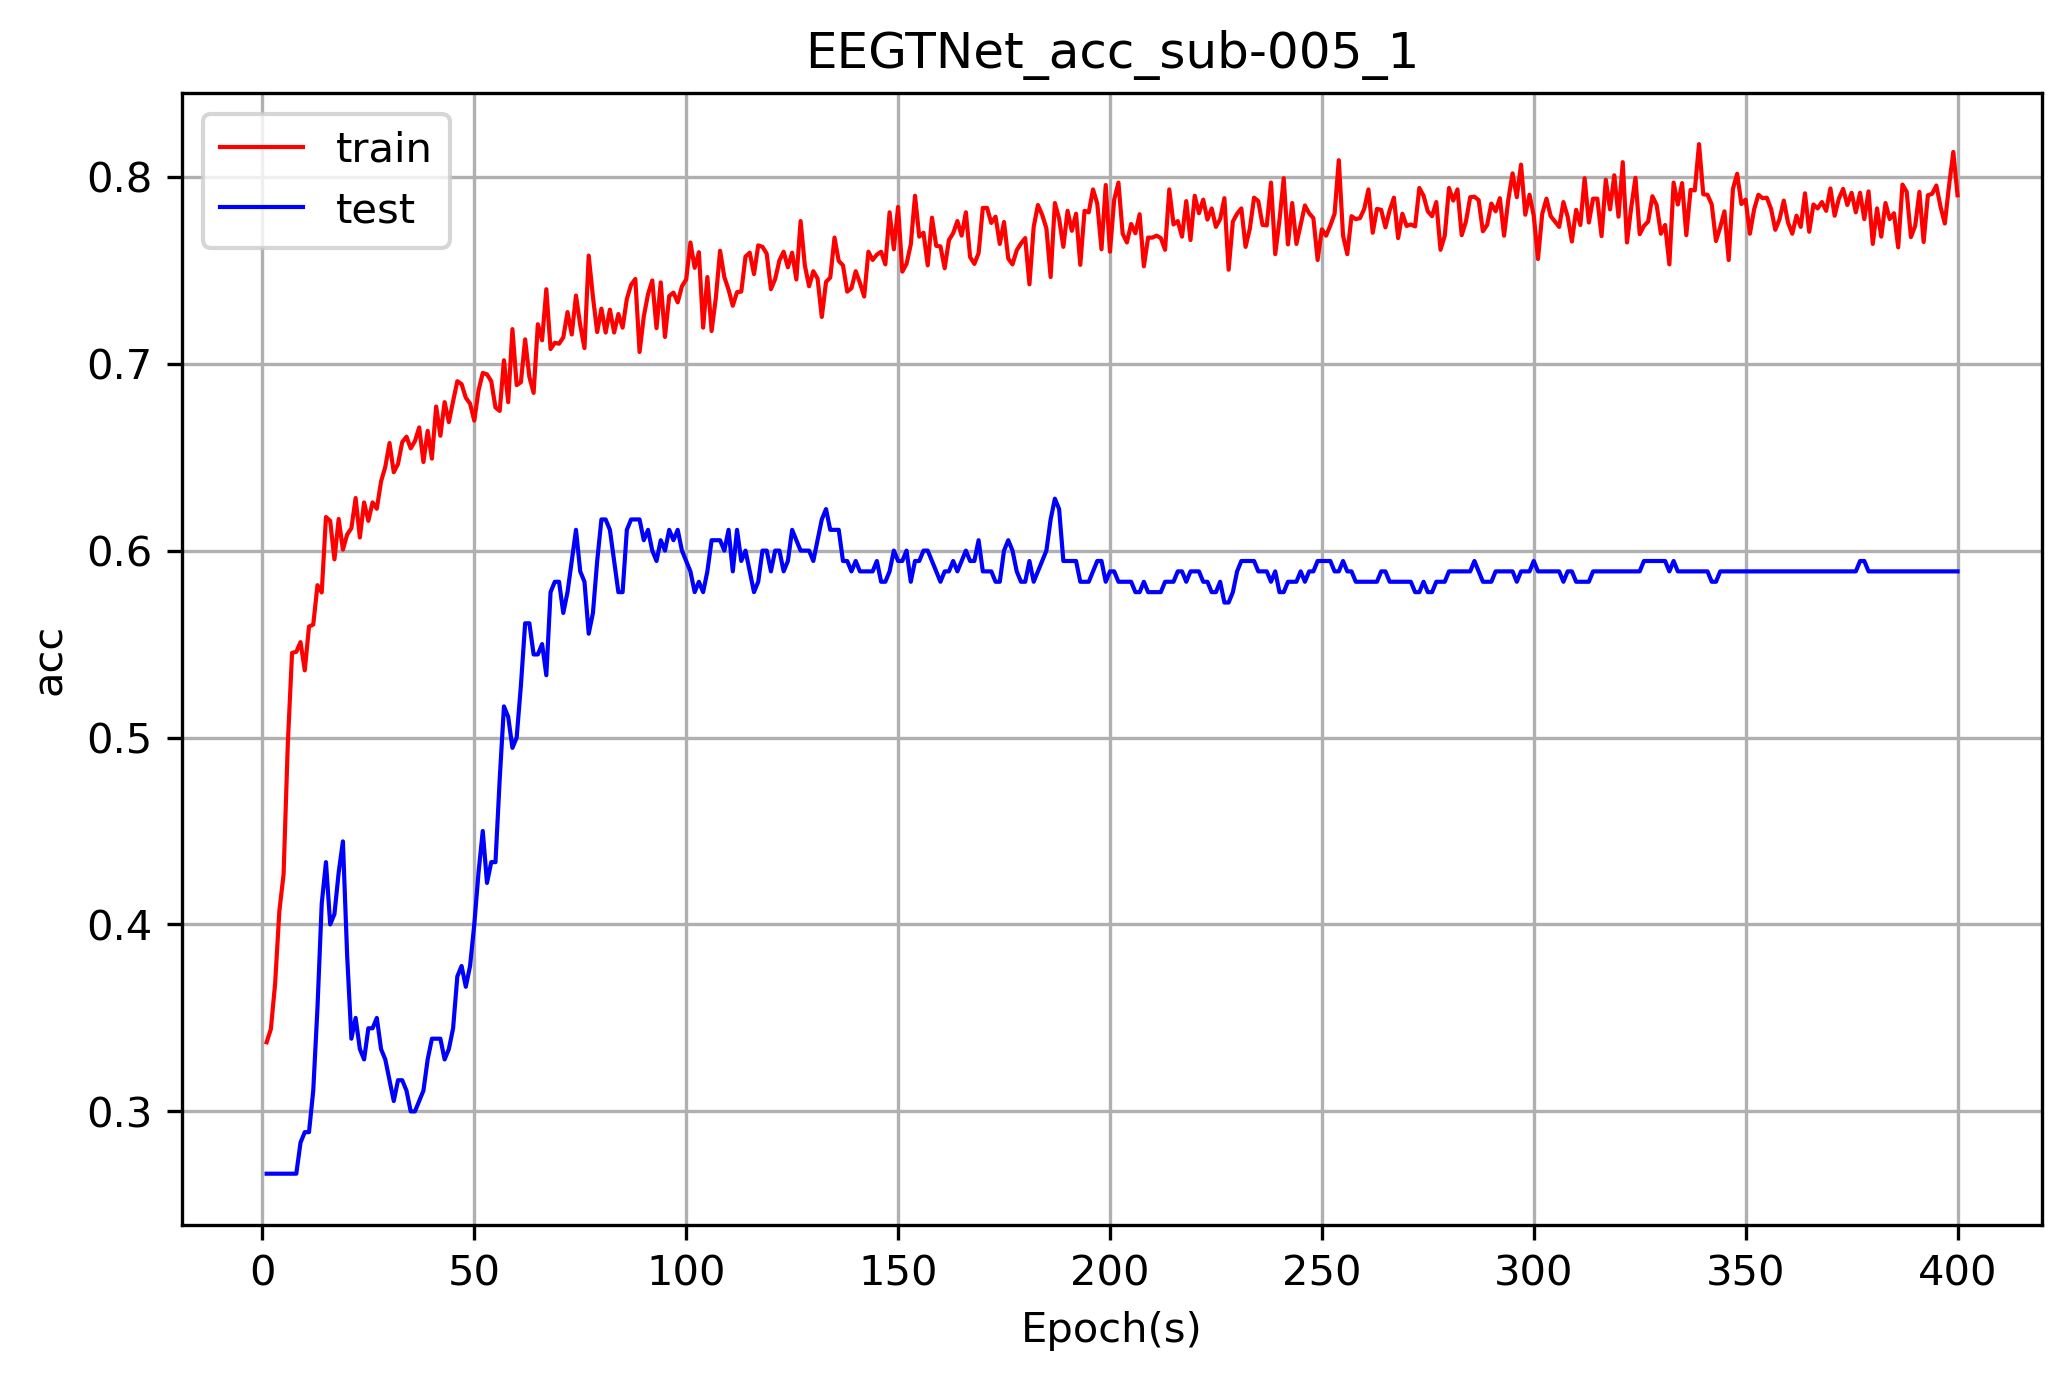

[2021-05-26 10:38:24] [INFO]    current_fold Acc : 0.5888888888888889
[2021-05-26 10:38:24] [INFO]    current_fold: 2 
[2021-05-26 10:38:24] [INFO]    model_path: C:/Users/BCIgroup/Desktop/yqh/Experiment/samelimb/samelimb_EEGTNet_4hp_noresample_e400_b128_1e-3decay/model/sub-005_fold_2_max_model.pt 


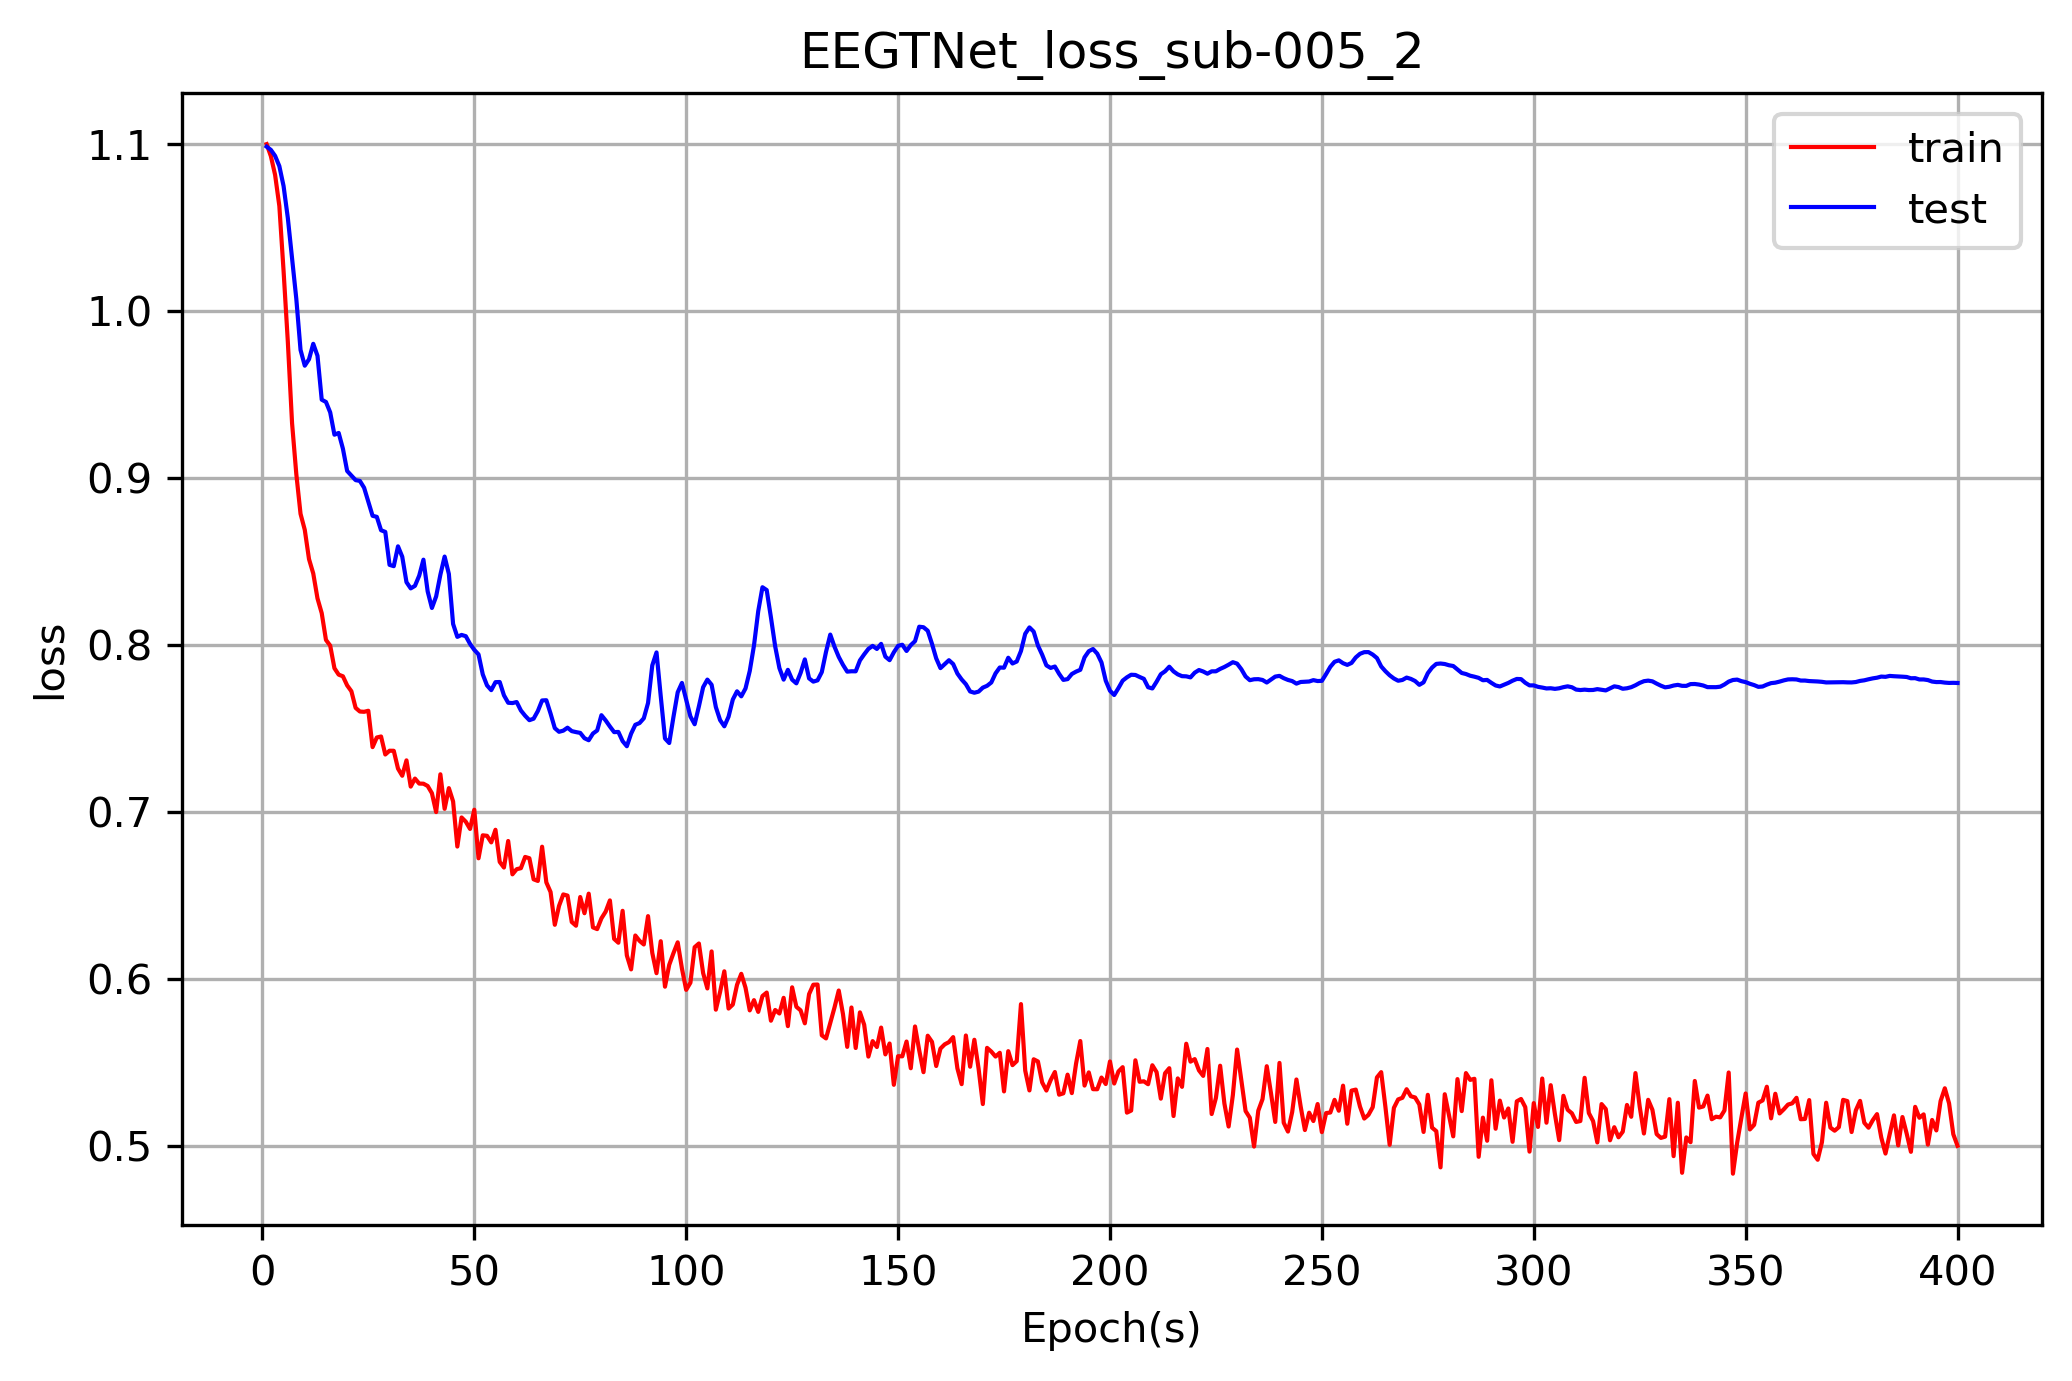

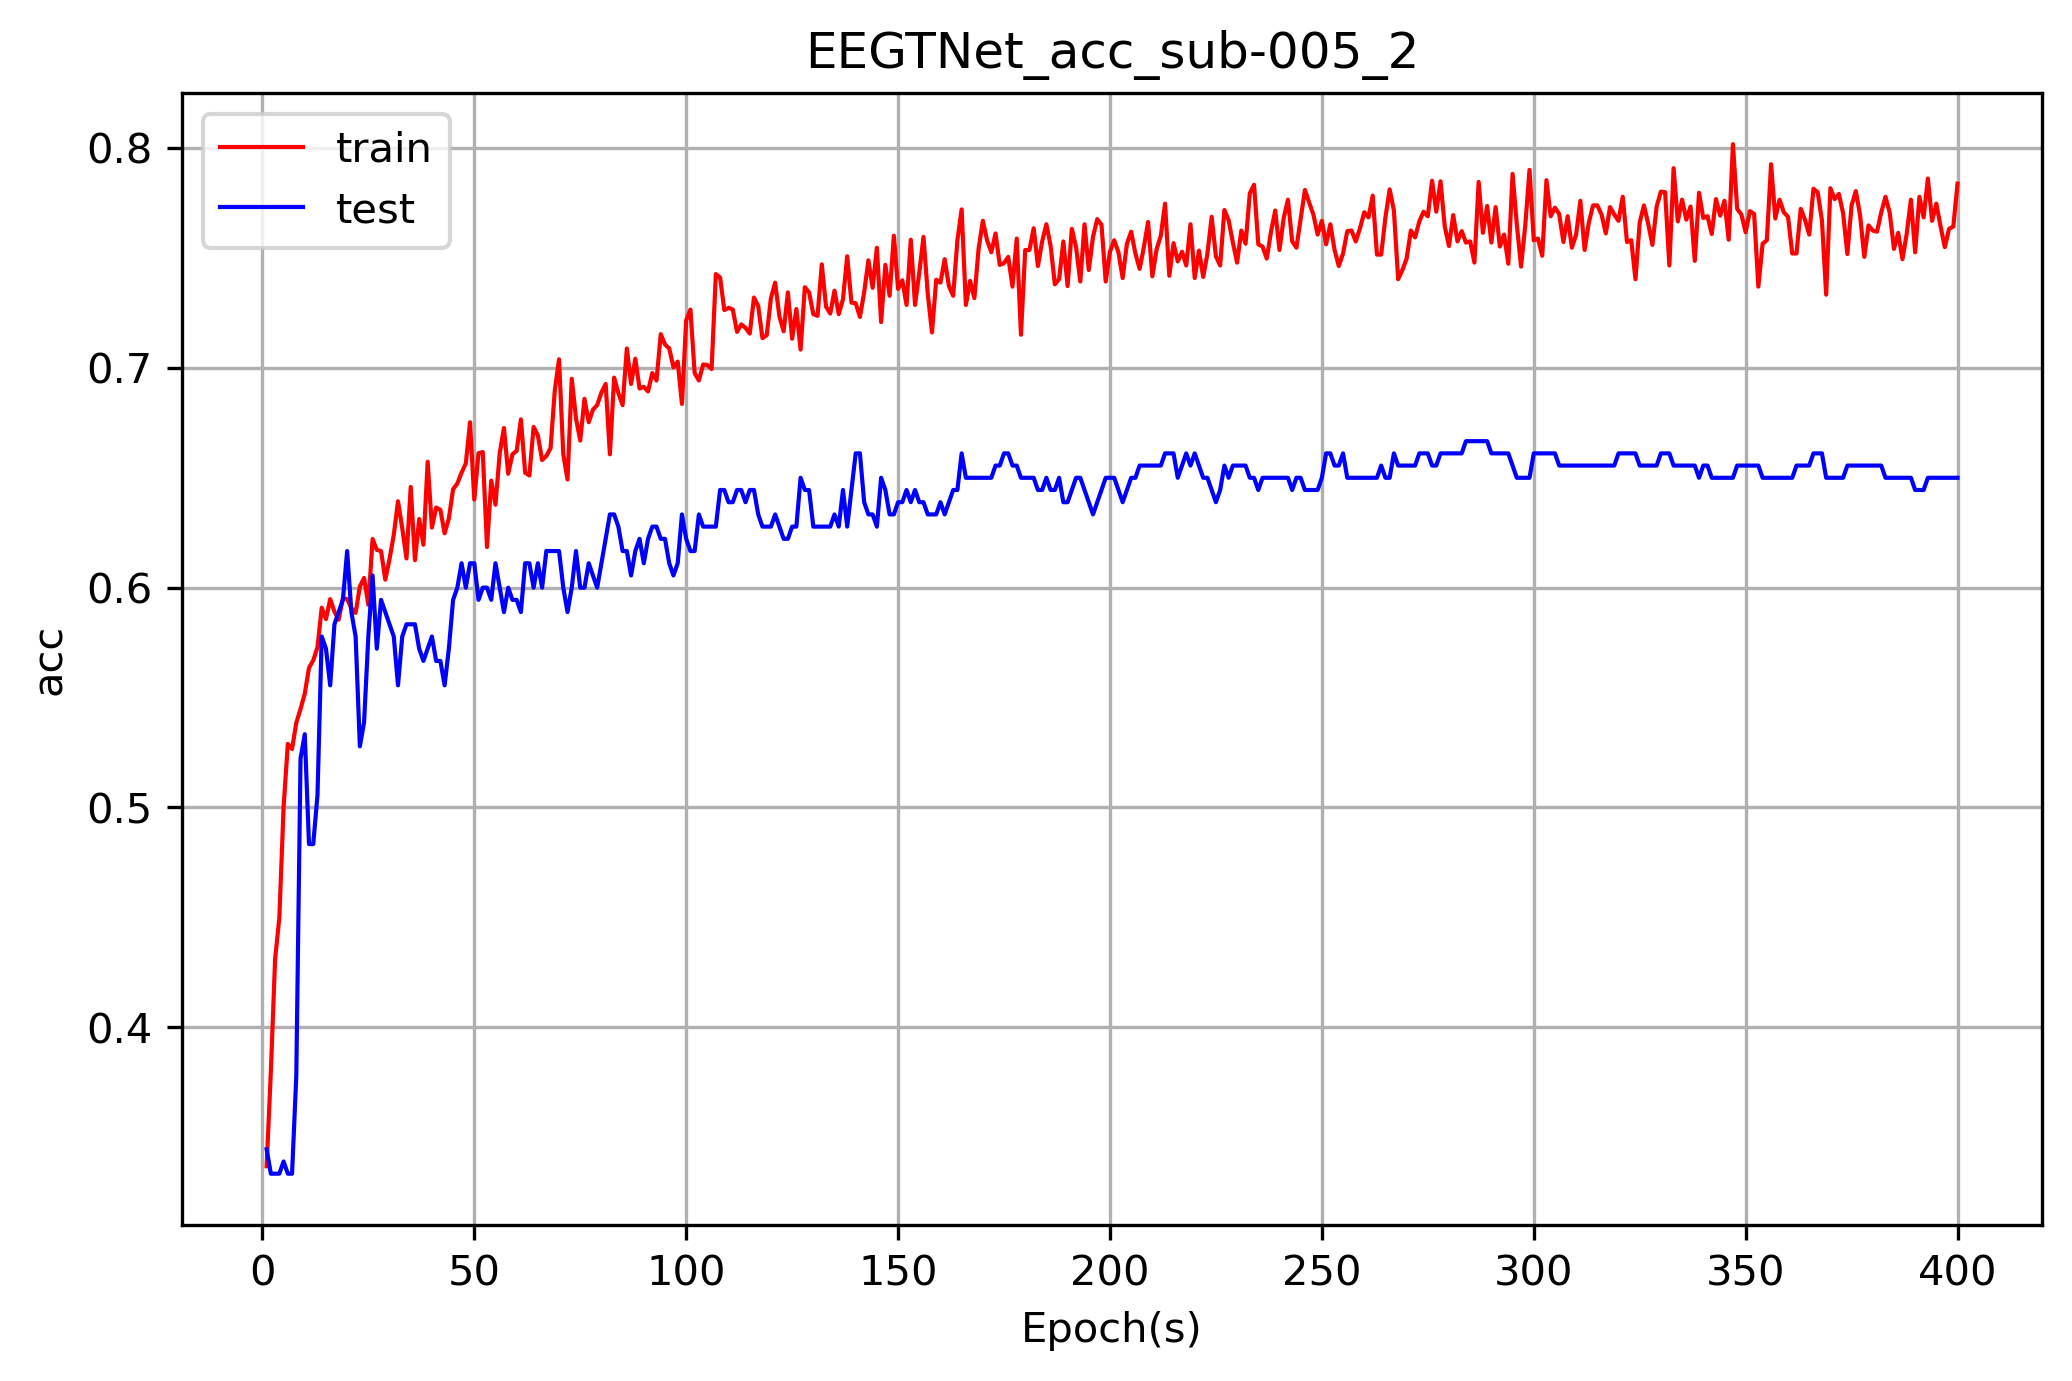

[2021-05-26 12:29:15] [INFO]    current_fold Acc : 0.65
[2021-05-26 12:29:15] [INFO]    current_fold: 3 
[2021-05-26 12:29:15] [INFO]    model_path: C:/Users/BCIgroup/Desktop/yqh/Experiment/samelimb/samelimb_EEGTNet_4hp_noresample_e400_b128_1e-3decay/model/sub-005_fold_3_max_model.pt 


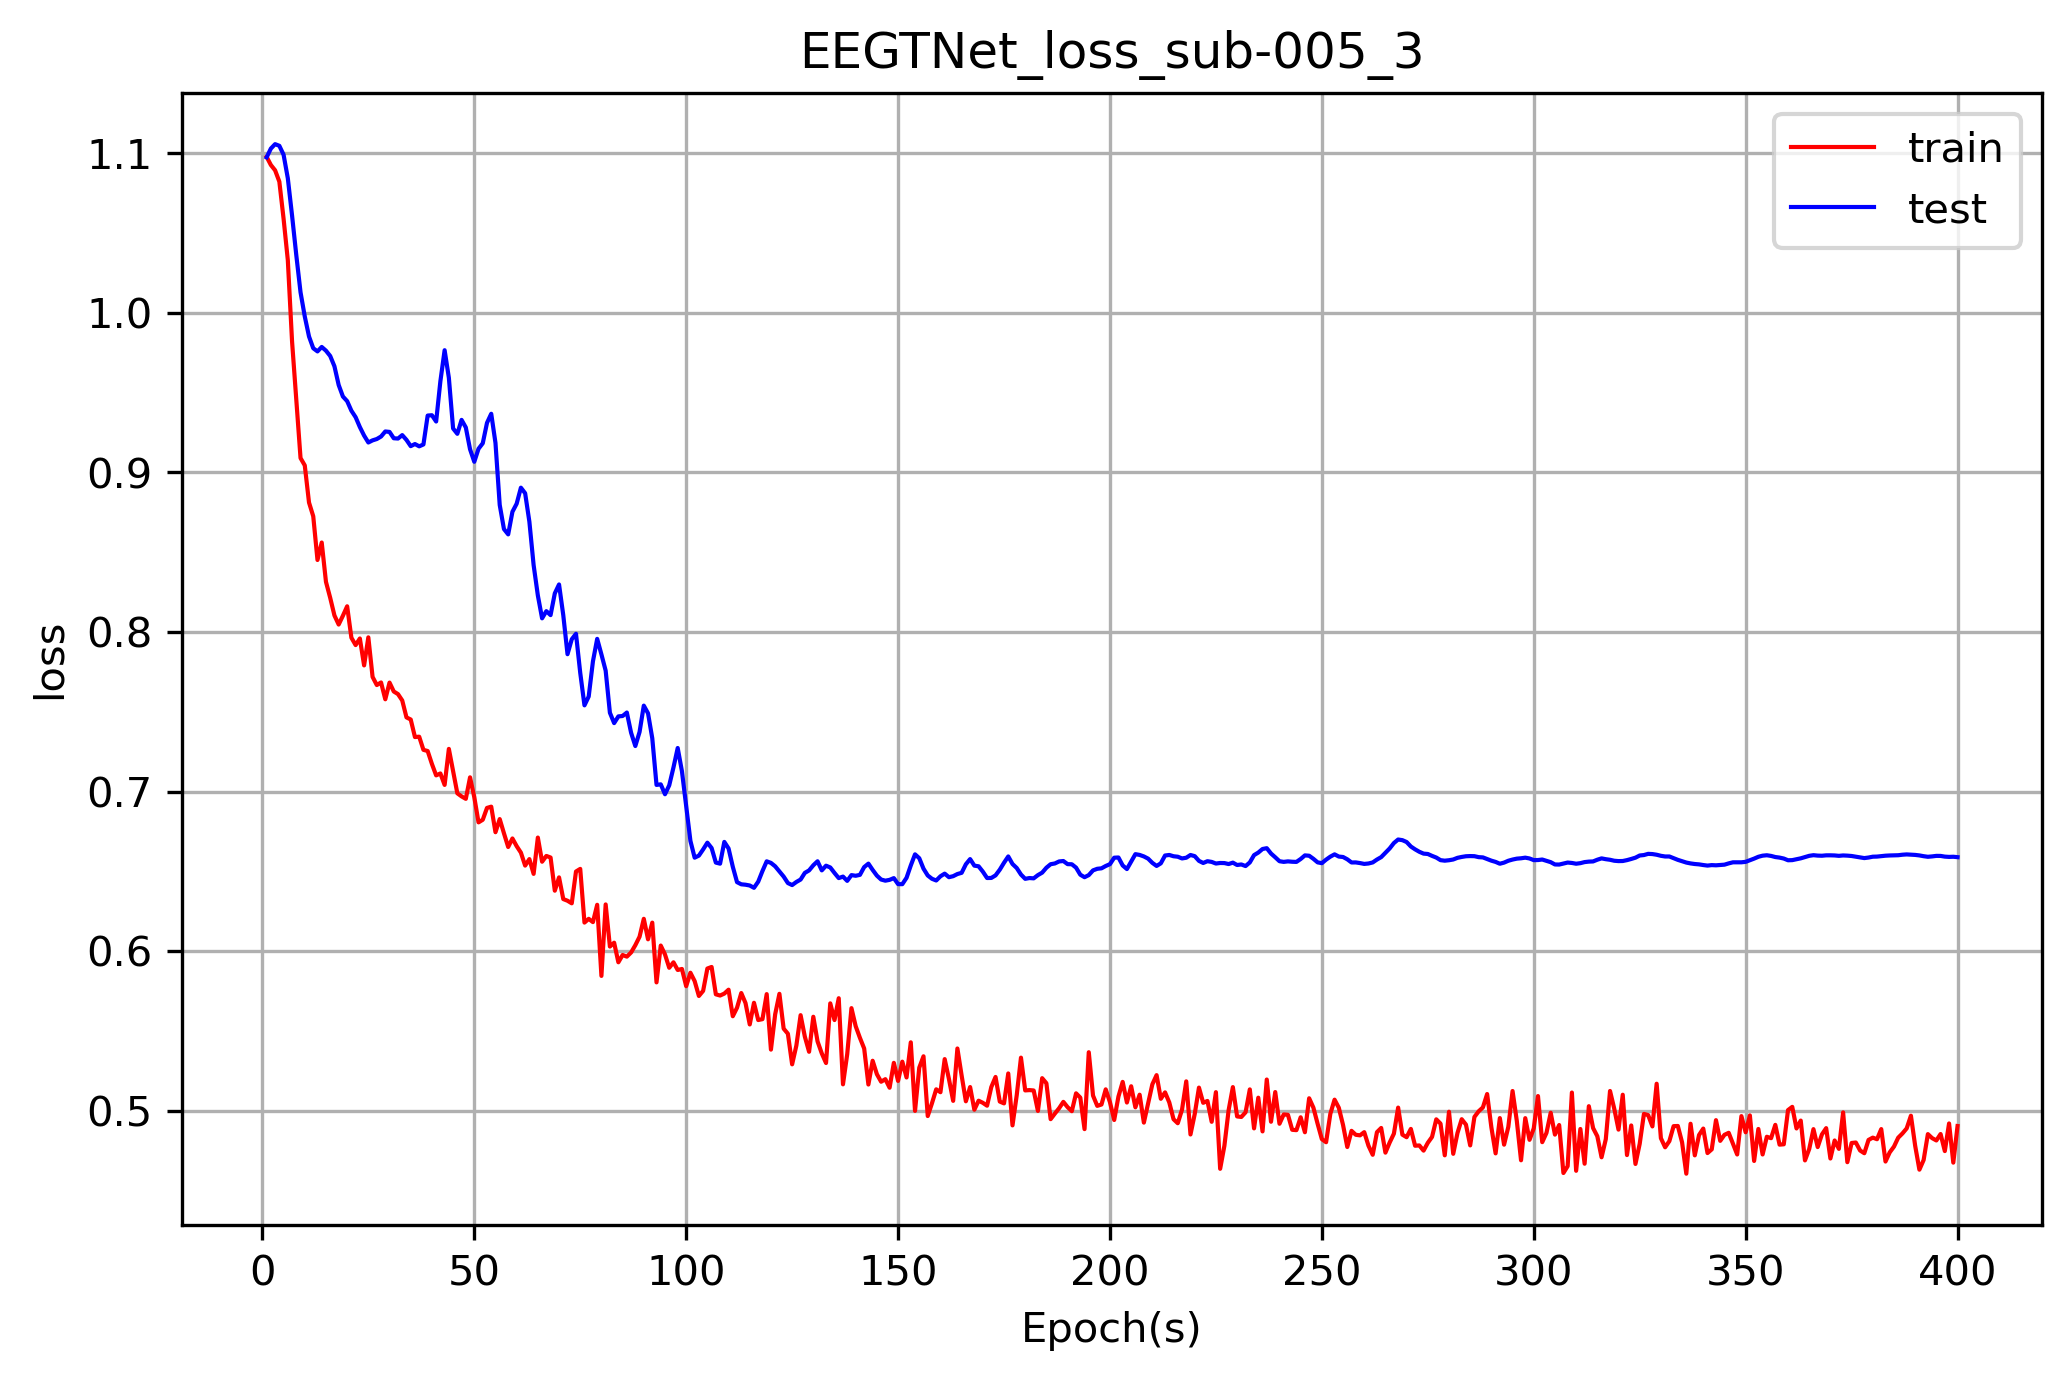

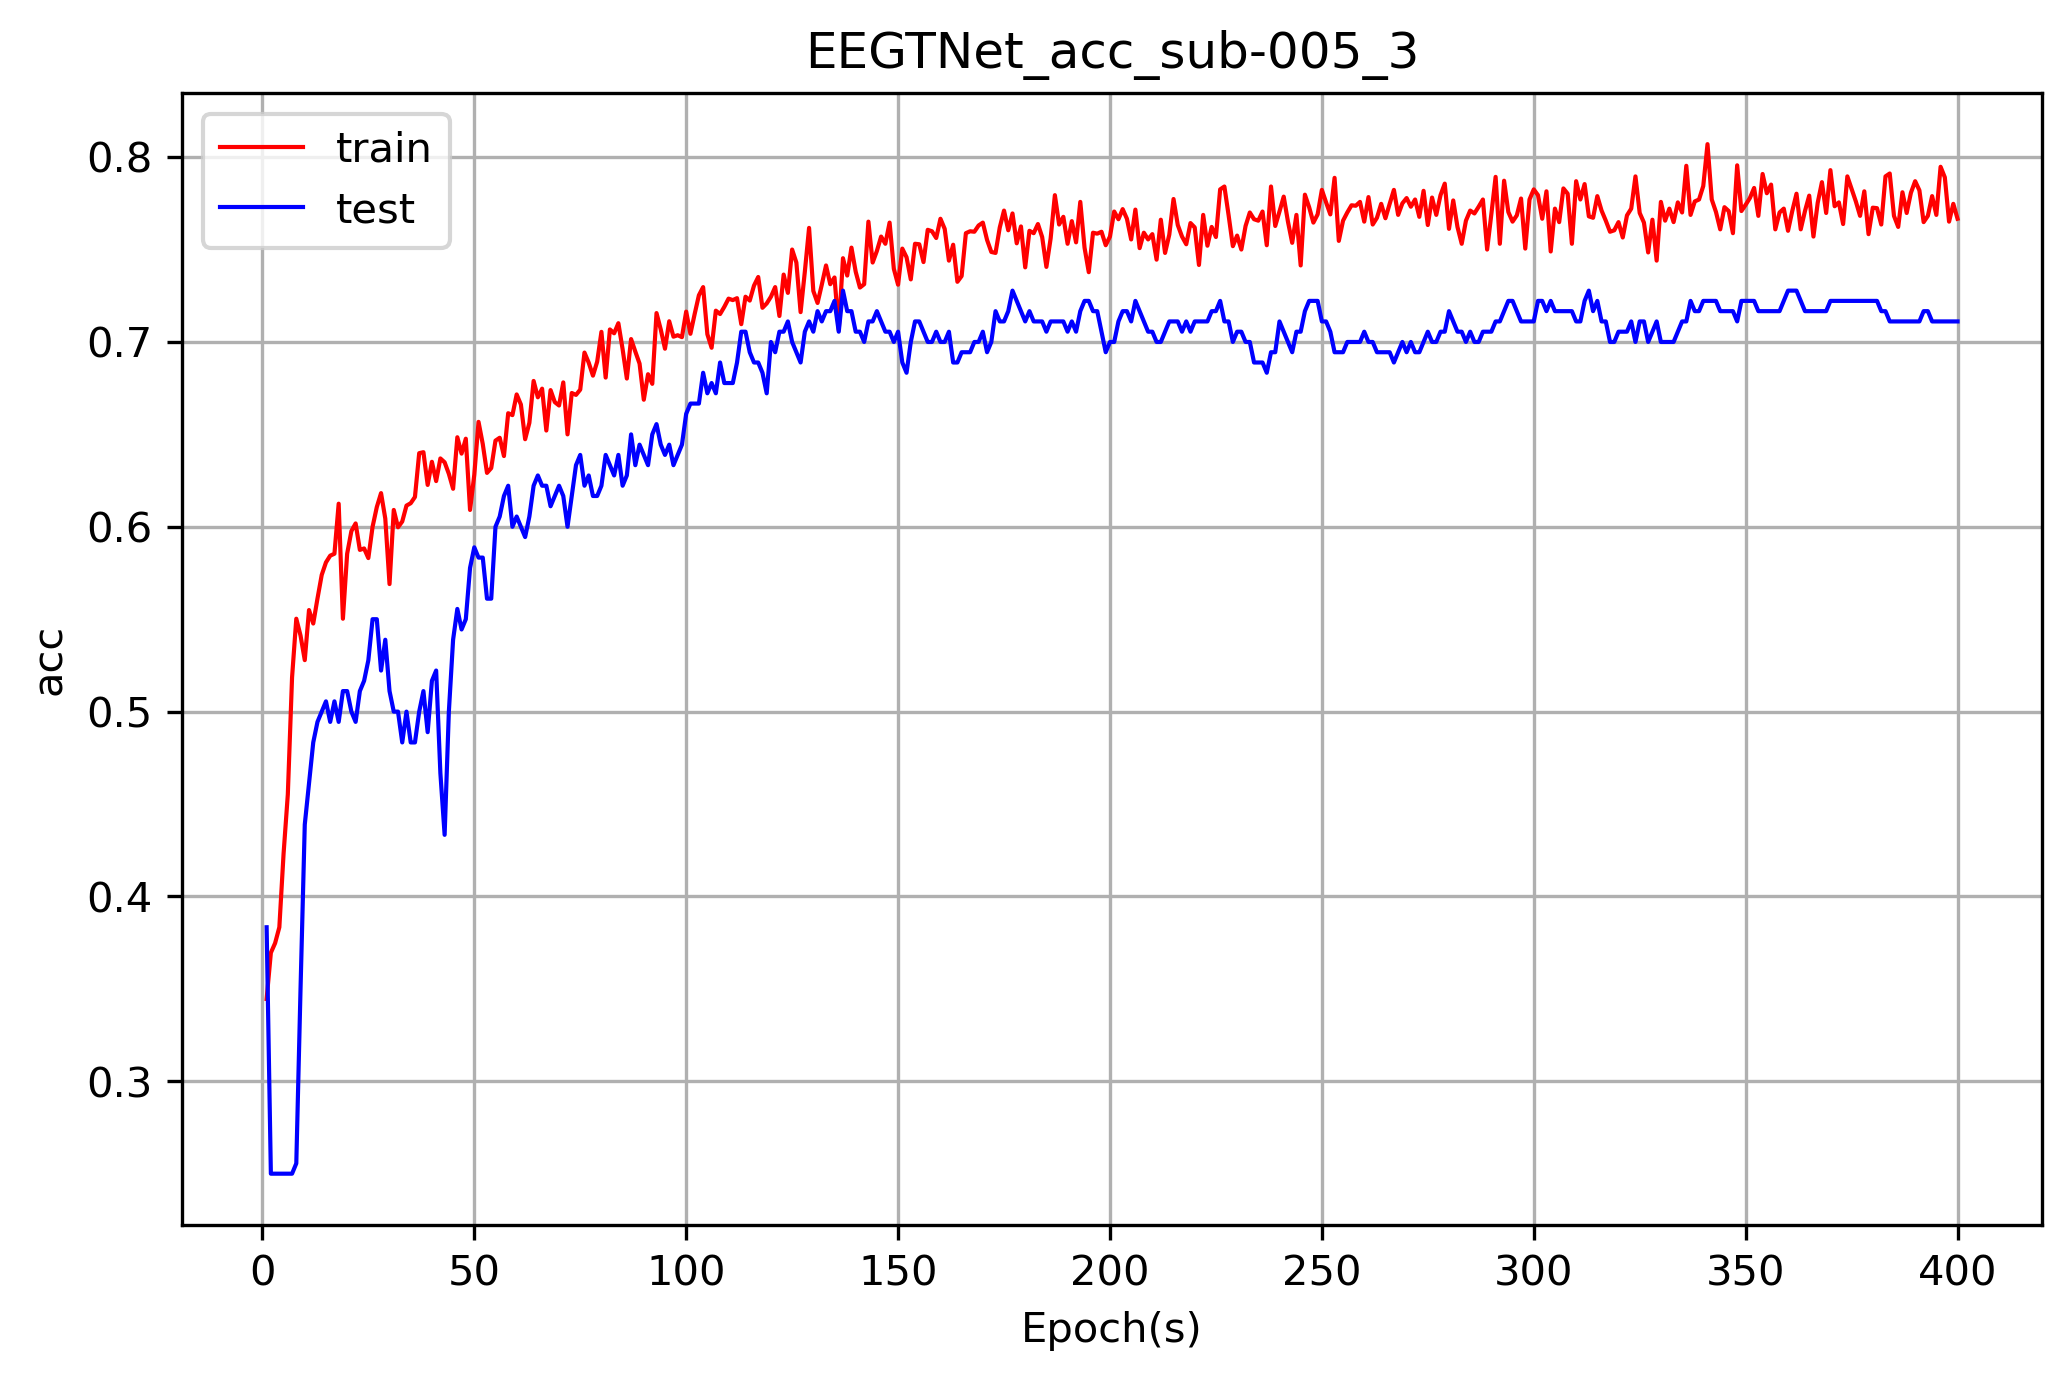

[2021-05-26 14:21:53] [INFO]    current_fold Acc : 0.7111111111111111
[2021-05-26 14:21:53] [INFO]    current_fold: 4 
[2021-05-26 14:21:53] [INFO]    model_path: C:/Users/BCIgroup/Desktop/yqh/Experiment/samelimb/samelimb_EEGTNet_4hp_noresample_e400_b128_1e-3decay/model/sub-005_fold_4_max_model.pt 


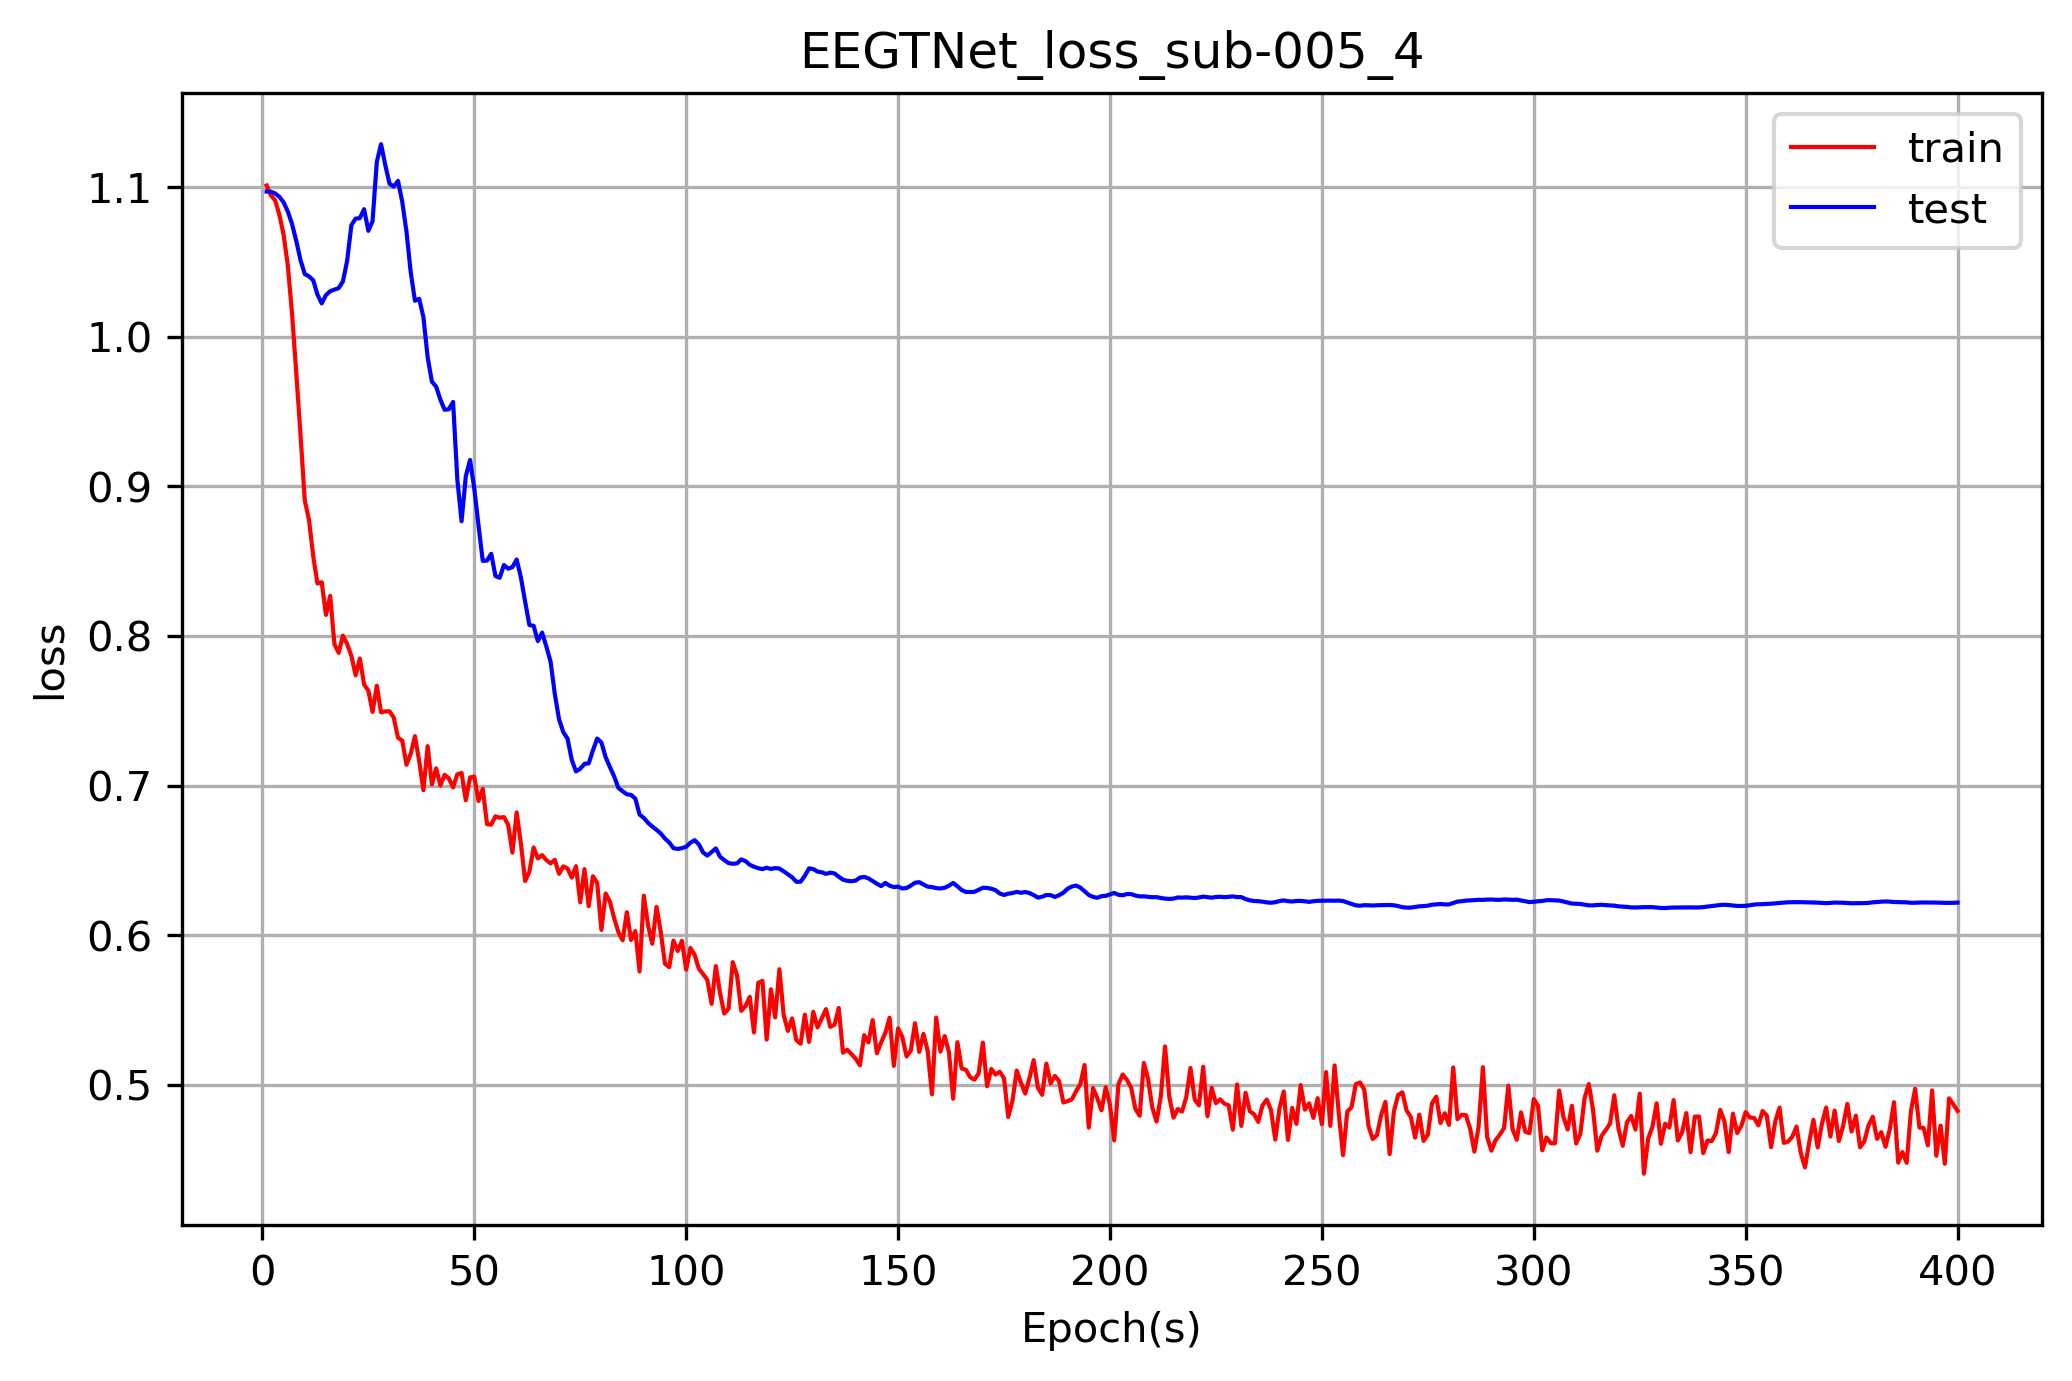

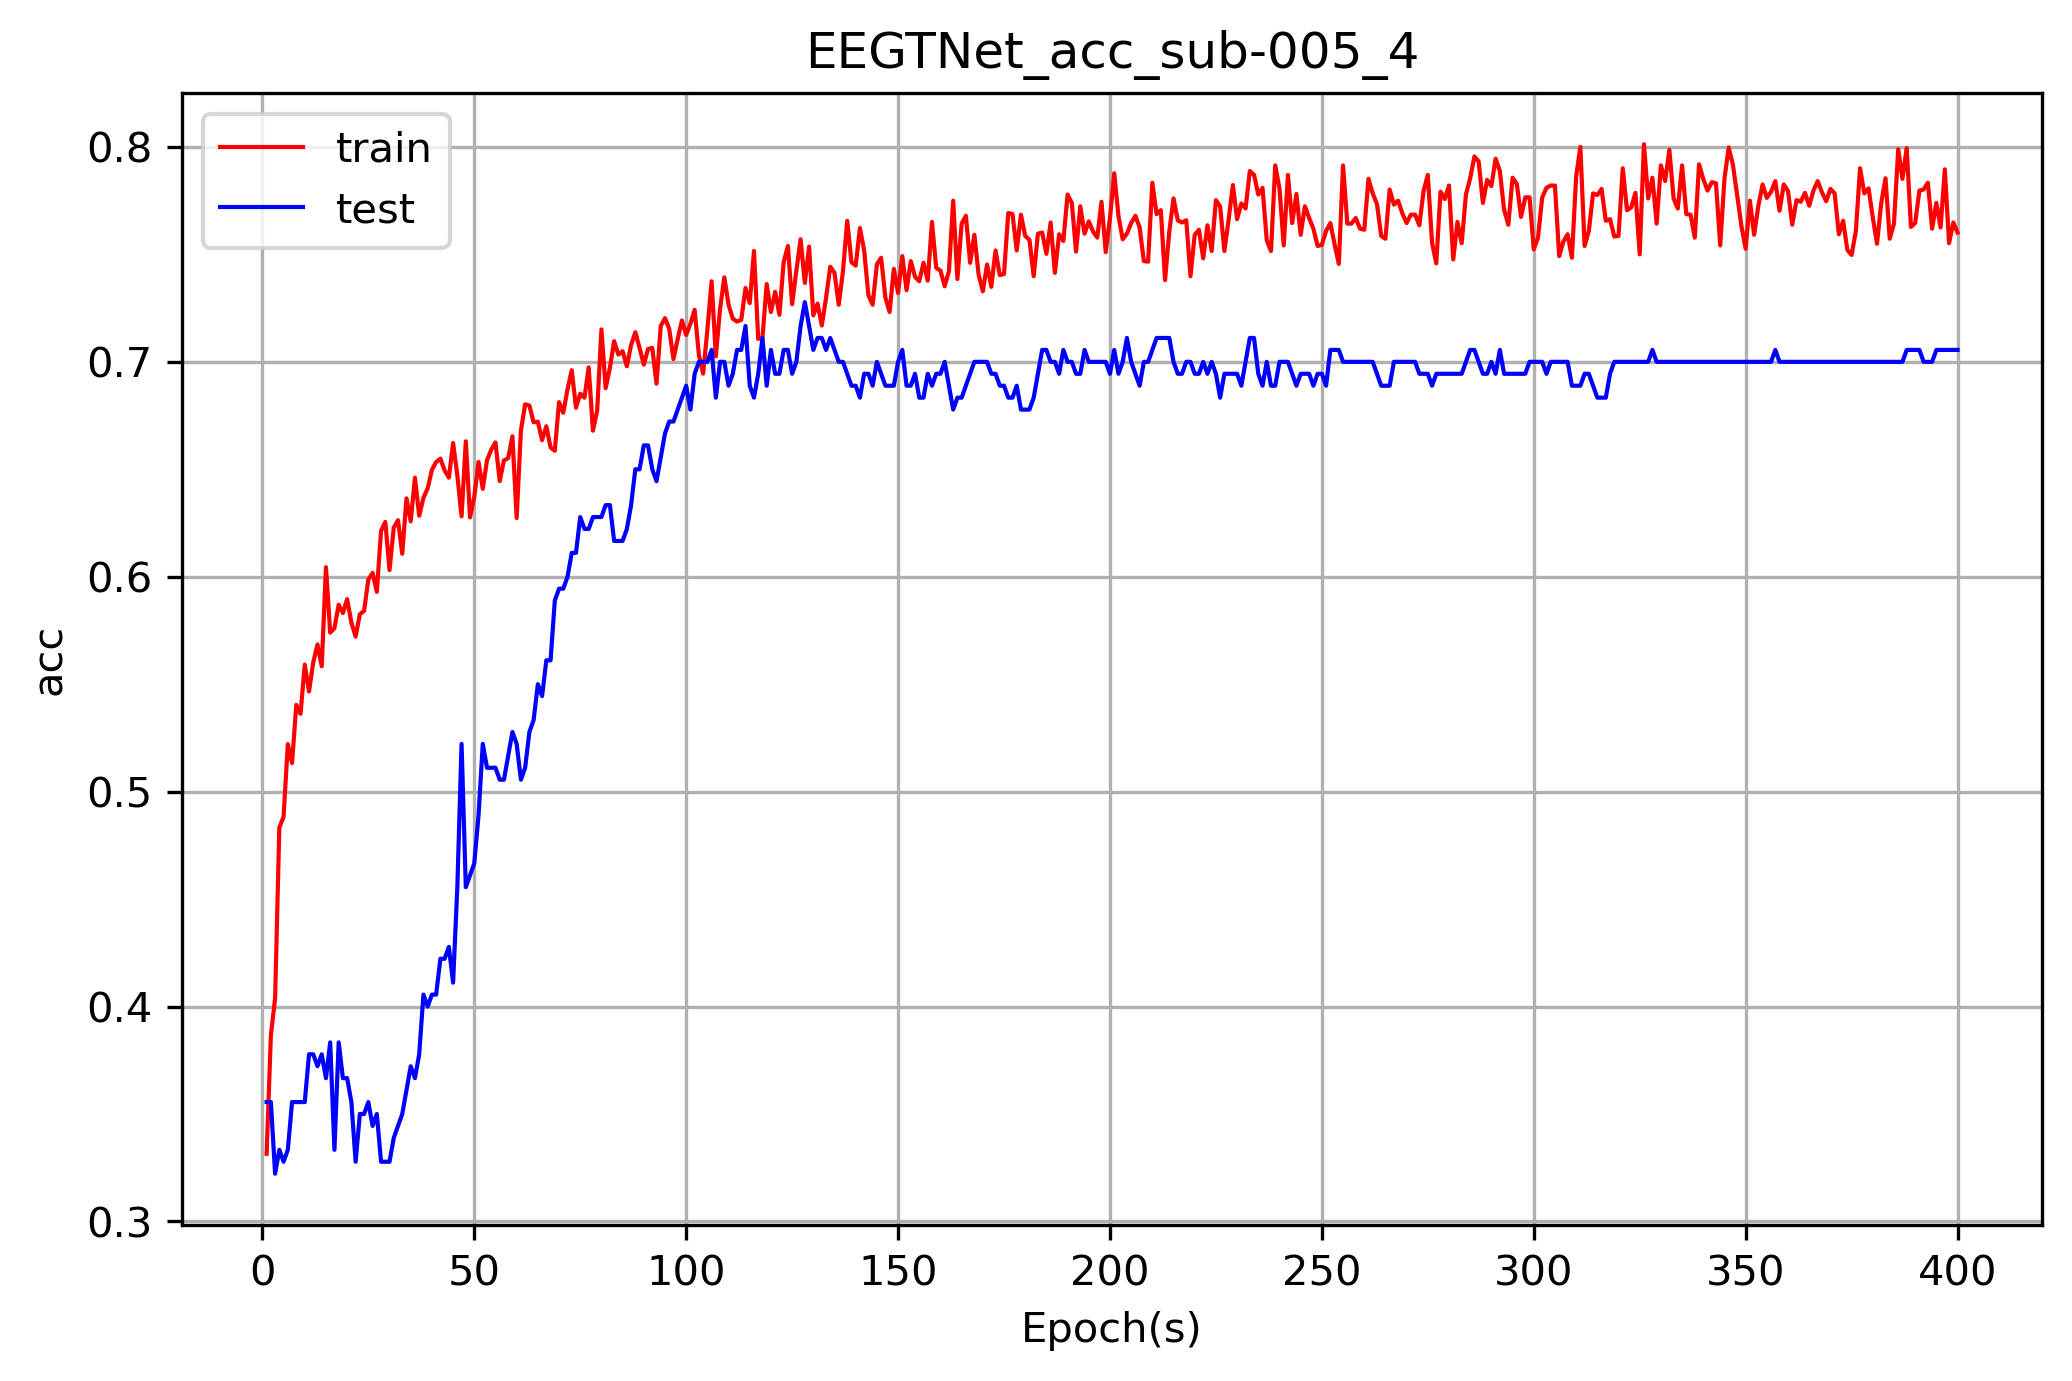

[2021-05-26 16:13:17] [INFO]    current_fold Acc : 0.7055555555555556
[2021-05-26 16:13:18] [INFO]    current_fold: 5 
[2021-05-26 16:13:18] [INFO]    model_path: C:/Users/BCIgroup/Desktop/yqh/Experiment/samelimb/samelimb_EEGTNet_4hp_noresample_e400_b128_1e-3decay/model/sub-005_fold_5_max_model.pt 


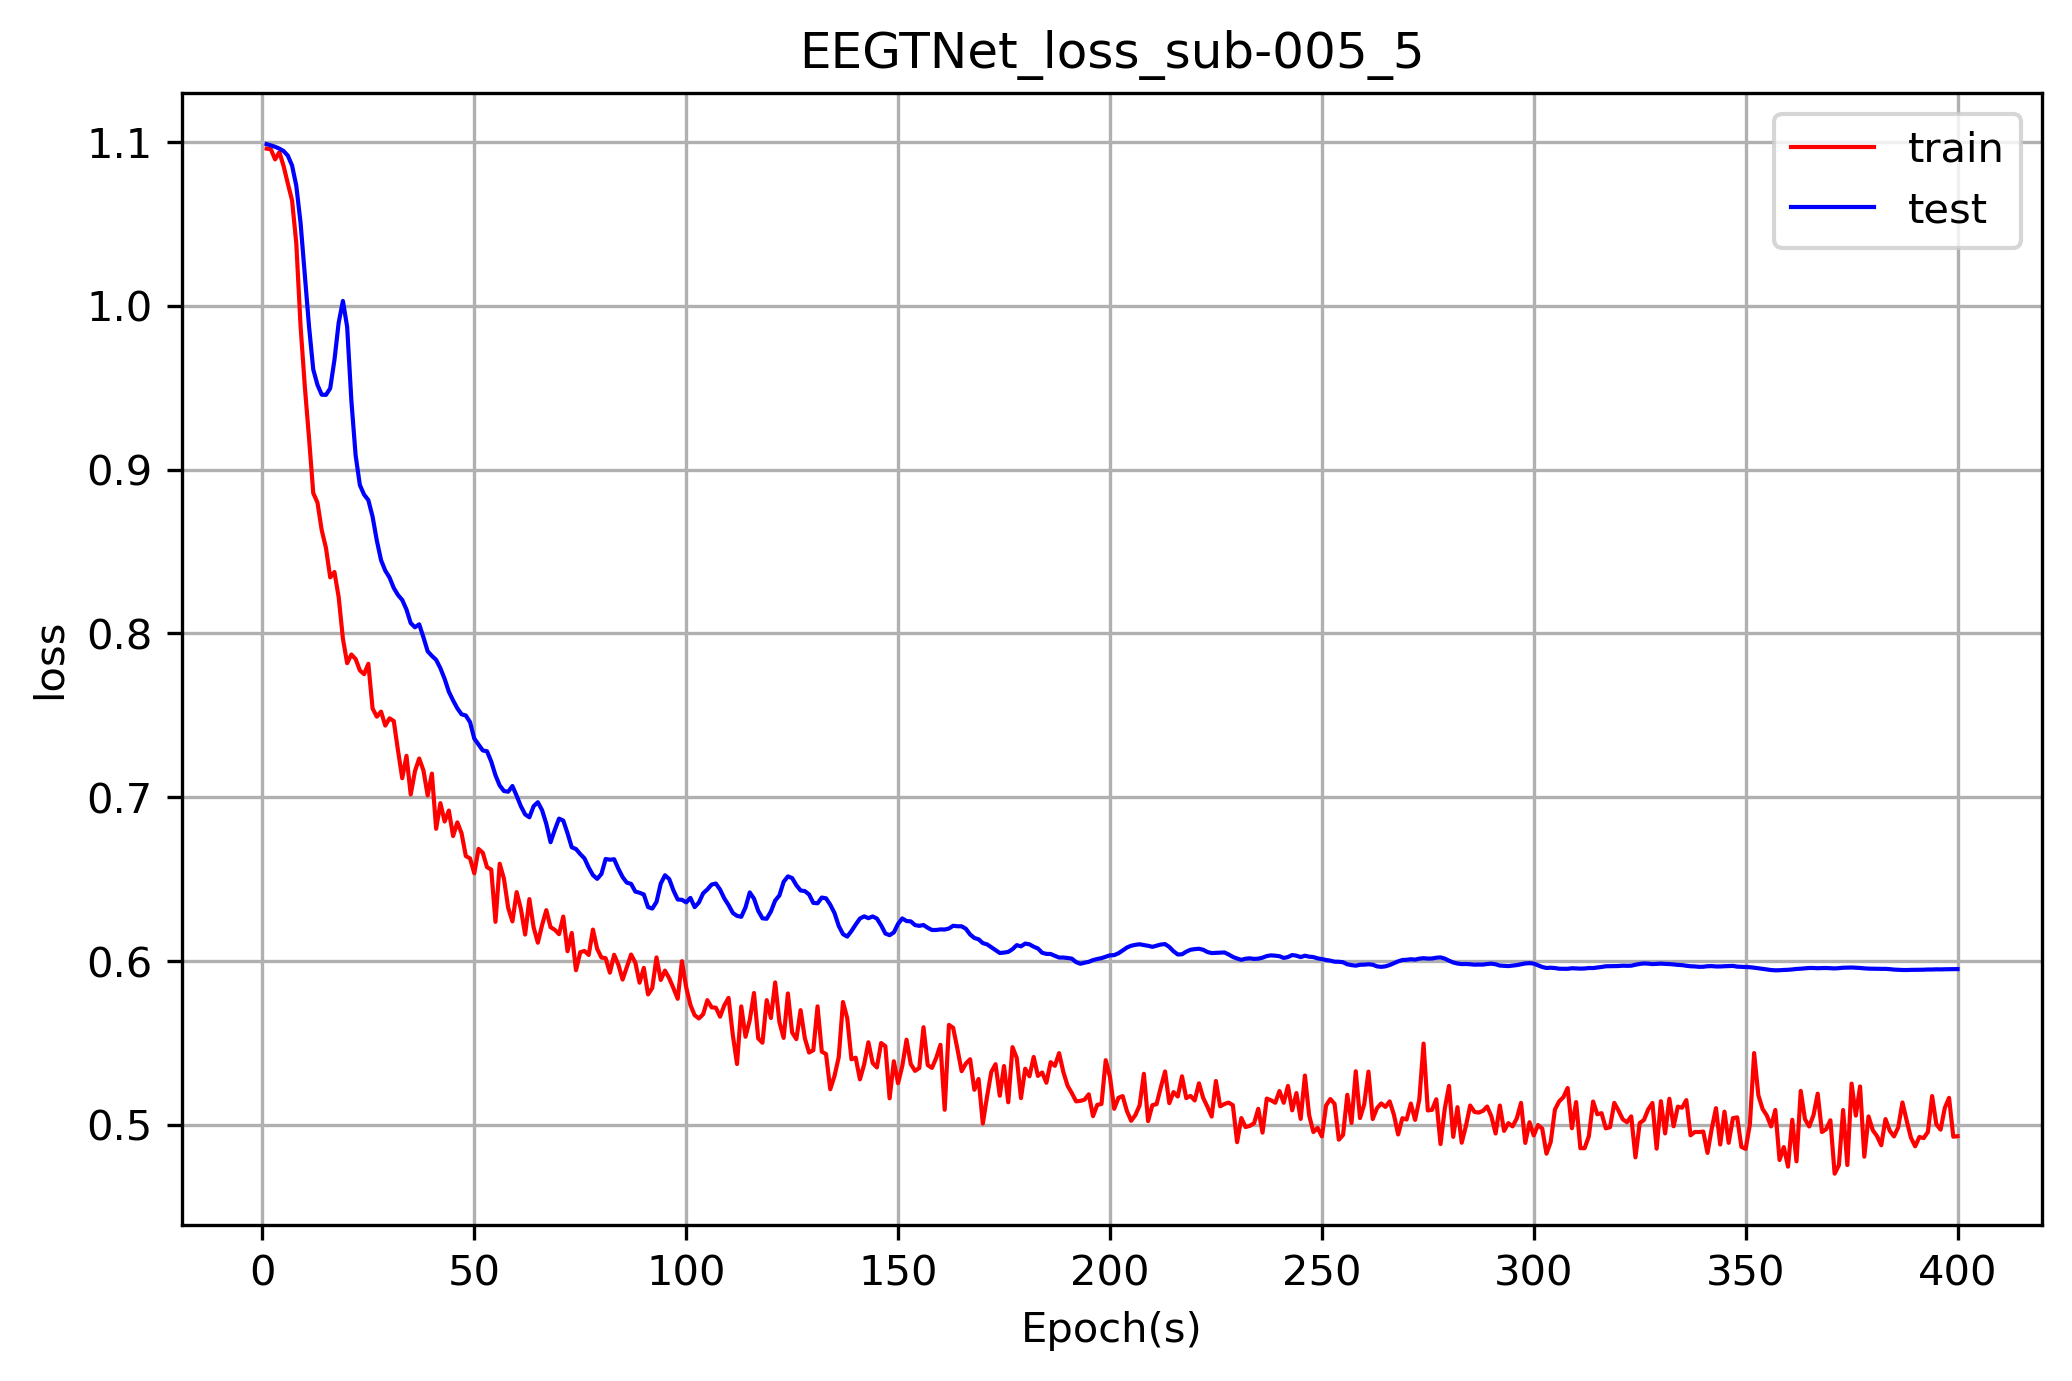

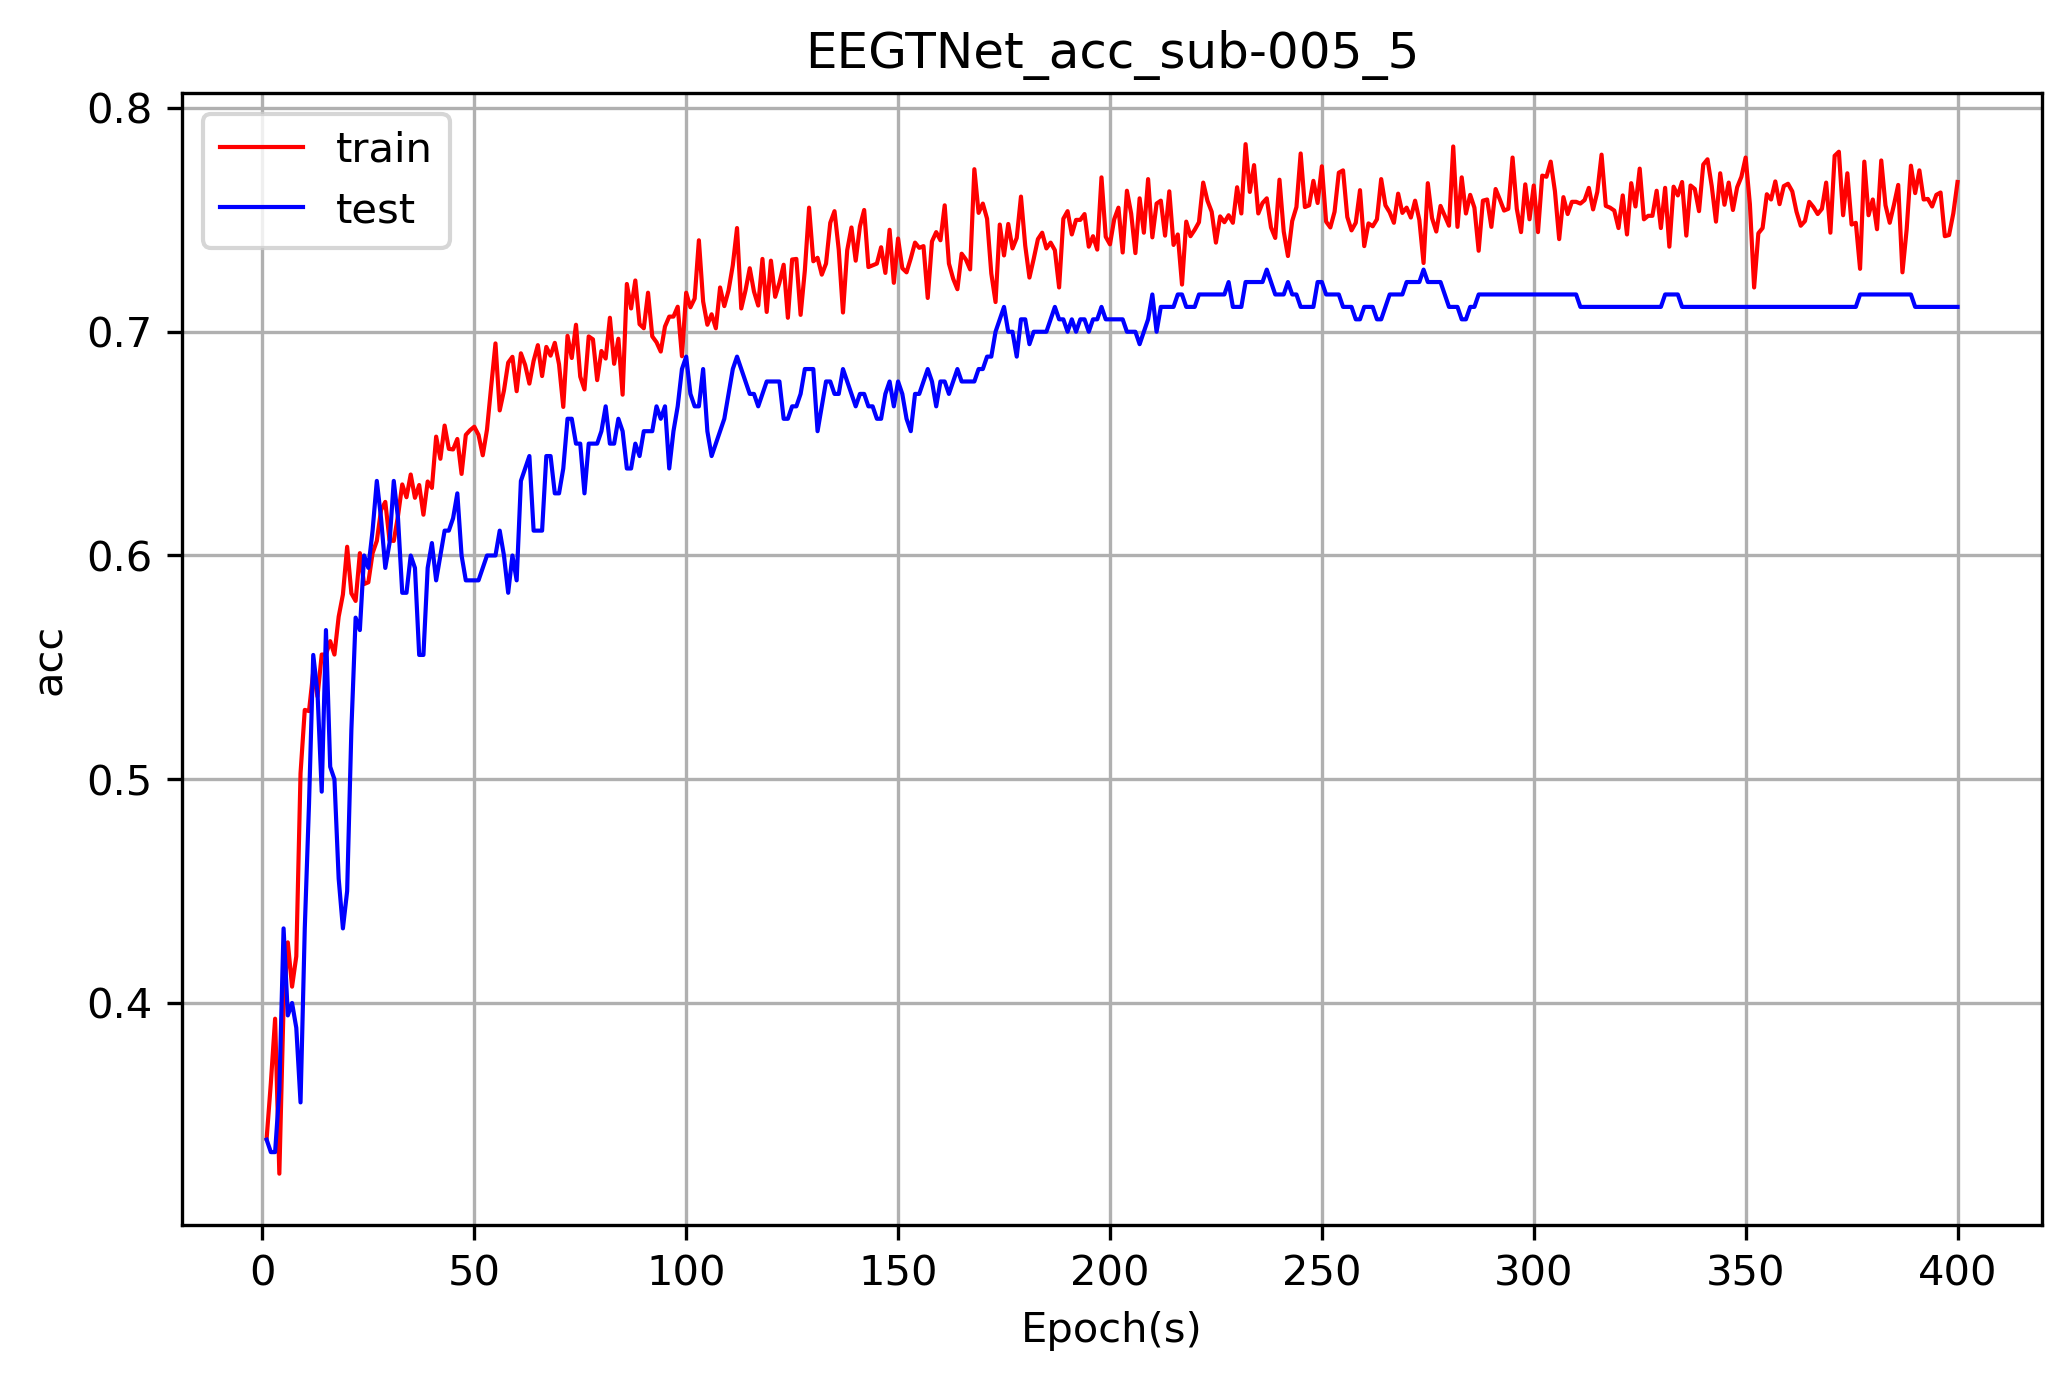

[2021-05-26 18:07:14] [INFO]    current_fold Acc : 0.7111111111111111
[2021-05-26 18:07:14] [INFO]    datapath 	sub-005_task-motorimagery_eeg
[2021-05-26 18:07:14] [INFO]    subject 	sub-005
[2021-05-26 18:07:14] [INFO]    result of KFlodTrain : [0.5888888888888889, 0.65, 0.7111111111111111, 0.7055555555555556, 0.7111111111111111]
[2021-05-26 18:07:14] [INFO]    mean of KFlodTrain 	0.6733 
[2021-05-26 18:07:14] [INFO]    std of KFlodTrain 	0.0481 


datapath C:\Users\BCIgroup\Desktop\yqh\data\samelimb\sub-006_task-motorimagery_eeg.mat
load C:\Users\BCIgroup\Desktop\yqh\data\samelimb\sub-006_task-motorimagery_eeg.mat


[2021-05-26 18:07:19] [INFO]    image_path: C:/Users/BCIgroup/Desktop/yqh/Experiment/samelimb/samelimb_EEGTNet_4hp_noresample_e400_b128_1e-3decay/image/ 
[2021-05-26 18:07:19] [INFO]    logpath: C:/Users/BCIgroup/Desktop/yqh/Experiment/samelimb/samelimb_EEGTNet_4hp_noresample_e400_b128_1e-3decay/log/samelimb_EEGTNet_4hp_noresample_e400_b128_1e-3decay.log 
[2021-05-26 18:07:19] [INFO]    current_fold: 1 
[2021-05-26 18:07:19] [INFO]    model_path: C:/Users/BCIgroup/Desktop/yqh/Experiment/samelimb/samelimb_EEGTNet_4hp_noresample_e400_b128_1e-3decay/model/sub-006_fold_1_max_model.pt 


KeyboardInterrupt: 

In [20]:
# adj = Utils.get_adj(60, 'ng') #(60, 60) <class 'numpy.matrix'>
# adj = np.expand_dims(adj, 0) 
# adj = torch.from_numpy(adj) #torch.Size([1, 60, 60]) <class 'torch.Tensor'>

datalist = Utils.loadpath('C:/Users/BCIgroup/Desktop/yqh/data/samelimb', start=3, len=25)
pipeline = pipeLine(logger, EEGTNet)
pipeline.set_parameter(rootpath=rootpath,
                           model='EEGTNet', classes_num=3, temporal_kernel_size=64,C2=8,
                           pooling_one_size=4, pooling_two_size=8, dropout=0.25,
                           dataset='samelimb', fs=128, start=0, end=4, filter_highcut=4, filter_order=5,
                           split_ratio=0.8, seed=42,
                           learning_rate=1e-3, learning_decay=pow(0.001, 1 / 600), weight_decay=1e-4,
                           use_early_stop=True, use_lr_decay=True,
                           epochs=400, batch_size=128, kfold=5, fold_start=1)

for dp in datalist:
    pipeline.loadDatahhg(dp)
    pipeline.KFoldTrain()

In [ ]:
# # adj = Utils.get_adj(60, 'ng') #(60, 60) <class 'numpy.matrix'>
# # adj = np.expand_dims(adj, 0) 
# # adj = torch.from_numpy(adj) #torch.Size([1, 60, 60]) <class 'torch.Tensor'>

# datalist = Utils.loadpath('C:/Users/BCIgroup/Desktop/yqh/data/samelimb', start=1, len=25)
# pipeline = pipeLine(logger, EEGTNet)
# pipeline.set_parameter(rootpath=rootpath,
#                            model='EEGTNet', classes_num=3, temporal_kernel_size=64,C2=8,
#                            pooling_one_size=4, pooling_two_size=8, dropout=0.25,
#                            dataset='samelimb', fs=128, start=0, end=4, filter_highcut=4, filter_order=5,
#                            split_ratio=0.8, seed=42,
#                            learning_rate=1e-3, learning_decay=pow(0.001, 1 / 600), weight_decay=1e-4,
#                            use_early_stop=True, use_lr_decay=True,
#                            epochs=400, batch_size=128, kfold=5, fold_start=1)

# for dp in datalist:
#     pipeline.loadDatahhg(dp)
#     pipeline.KFoldTrain()

In [ ]:
#shuffle 只在划分数据集时打乱seed=42
#400epoch C1=64 C2=8 L=2 PE=0.25 